# Team Based Model

## Imports

In [1]:
import pep8
import autopep8
import sqlite3
import joblib
import optuna
import plotly.graph_objects as go
import plotly.express as px
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid
import pickle
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import learning_curve, validation_curve
import sklearn.model_selection
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, Ridge,  LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

sys.path.append("..")

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pep8.py:110: FutureWarning: Possible nested set at position 1
  EXTRANEOUS_WHITESPACE_REGEX = re.compile(r'[[({] | []}),;:]')
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_t

In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=120

## Gather Team Level Basic, Advanced, and Scoring Data

In [3]:
def load_team_data(conn):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", connection)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", connection)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", connection)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    return df


connection = sqlite3.connect('../data/nba.db')
df = load_team_data(connection)
connection.close()

In [4]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)

    df = df.dropna(subset=['E_OFF_RATING'])

    return df


clean_df = clean_team_data(df)
clean_df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53825  2021-22  1610612746               LAC             LA Clippers   
53826  2021-22  1610612743               DEN          Denver Nuggets   
53827  2021-22  1610612742               DAL        Dallas Mavericks   
53828  2021-22  1610612739               CLE     Cleveland Cavaliers   
53829  2021-22  1610612747               LAL      Los Angeles Lakers   

          GAME_ID  GAME_DATE      MATCHUP  WL  MIN  FGM  FGA  FG_PCT  FG3M  \
0      0020000002 2000-10-31    CLE @ BKN   1  240   32   78   0.410     2   
1      0020000002 2000-10-31  BKN vs. CLE   0  240   31   85   0.365     3   
2      0020000008 2000-10-31  HOU vs. MIN   0  240   34   74   0.459     2   
3      0020000008 2000-10-31    MIN @ HOU   1  240   43   88   0.489     6   
4      0020000009 2000-10-31  SAS vs. IND   1  240   33   64   0.516     4   
...           ...        ...          ...  ..  ...  ...  ...     ...   ...   
53825  0022100076 2021-10-29    LAC @ POR   0  240   34   87   0.391    15   
53826  0022100075 2021-10-29  DEN vs. DAL   1  240   43   83   0.518    11   
53827  0022100075 2021-10-29    DAL @ DEN   0  240   23   78   0.295     8   
53828  0022100077 2021-10-29    CLE @ LAL   0  240   37   87   0.425    12   
53829  0022100077 2021-10-29  LAL vs. CLE   1  240   46   84   0.548    12   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  \
0         7    0.286   20   32   0.625    11    41   52   16    5    8   19   
1        10    0.300   17   26   0.654    12    35   47   24    9    8   15   
2         9    0.222   28   40   0.700    11    27   38   18    9    7   18   
3        11    0.545   14   16   0.875    13    31   44   29    7    1   16   
4         8    0.500   28   35   0.800     5    32   37   17    6    4   18   
...     ...      ...  ...  ...     ...   ...   ...  ...  ...  ...  ...  ...   
53825    42    0.357    9   16   0.563     6    37   43   17    7    5   13   
53826    36    0.306    9   13   0.692     5    46   51   28    8    3   20   
53827    37    0.216   21   27   0.778     6    30   36   14    8    3   15   
53828    34    0.353   15   22   0.682    16    20   36   28   10    1   15   
53829    27    0.444    9   10   0.900    11    31   42   24    9    6   22   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
0      27   86           4          85.9        87.8          82.5   
1      31   82          -4          82.5        83.7          85.9   
2      17   98          -8          99.4       103.2         108.1   
3      25  106           8         108.1       110.4          99.4   
4      22   98          13         106.1       104.3          90.7   
...    ..  ...         ...           ...         ...           ...   
53825  14   92         -19          91.1        92.9         107.7   
53826  24  106          31         102.2       105.0          75.8   
53827  17   75         -31          75.8        75.8         102.2   
53828  13  101         -12         105.6       108.6         113.7   
53829  20  113          12         113.7       120.2         105.6   

       DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  \
0            83.7           3.5         4.1    0.500     0.84       12.6   
1            87.8          -3.5        -4.1    0.774     1.60       17.7   
2           110.4          -8.7        -7.3    0.529     1.00       14.1   
3           103.2           8.7         7.3    0.674     1.81       20.7   
4            90.4          15.4     

In [5]:
from src.data.make_team_dataset import prep_for_aggregation


def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()

    df = df.drop(columns=['FT_PCT', 'FG_PCT', 'FG3_PCT', 'DREB_PCT',
                          'OREB_PCT', 'REB_PCT', 'AST_PCT', 'AST_TOV',
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
                          'PACE', 'PACE_PER40', 'MIN'])

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['PTS_FB'] = (df['PTS'] * df['PCT_PTS_FB']).astype('int8')
    df['PTS_OFF_TOV'] = (df['PTS'] * df['PCT_PTS_OFF_TOV']).astype('int8')
    df['PTS_PAINT'] = (df['PTS'] * df['PCT_PTS_PAINT']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')

#     df = df.drop(columns = ['PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
#                             'PCT_PTS_3PT', 'PCT_PTS_FB',
#                             'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
#                             'PCT_AST_2PM', 'PCT_UAST_2PM',
#                             'PCT_AST_3PM', 'PCT_UAST_3PM',
#                             'PCT_AST_FGM', 'PCT_UAST_FGM',
#                             'FGM', 'FGA'])

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']

    df = df[['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
             'GAME_DATE', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'POINT_DIFF', 'WL',
             'RECORD', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
             'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
             'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
             'E_NET_RATING', 'NET_RATING', 'POSS', 'PIE', 'PTS_2PT_MR',
             'PTS_FB', 'PTS_OFF_TOV', 'PTS_PAINT', 'AST_2PM', 'AST_3PM',
             'UAST_2PM', 'UAST_3PM']]

    return df


clean_df2 = prep_for_aggregation(clean_df)

clean_df2

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53825  2021-22  1610612746               LAC             LA Clippers   
53826  2021-22  1610612743               DEN          Denver Nuggets   
53827  2021-22  1610612742               DAL        Dallas Mavericks   
53828  2021-22  1610612739               CLE     Cleveland Cavaliers   
53829  2021-22  1610612747               LAL      Los Angeles Lakers   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  \
0      0020000002 2000-10-31    CLE @ BKN          0          86           4   
1      0020000002 2000-10-31  BKN vs. CLE          1          82          -4   
2      0020000008 2000-10-31  HOU vs. MIN          1          98          -8   
3      0020000008 2000-10-31    MIN @ HOU          0         106           8   
4      0020000009 2000-10-31  SAS vs. IND          1          98          13   
...           ...        ...          ...        ...         ...         ...   
53825  0022100076 2021-10-29    LAC @ POR          0          92         -19   
53826  0022100075 2021-10-29  DEN vs. DAL          1         106          31   
53827  0022100075 2021-10-29    DAL @ DEN          0          75         -31   
53828  0022100077 2021-10-29    CLE @ LAL          0         101         -12   
53829  0022100077 2021-10-29  LAL vs. CLE          1         113          12   

       WL  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0       1       1    30    71     2     7   20   32    11    41   52   16   
1       0       0    28    75     3    10   17   26    12    35   47   24   
2       0       0    32    65     2     9   28   40    11    27   38   18   
3       1       1    37    77     6    11   14   16    13    31   44   29   
4       1       1    29    56     4     8   28   35     5    32   37   17   
...    ..     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
53825   0       0    19    45    15    42    9   16     6    37   43   17   
53826   1       1    32    47    11    36    9   13     5    46   51   28   
53827   0       0    15    41     8    37   21   27     6    30   36   14   
53828   0       0    25    53    12    34   15   22    16    20   36   28   
53829   1       1    34    57    12    27    9   10    11    31   42   24   

       STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        5    8   19  27   86           4          85.9        87.8   
1        9    8   15  31   82          -4          82.5        83.7   
2        9    7   18  17   98          -8          99.4       103.2   
3        7    1   16  25  106           8         108.1       110.4   
4        6    4   18  22   98          13         106.1       104.3   
...    ...  ...  ...  ..  ...         ...           ...         ...   
53825    7    5   13  14   92         -19          91.1        92.9   
53826    8    3   20  24  106          31         102.2       105.0   
53827    8    3   15  17   75         -31          75.8        75.8   
53828   10    1   15  13  101         -12         105.6       108.6   
53829    9    6   22  20  113          12         113.7       120.2   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  \
0              82.5        83.7           3.5         4.1   98.0  0.512   
1              85.9        87.8          -3.5        -4.1   98.0  0.488   
2             108.1       110.4          -8.7        -7.3   95.0  0.446   
3              99.4       103.2           8.7         7.3   96.0  0.554   
4              90.7        90

## Add Betting Data 

In [6]:
def load_betting_data(conn):
    spreads = pd.read_sql("SELECT * FROM spreads", conn)
    moneylines = pd.read_sql("SELECT * FROM moneylines", conn)

    return spreads, moneylines


connection = sqlite3.connect("../data/nba.db")
spreads, moneylines = load_betting_data(connection)
connection.close()

In [7]:
spreads

SEASON     GM_DATE      HOME_TEAM      AWAY_TEAM  AWAY_SCOREBOARD  \
0      2006-07  2006-10-31          Miami        Chicago  22,37,21,28,108   
1      2006-07  2006-10-31    L.A. Lakers        Phoenix  41,17,21,27,106   
2      2006-07  2006-11-02         Dallas    San Antonio   26,19,27,25,97   
3      2006-07  2006-11-02  L.A. Clippers         Denver   24,24,22,25,95   
4      2006-07  2006-11-03        Memphis      Charlotte   21,26,23,13,83   
...        ...         ...            ...            ...              ...   
18957  2021-22  2021-10-29       Brooklyn        Indiana   38,17,19,24,98   
18958  2021-22  2021-10-29    New Orleans     Sacramento  33,26,18,36,113   
18959  2021-22  2021-10-29       Portland  L.A. Clippers   24,16,27,25,92   
18960  2021-22  2021-10-29         Denver         Dallas   21,23,12,19,75   
18961  2021-22  2021-10-29    L.A. Lakers      Cleveland  28,26,31,16,101   

       HOME_SCOREBOARD                AWAY_SPREAD                HOME_SPREAD  
0       16,14,21,15,66              -,-,+4½-110,-              -,-,-4½-110,-  
1      26,27,34,27,114              -,-,-8½-110,-              -,-,+8½-110,-  
2       27,24,24,16,91               -,-,+3-110,-               -,-,-3-110,-  
3       18,31,16,31,96              -,-,+4½-110,-              -,-,-4½-110,-  
4       24,20,16,36,96               -,-,+5-110,-               -,-,-5-110,-  
...                ...                        ...                        ...  
18957  26,32,27,20,105       +8½-110,-,-,+10½-160       -8½-110,-,-,-10½+115  
18958  26,22,24,37,109   -1½-110,-,-1-109,-1½-110   +1½-110,-,+1-112,+1½-110  
18959  25,23,28,35,111  +3½-110,-,+3½-109,+5½-145  -3½-110,-,-3½-112,-5½+105  
18960  29,25,33,19,106   +4-110,-,+3½-109,+4½-130   -4-110,-,-3½-112,-3½-115  
18961  21,33,34,25,113   +8-110,-,+7½-110,+10-165   -8-110,-,-7½-110,-10+120  

[18962 rows x 8 columns]

In [8]:
moneylines

SEASON     GM_DATE    HOME_TEAM      AWAY_TEAM           AWAY_ML  \
0      2020-21  2020-12-22     Brooklyn   Golden State  +290,+275,+275,-   
1      2020-21  2020-12-22  L.A. Lakers  L.A. Clippers  +110,+110,+120,-   
2      2020-21  2020-12-23    Cleveland      Charlotte  -155,-156,-155,-   
3      2020-21  2020-12-23      Indiana       New York  +270,+300,+265,-   
4      2020-21  2020-12-23      Orlando          Miami  -195,-195,-210,-   
...        ...         ...          ...            ...               ...   
18955  2021-22  2021-10-29     Brooklyn        Indiana     +320,-,-,+320   
18956  2021-22  2021-10-29  New Orleans     Sacramento  -125,-,-114,-125   
18957  2021-22  2021-10-29     Portland  L.A. Clippers  +135,-,+133,+140   
18958  2021-22  2021-10-29       Denver         Dallas  +140,-,+140,+145   
18959  2021-22  2021-10-29  L.A. Lakers      Cleveland  +280,-,+245,+270   

                HOME_ML  
0      -360,-330,-350,-  
1      -130,-130,-140,-  
2      +135,+136,+135,-  
3      -330,-370,-330,-  
4      +170,+170,+175,-  
...                 ...  
18955     -400,-,-,-400  
18956  +105,-,-106,+105  
18957  -155,-,-159,-165  
18958  -160,-,-167,-170  
18959  -360,-,-305,-350  

[18960 rows x 6 columns]

In [9]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))                    
                

In [10]:
def clean_moneyline_df(df=moneylines):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_mls = df['AWAY_ML'].str.split(",", expand=True)
    home_mls = df['HOME_ML'].str.split(",", expand=True)

    away_mls = away_mls.replace('-', np.nan).replace('', np.nan)
    away_mls = away_mls.fillna(value=np.nan)
    away_mls = away_mls.astype(float)

    home_mls = home_mls.replace('-', np.nan).replace('', np.nan)
    home_mls = home_mls.fillna(value=np.nan)
    home_mls = home_mls.astype(float)

    highest_away_ml = away_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_away_ml = convert_american_to_decimal(highest_away_ml)
    highest_away_ml = pd.DataFrame(
        highest_away_ml, columns=['HIGHEST_AWAY_ML'])

    highest_home_ml = home_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_home_ml = convert_american_to_decimal(highest_home_ml)
    highest_home_ml = pd.DataFrame(
        highest_home_ml, columns=['HIGHEST_HOME_ML'])

    moneylines = pd.concat(
        [df.iloc[:, :4], highest_home_ml, highest_away_ml], axis=1)

    return moneylines

In [11]:
clean_mls = clean_moneyline_df(df=moneylines)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN axis encountered


In [12]:
def clean_spreads_df(df=spreads):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_spreads = df['AWAY_SPREAD'].str.split(",", expand=True)
    home_spreads = df['HOME_SPREAD'].str.split(",", expand=True)

    for col in away_spreads.columns:
        away_spreads[col] = away_spreads[col].str[:-4]
        away_spreads[col] = away_spreads[col].str.replace('½', '.5')
        away_spreads[col] = away_spreads[col].str.replace('PK', '0')

        away_spreads[col] = away_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    away_spreads = away_spreads.replace('-', np.nan)
    away_spreads = away_spreads.replace('', np.nan)
    away_spreads = away_spreads.fillna(value=np.nan)

    away_spreads = away_spreads.astype(float)

    for col in home_spreads.columns:
        home_spreads[col] = home_spreads[col].str[:-4]
        home_spreads[col] = home_spreads[col].str.replace('½', '.5')
        home_spreads[col] = home_spreads[col].str.replace('PK', '0')

        home_spreads[col] = home_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    home_spreads = home_spreads.replace('-', np.nan).replace('', np.nan)
    home_spreads = home_spreads.fillna(value=np.nan)

    home_spreads = home_spreads.astype(float)

    highest_away_spread = away_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_away_spread = pd.DataFrame(
        highest_away_spread, columns=['HIGHEST_AWAY_SPREAD'])

    highest_home_spread = home_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_home_spread = pd.DataFrame(
        highest_home_spread, columns=['HIGHEST_HOME_SPREAD'])

    spreads = pd.concat(
        [df.iloc[:, :4], highest_home_spread, highest_away_spread], axis=1)

    return spreads

In [13]:
clean_spreads = clean_spreads_df(df = spreads)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: All-NaN axis encountered


In [14]:
# clean_spreads = clean_spreads_df(spreads)

clean_spreads

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_SPREAD  \
0      2006-07  2006-10-31       MIA       CHI                 -4.5   
1      2006-07  2006-10-31       LAL       PHX                  8.5   
2      2006-07  2006-11-02       DAL       SAS                 -3.0   
3      2006-07  2006-11-02       LAC       DEN                 -4.5   
4      2006-07  2006-11-03       MEM       CHA                 -5.0   
...        ...         ...       ...       ...                  ...   
18957  2021-22  2021-10-29       BKN       IND                -10.5   
18958  2021-22  2021-10-29       NOP       SAC                  1.5   
18959  2021-22  2021-10-29       POR       LAC                 -5.5   
18960  2021-22  2021-10-29       DEN       DAL                 -4.0   
18961  2021-22  2021-10-29       LAL       CLE                -10.0   

       HIGHEST_AWAY_SPREAD  
0                      4.5  
1                     -8.5  
2                      3.0  
3                      4.5  
4                      5.0  
...                    ...  
18957                 10.5  
18958                 -1.5  
18959                  5.5  
18960                  4.5  
18961                 10.0  

[18962 rows x 6 columns]

In [15]:
clean_mls

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_ML  \
0      2020-21  2020-12-22       BKN       GSW         1.277778   
1      2020-21  2020-12-22       LAL       LAC         1.714286   
2      2020-21  2020-12-23       CLE       CHA         2.360000   
3      2020-21  2020-12-23       IND       NYK         1.270270   
4      2020-21  2020-12-23       ORL       MIA         2.750000   
...        ...         ...       ...       ...              ...   
18955  2021-22  2021-10-29       BKN       IND         1.250000   
18956  2021-22  2021-10-29       NOP       SAC         2.060000   
18957  2021-22  2021-10-29       POR       LAC         1.606061   
18958  2021-22  2021-10-29       DEN       DAL         1.588235   
18959  2021-22  2021-10-29       LAL       CLE         1.277778   

       HIGHEST_AWAY_ML  
0             3.900000  
1             2.200000  
2             1.641026  
3             4.000000  
4             1.476190  
...                ...  
18955         4.200000  
18956         1.800000  
18957         2.400000  
18958         2.450000  
18959         3.800000  

[18960 rows x 6 columns]

In [16]:
def merge_betting_and_boxscore_data(clean_spreads, clean_mls, clean_boxscores):
    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])

    temp = pd.merge(clean_mls, clean_spreads, on=[
                    'SEASON', 'GM_DATE', 'HOME_TEAM', 'AWAY_TEAM'])
    temp['GM_DATE'] = pd.to_datetime(temp['GM_DATE'])

    merged_df = pd.merge(clean_boxscores, temp, how='left', 
                         left_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                         right_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GM_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['HIGHEST_HOME_ML'] if row['HOME_GAME'] == 1
                                      else row['HIGHEST_AWAY_ML'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['HIGHEST_HOME_SPREAD'] if row['HOME_GAME'] == 1
                                          else -row['HIGHEST_HOME_SPREAD'], axis=1)

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'GM_DATE',
                                        'HIGHEST_HOME_ML', 'HIGHEST_AWAY_ML',
                                        'HIGHEST_HOME_SPREAD', 'HIGHEST_AWAY_SPREAD'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)

    return merged_df


merged_df = merge_betting_and_boxscore_data(
    clean_spreads, clean_mls, clean_boxscores=clean_df2)

In [17]:
merged_df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53823  2021-22  1610612746               LAC             LA Clippers   
53824  2021-22  1610612743               DEN          Denver Nuggets   
53825  2021-22  1610612742               DAL        Dallas Mavericks   
53826  2021-22  1610612739               CLE     Cleveland Cavaliers   
53827  2021-22  1610612747               LAL      Los Angeles Lakers   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  \
0      0020000002 2000-10-31    CLE @ BKN          0          86           4   
1      0020000002 2000-10-31  BKN vs. CLE          1          82          -4   
2      0020000008 2000-10-31  HOU vs. MIN          1          98          -8   
3      0020000008 2000-10-31    MIN @ HOU          0         106           8   
4      0020000009 2000-10-31  SAS vs. IND          1          98          13   
...           ...        ...          ...        ...         ...         ...   
53823  0022100076 2021-10-29    LAC @ POR          0          92         -19   
53824  0022100075 2021-10-29  DEN vs. DAL          1         106          31   
53825  0022100075 2021-10-29    DAL @ DEN          0          75         -31   
53826  0022100077 2021-10-29    CLE @ LAL          0         101         -12   
53827  0022100077 2021-10-29  LAL vs. CLE          1         113          12   

       WL  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0       1       1    30    71     2     7   20   32    11    41   52   16   
1       0       0    28    75     3    10   17   26    12    35   47   24   
2       0       0    32    65     2     9   28   40    11    27   38   18   
3       1       1    37    77     6    11   14   16    13    31   44   29   
4       1       1    29    56     4     8   28   35     5    32   37   17   
...    ..     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
53823   0       0    19    45    15    42    9   16     6    37   43   17   
53824   1       1    32    47    11    36    9   13     5    46   51   28   
53825   0       0    15    41     8    37   21   27     6    30   36   14   
53826   0       0    25    53    12    34   15   22    16    20   36   28   
53827   1       1    34    57    12    27    9   10    11    31   42   24   

       STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        5    8   19  27   86           4          85.9        87.8   
1        9    8   15  31   82          -4          82.5        83.7   
2        9    7   18  17   98          -8          99.4       103.2   
3        7    1   16  25  106           8         108.1       110.4   
4        6    4   18  22   98          13         106.1       104.3   
...    ...  ...  ...  ..  ...         ...           ...         ...   
53823    7    5   13  14   92         -19          91.1        92.9   
53824    8    3   20  24  106          31         102.2       105.0   
53825    8    3   15  17   75         -31          75.8        75.8   
53826   10    1   15  13  101         -12         105.6       108.6   
53827    9    6   22  20  113          12         113.7       120.2   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  \
0              82.5        83.7           3.5         4.1   98.0  0.512   
1              85.9        87.8          -3.5        -4.1   98.0  0.488   
2             108.1       110.4          -8.7        -7.3   95.0  0.446   
3              99.4       103.2           8.7         7.3   96.0  0.554   
4              90.7        90

In [18]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    

    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['_team', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION_team'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp', 'TEAM_ID_opp',
                             'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 
                             'POINT_DIFF_opp', 'WL_opp',
                             'ML_opp', 'SPREAD_opp', 'OFF_RATING_team',
                             'DEF_RATING_team', 'NET_RATING_team', 'OFF_RATING_opp',
                             'DEF_RATING_opp', 'NET_RATING_opp']
                 )
    
    return matchups


matchups = create_matchups(merged_df)

In [19]:
matchups

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
1          2000-01    1610612739                    CLE   
2          2000-01    1610612751                    BKN   
5          2000-01    1610612745                    HOU   
6          2000-01    1610612750                    MIN   
9          2000-01    1610612759                    SAS   
...            ...           ...                    ...   
107646     2021-22    1610612746                    LAC   
107649     2021-22    1610612743                    DEN   
107650     2021-22    1610612742                    DAL   
107653     2021-22    1610612739                    CLE   
107654     2021-22    1610612747                    LAL   

                TEAM_NAME_team     GAME_ID GAME_DATE_team MATCHUP_team  \
1          Cleveland Cavaliers  0020000002     2000-10-31    CLE @ BKN   
2              New Jersey Nets  0020000002     2000-10-31  BKN vs. CLE   
5              Houston Rockets  0020000008     2000-10-31  HOU vs. MIN   
6       Minnesota Timberwolves  0020000008     2000-10-31    MIN @ HOU   
9            San Antonio Spurs  0020000009     2000-10-31  SAS vs. IND   
...                        ...         ...            ...          ...   
107646             LA Clippers  0022100076     2021-10-29    LAC @ POR   
107649          Denver Nuggets  0022100075     2021-10-29  DEN vs. DAL   
107650        Dallas Mavericks  0022100075     2021-10-29    DAL @ DEN   
107653     Cleveland Cavaliers  0022100077     2021-10-29    CLE @ LAL   
107654      Los Angeles Lakers  0022100077     2021-10-29  LAL vs. CLE   

        HOME_GAME_team  TEAM_SCORE_team  POINT_DIFF_team  WL_team  \
1                    0               86                4        1   
2                    1               82               -4        0   
5                    1               98               -8        0   
6                    0              106                8        1   
9                    1               98               13        1   
...                ...              ...              ...      ...   
107646               0               92              -19        0   
107649               1              106               31        1   
107650               0               75              -31        0   
107653               0              101              -12        0   
107654               1              113               12        1   

        RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
1                 1         30         71          2          7        20   
2                 0         28         75          3         10        17   
5                 0         32         65          2          9        28   
6                 1         37         77          6         11        14   
9                 1         29         56          4          8        28   
...             ...        ...        ...        ...        ...       ...   
107646            0         19         45         15         42         9   
107649            1         32         47         11         36         9   
107650            0         15         41          8         37        21   
107653            0         25         53         12         34        15   
107654            1         34         57         12         27         9   

        FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  \
1             32         11         41        52        16         5   
2             26         12         35        47        24         9   
5             40         11         27        38        18         9   
6             16         13         31        44        29         7   
9             35          5         32        37        17         6   
...          ...        ...        ...       ...       ...       ...   
107646        16          6         37        43        17         7   
107649        13          5         46        51        28         8   
107650 

In [20]:
def get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []
    for season in tqdm(df['SEASON_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values(
                'GAME_DATE_team')

            avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

            avg_ml = team_df['ML_team'].shift(1).expanding().mean()

            record = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec = team_df['TEAM_COVERED_team'].shift(
                1).expanding().mean()

            ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
                1).expanding().mean()

            records = pd.DataFrame({'WL_PCT': record,
                                   'ATS_PCT': ATS_rec,
                                    'AVG_SPREAD': avg_spread,
                                    'AVG_ML': avg_ml,
                                    'AVG_ATS_DIFF': ATS_avg_diff
                                    })

            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
                1).ewm(alpha=alpha, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)

            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df


avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=1, alpha=0.1)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 22/22 [00:18<00:00,  1.20it/s]


In [21]:
avg_data_ewm_19

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team        TEAM_NAME_team  \
0         2000-01    1610612739                    CLE   Cleveland Cavaliers   
1         2000-01    1610612739                    CLE   Cleveland Cavaliers   
2         2000-01    1610612739                    CLE   Cleveland Cavaliers   
3         2000-01    1610612739                    CLE   Cleveland Cavaliers   
4         2000-01    1610612739                    CLE   Cleveland Cavaliers   
...           ...           ...                    ...                   ...   
53823     2021-22    1610612740                    NOP  New Orleans Pelicans   
53824     2021-22    1610612740                    NOP  New Orleans Pelicans   
53825     2021-22    1610612740                    NOP  New Orleans Pelicans   
53826     2021-22    1610612740                    NOP  New Orleans Pelicans   
53827     2021-22    1610612740                    NOP  New Orleans Pelicans   

          GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  \
0      0020000002     2000-10-31    CLE @ BKN               0   
1      0020000018     2000-11-01  CLE vs. SAC               1   
2      0020000038     2000-11-04  CLE vs. BOS               1   
3      0020000061     2000-11-08    CLE @ NYK               0   
4      0020000081     2000-11-10    CLE @ TOR               0   
...           ...            ...          ...             ...   
53823  0022100022     2021-10-22    NOP @ CHI               0   
53824  0022100031     2021-10-23    NOP @ MIN               0   
53825  0022100047     2021-10-25    NOP @ MIN               0   
53826  0022100059     2021-10-27  NOP vs. ATL               1   
53827  0022100074     2021-10-29  NOP vs. SAC               1   

       TEAM_SCORE_team  POINT_DIFF_team  WL_team  ML_team  SPREAD_team  \
0                   86                4        1      NaN          NaN   
1                  102                2        1      NaN          NaN   
2                   91                2        1      NaN          NaN   
3                   99                2        1      NaN          NaN   
4                   88              -27        0      NaN          NaN   
...                ...              ...      ...      ...          ...   
53823              112              -16        0     3.30          7.0   
53824               89               -7        0     3.40          9.5   
53825              107                9        1     2.85          6.0   
53826               99               -3        0     2.85          6.0   
53827              109               -4        0     2.06          1.5   

       TEAM_COVERED_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      0          NaN        NaN        NaN        NaN   
1                      0     1.000000  30.000000  71.000000   2.000000   
2                      0     1.000000  35.263158  76.789474   0.947368   
3                      0     1.000000  33.321033  69.856089   0.966790   
4                      0     1.000000  33.809247  68.444024   2.430358   
...                  ...          ...        ...        ...        ...   
53823                  0     0.000000  26.000000  63.000000  13.000000   
53824                  1     0.000000  26.526316  60.368421  14.052632   
53825                  1     0.000000  24.856089  56.173432  12.188192   
53826                  1     0.290782  26.061064  56.413783  11.551905   
53827                  0     0.219775  26.778736  56.556934  11.417133   

       FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1       7.000000  20.000000  32.000000  11.000000  41.000000  52.000000   
2       5.421053  21.052632  30.421053  14.157895  37.315789  51.473684   
3       6.741697  23.616236  32.848708  12.623616  34.616236  47.239852   
4       6.816807  19.947659  29.403315  11.569933  30.075313  41.645246   
...          ...        ...        .

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [22]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT.
    """
    
    df = df.copy()
    
    df['OREB_PCT_team'] = df['OREB_team'] / (df['OREB_team'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB_team'])

    df['DREB_PCT_team'] = df['DREB_team'] / (df['DREB_team'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB_team'])

    df['REB_PCT_team'] = df['REB_team'] / (df['REB_team'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB_team'])

    df['TS_PCT_team'] = df['PTS_team'] / ((2*(df['FG2A_team'] + df['FG3A_team']) + 0.44*df['FTA_team']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT_team'] = (df['FG2M_team'] + 1.5*df['FG3M_team']) / (df['FG2A_team']
                                                                    + df['FG3A_team'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO_team'] = (df['AST_team'] * 100) / df['POSS_team']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['POSS_opp']

    df['TOV_PCT_team'] = 100*df['TOV_team'] / (df['FG2A_team'] 
                                               + df['FG3A_team'] 
                                               + 0.44*df['FTA_team'] 
                                               + df['TOV_team'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])

    
    return df


def add_rest_days(df):
    df['REST'] = np.nan

    for season in df['SEASON_team'].unique():
        season_df = df.loc[df['SEASON_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['REST'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'REST'] = team_df['REST']
            
    df.loc[df['REST'] >= 8, 'REST'] = 8
            
    return df

In [23]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
full_df_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [96]:
home_teams = full_df_ewm_19.loc[full_df_ewm_19['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
away_teams = full_df_ewm_19.loc[full_df_ewm_19['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


full = pd.merge(home_teams, away_teams, on=['GAME_ID'])

In [24]:
def compute_matchup_diffs(avg_data):
    
    avg_data = avg_data.copy(deep=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs_home = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs_home.columns]
    stat_diffs_home.columns = new_cols

    stat_diffs_away = away_teams.iloc[:, 14:] - home_teams.iloc[:, 14:]
    stat_diffs_away.columns = new_cols

    full_df_home = pd.concat([home_teams.iloc[:, :14], stat_diffs_home], axis=1)
    full_df_away = pd.concat([away_teams.iloc[:, :14], stat_diffs_away], axis=1)

    full_df = pd.concat([full_df_home, full_df_away])
    
    full_df = full_df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])

    full_df.rename(columns={'SEASON_team':'SEASON',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

df_ewm_19_diffs = compute_matchup_diffs(full_df_ewm_19)

In [25]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612755               PHI      Philadelphia 76ers   
1      2000-01  1610612752               NYK         New York Knicks   
2      2000-01  1610612739               CLE     Cleveland Cavaliers   
3      2000-01  1610612751               BKN         New Jersey Nets   
4      2000-01  1610612764               WAS      Washington Wizards   
...        ...         ...               ...                     ...   
53823  2021-22  1610612743               DEN          Denver Nuggets   
53824  2021-22  1610612746               LAC             LA Clippers   
53825  2021-22  1610612757               POR  Portland Trail Blazers   
53826  2021-22  1610612739               CLE     Cleveland Cavaliers   
53827  2021-22  1610612747               LAL      Los Angeles Lakers   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020000001 2000-10-31    PHI @ NYK          0         101   
1      0020000001 2000-10-31  NYK vs. PHI          1          72   
2      0020000002 2000-10-31    CLE @ BKN          0          86   
3      0020000002 2000-10-31  BKN vs. CLE          1          82   
4      0020000003 2000-10-31    WAS @ ORL          0          86   
...           ...        ...          ...        ...         ...   
53823  0022100075 2021-10-29  DEN vs. DAL          1         106   
53824  0022100076 2021-10-29    LAC @ POR          0          92   
53825  0022100076 2021-10-29  POR vs. LAC          1         111   
53826  0022100077 2021-10-29    CLE @ LAL          0         101   
53827  0022100077 2021-10-29  LAL vs. CLE          1         113   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                   29        1       NaN          NaN                  0   
1                  -29        0       NaN          NaN                  0   
2                    4        1       NaN          NaN                  0   
3                   -4        0       NaN          NaN                  0   
4                  -11        0       NaN          NaN                  0   
...                ...      ...       ...          ...                ...   
53823               31        1  1.588235         -4.0                  1   
53824              -19        0  2.400000          5.5                  0   
53825               19        1  1.606061         -5.5                  1   
53826              -12        0  3.800000         10.0                  0   
53827               12        1  1.277778        -10.0                  1   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             NaN             NaN             NaN   
2                   NaN             NaN             NaN             NaN   
3                   NaN             NaN             NaN             NaN   
4                   NaN             NaN             NaN             NaN   
...                 ...             ...             ...             ...   
53823         -0.340506        5.807211        3.052050       -3.441117   
53824         -0.264612       -0.071242        3.548124       -1.634778   
53825          0.264612        0.071242       -3.548124        1.634778   
53826          0.244194       -3.850138       -6.258651       -5.715880   
53827         -0.244194        3.850138        6.258651        5.715880   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0                 NaN            NaN            NaN             NaN   
1                 NaN            NaN            NaN             NaN   
2                 NaN            NaN            NaN             NaN   
3                 NaN            NaN            NaN             NaN   
4                 NaN            NaN            NaN             NaN   
...               ...            ...            ...             ...   
538

## Add ELO Rating

In [26]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
            
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)

    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    

def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [27]:
# full_df_ewm_19.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
#                             'SEASON_ID_team':'SEASON_ID',
#                             'TEAM_ID_team': 'TEAM_ID',
#                             'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
#                             'TEAM_NAME_team': 'TEAM_NAME',
#                             'GAME_DATE_team': 'GAME_DATE',
#                             'MATCHUP_team': 'MATCHUP',
#                             'HOME_GAME_team': 'HOME_GAME',
#                             'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)



In [28]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON'] != df.loc[idx-1, 'SEASON']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [29]:
df_ewm_19_diffs = add_elo_ratings(df_ewm_19_diffs)

progress:: 53828it [01:43, 520.49it/s]


In [30]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612755               PHI      Philadelphia 76ers   
1      2000-01  1610612752               NYK         New York Knicks   
2      2000-01  1610612739               CLE     Cleveland Cavaliers   
3      2000-01  1610612751               BKN         New Jersey Nets   
4      2000-01  1610612764               WAS      Washington Wizards   
...        ...         ...               ...                     ...   
53823  2021-22  1610612743               DEN          Denver Nuggets   
53824  2021-22  1610612746               LAC             LA Clippers   
53825  2021-22  1610612757               POR  Portland Trail Blazers   
53826  2021-22  1610612739               CLE     Cleveland Cavaliers   
53827  2021-22  1610612747               LAL      Los Angeles Lakers   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020000001 2000-10-31    PHI @ NYK          0         101   
1      0020000001 2000-10-31  NYK vs. PHI          1          72   
2      0020000002 2000-10-31    CLE @ BKN          0          86   
3      0020000002 2000-10-31  BKN vs. CLE          1          82   
4      0020000003 2000-10-31    WAS @ ORL          0          86   
...           ...        ...          ...        ...         ...   
53823  0022100075 2021-10-29  DEN vs. DAL          1         106   
53824  0022100076 2021-10-29    LAC @ POR          0          92   
53825  0022100076 2021-10-29  POR vs. LAC          1         111   
53826  0022100077 2021-10-29    CLE @ LAL          0         101   
53827  0022100077 2021-10-29  LAL vs. CLE          1         113   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                   29        1       NaN          NaN                  0   
1                  -29        0       NaN          NaN                  0   
2                    4        1       NaN          NaN                  0   
3                   -4        0       NaN          NaN                  0   
4                  -11        0       NaN          NaN                  0   
...                ...      ...       ...          ...                ...   
53823               31        1  1.588235         -4.0                  1   
53824              -19        0  2.400000          5.5                  0   
53825               19        1  1.606061         -5.5                  1   
53826              -12        0  3.800000         10.0                  0   
53827               12        1  1.277778        -10.0                  1   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             NaN             NaN             NaN   
2                   NaN             NaN             NaN             NaN   
3                   NaN             NaN             NaN             NaN   
4                   NaN             NaN             NaN             NaN   
...                 ...             ...             ...             ...   
53823         -0.340506        5.807211        3.052050       -3.441117   
53824         -0.264612       -0.071242        3.548124       -1.634778   
53825          0.264612        0.071242       -3.548124        1.634778   
53826          0.244194       -3.850138       -6.258651       -5.715880   
53827         -0.244194        3.850138        6.258651        5.715880   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0                 NaN            NaN            NaN             NaN   
1                 NaN            NaN            NaN             NaN   
2                 NaN            NaN            NaN             NaN   
3                 NaN            NaN            NaN             NaN   
4                 NaN            NaN            NaN             NaN   
...               ...            ...            ...             ...   
538

In [31]:
teams = []
elos = []

current_season = '2021-22'
previous_seasons = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] != current_season]
for team in previous_seasons['TEAM_ABBREVIATION'].unique():
    team_elo = previous_seasons.loc[previous_seasons['TEAM_ABBREVIATION']==team, 'team_rating_n']
    elos.append(team_elo.values[-1])
    teams.append(team)
    
elo_final_2020 = pd.DataFrame({'TEAM':teams,
                              'ELO':elos})

elo_final_2020 = elo_final_2020.sort_values('ELO', ascending=False)

elo_final_2020.to_csv("../data/final_elo_ratings_2020", index=False)

In [32]:
pd.Series(elo_final_2020.ELO.values, index=elo_final_2020.TEAM).to_dict()

{'MIL': 1728.3633862833926,
 'PHX': 1719.5375580768125,
 'LAC': 1697.9465766106773,
 'UTA': 1679.950559925344,
 'PHI': 1661.3481248151209,
 'BKN': 1660.3020409855592,
 'DEN': 1613.7815626338604,
 'POR': 1612.3491677106474,
 'ATL': 1595.7093515943002,
 'LAL': 1566.8313196978793,
 'DAL': 1565.643688070191,
 'NYK': 1562.349322237786,
 'GSW': 1544.2762089443431,
 'MEM': 1543.8515399762978,
 'MIA': 1517.7969526315635,
 'BOS': 1493.8585537183362,
 'CHI': 1479.594002983012,
 'IND': 1478.5440665487745,
 'WAS': 1469.2351122552523,
 'SAS': 1464.1243150098553,
 'NOP': 1459.5087263936541,
 'TOR': 1438.3069260920208,
 'SAC': 1435.9282200085781,
 'CHA': 1416.6217041038497,
 'MIN': 1394.0312381538074,
 'DET': 1317.853574213266,
 'CLE': 1276.9765081239782,
 'HOU': 1266.4192978976585,
 'ORL': 1252.3135857552807,
 'OKC': 1216.63822299864}

## Helper Functions for Bet Simulations

In [73]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'spread_pred_diff']) > 7:
            bet_size = 5
        elif abs(selected_bets.at[idx, 'spread_pred_diff']) > 6:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'spread_pred_diff']) > 5:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'spread_pred_diff']) > 4:
            bet_size = 2
        else:
            bet_size = 0
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [68]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    df:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    confidence_thresholds: df of thresholds, num_games_bet, win_percentage, expected_profits
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df=df.copy(deep=True)
    
    betting_df = create_betting_df(df, test_probs, test_indices)

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
#     for num in range(1, 4):
#         strat_types = ['home', 'away', 'avg']
#         strat = strat_types[num-1]
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/1000))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-110)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values(['expected_profit', 'num_games_bet'], ascending=[False, False], inplace=True)
    confidence_thresholds.reset_index(drop=False, inplace=True) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
#         print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold for testset 1:", best_threshold)
        select_bets =  betting_df.loc[~(betting_df['prob_avg'].between(1-best_threshold, best_threshold))]
        print("num_games_bet at threshold:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        best_threshold = 0.5
        print("The except block executed")
    
    return select_bets, confidence_thresholds, best_threshold
    


In [69]:
# # Find ranges of model probability where the win percentage is higher than 52.8
# def find_optimal_confidence_thresholds(df, diff_preds, test_indices):
#     """
#     INPUTS:
#     test_preds: array of class predictions
#     test_indices: indices of full df for the test set 
#     OUTPUTS:
#     select_bets: df of bets at the optimal thresholds
#     best_thresholds: tuple of lower and upper thresholds
    
#     """
#     betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_x', 'MATCHUP_x', 
#                                                  'spread_team_x', 'ml_team_x', 'SCORE_team_x', 
#                                                  'point_diff_team_x']]
#     betting_df.rename(columns={'MATCHUP_x':'MATCHUP',
#                                'HOME_GAME_x':'HOME_GAME',
#                                'spread_team_x':'spread', 
#                               'ml_team_x':'ml', 
#                               'SCORE_team_x':'team_score', 
#                               'point_diff_team_x':'point_diff'}, inplace=True)


#     betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] > 0).astype(int)

#     betting_df['diff_preds'] = diff_preds

#     home_df = betting_df.loc[betting_df['HOME_GAME']==1]
#     away_df = betting_df.loc[betting_df['HOME_GAME']==0]

#     betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

#     betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
#                                  'ml_home', 'ml_away', 'point_diff_home', 
#                                  'cover_home', 'diff_preds_home', 
#                              'diff_preds_away']]

#     betting_df['point_diff_avg'] = (betting_df['diff_preds_home'] - betting_df['diff_preds_away'])/2

#     betting_df['bet_home1'] = ((betting_df['diff_preds_home'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home2'] = ((-1*betting_df['diff_preds_away'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home3'] = ((betting_df['point_diff_avg'] + betting_df['spread_home']) >0).astype(int)

#     betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

#     betting_df['confidence_pred1'] = betting_df['diff_preds_home'] + betting_df['spread_home']
#     betting_df['confidence_pred2'] = -betting_df['diff_preds_away'] + betting_df['spread_home']
#     betting_df['confidence_pred3'] = betting_df['point_diff_avg'] + betting_df['spread_home']


#     betting_df['bankroll_i'] = np.nan
#     betting_df['bankroll_n'] = np.nan
#     betting_df['bankroll_i'].iloc[0] = 10000
#     betting_df['bet_size'] = np.nan
        
#     prediction_num = []
#     confidence_threshold = []
#     win_percentages = []
#     num_games_bet = []
#     expected_profits = []
    
#     for num in range(1, 4):
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(num)] == betting_df['cover_home']).astype(int)

#         for i in range(1, 1001):
#             select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(num)]) > i/100]
#             win_pct = select_bets['bet_won'].mean()
#             num_games = select_bets.shape[0]
#             confidence_threshold.append(i/100)
#             win_percentages.append(win_pct)
#             num_games_bet.append(num_games)
#             bets_won = select_bets['bet_won'].sum()
#             bets_lost = num_games - bets_won
#             expected_profit = (bets_won*100 + bets_lost*-108)
#             expected_profits.append(expected_profit)
#             prediction_num.append(num)
        

#     confidence_thresholds = pd.DataFrame({'prediction_num':prediction_num,
#                                         'confidence_thresholds':confidence_threshold, 
#                                        'num_games_bet':num_games_bet, 
#                                        'win_percentage':win_percentages,
#                                          'expected_profits':expected_profits})
    
#     confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
#     confidence_thresholds.sort_values(['expected_profits', 'confidence_thresholds'], 
#                                       ascending=[False, True], inplace=True)
#     confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
#     print('DONE')

#     try:
#         best_threshold = confidence_thresholds.loc[0, 'confidence_thresholds']
#         print("best threshold:", best_threshold)
#         best_num = confidence_thresholds.loc[0, 'prediction_num']
#         print("best prediction strat:", best_num)
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(best_num)] == betting_df['cover_home']).astype(int)
#         select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(best_num)]) > best_threshold]
#         print("num_games_bet:", select_bets.shape[0])
#         print("win percetange at threshold:", select_bets['bet_won'].mean())
#     except:
#         print("no best threshold")
#         select_bets = betting_df
   
    
#     return select_bets, confidence_thresholds
    

In [70]:
def create_betting_df(df, preds, test_indices):
    df=df.copy(deep=True)
    
    df = df.rename(columns= {'SPREAD_team':'SPREAD', 
                      'SCORE_team':'SCORE', 
                      'POINT_DIFF_team':'POINT_DIFF',
                        'TEAM_COVERED_team':'cover'})
    
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'SPREAD', 'SCORE', 
                                                 'POINT_DIFF', 'cover']]

    betting_df['pred'] = preds
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'SPREAD_home',
                             'SCORE_home', 'SCORE_away', 'POINT_DIFF_home', 
                                 'cover_home', 'pred_home', 'pred_away']]

    betting_df['pred_avg'] = (betting_df['pred_home'] - betting_df['pred_away'])/2

    betting_df['bet_home'] = (betting_df['pred_avg'] + betting_df['SPREAD_home'] > 0).astype(int)
    
    betting_df['spread_pred_diff'] = betting_df['pred_avg'] + betting_df['SPREAD_home']
    
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['cover_home']).astype(int)

    betting_df = betting_df.loc[betting_df['SPREAD_home'] + betting_df['POINT_DIFF_home']!=0]


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 100
    betting_df['bet_size'] = np.nan
    
    return betting_df


In [37]:
def test_model_per_season(df, model, test_seasons_idxs):
    df = df.copy(deep=True)
    
    X = df.iloc[:, 12:]
    X = X.drop(columns=['team_rating_n_x', 'opp_rating_n_x', 'WL_team_y'])
    
    y = (df['point_diff_team_x'] + df['spread_team_x']).astype(int)
    
    result_dfs = []
    print(len(test_season_idxs))
    for i in range(len(test_seasons_idxs)-1):
        print("loop:", i)
        X_train1 = X.loc[:test_seasons_idxs[i][0]-1]
        X_test1 = X.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        y_train1 = y.loc[:test_seasons_idxs[i][0]-1]
        y_test1 = y.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        
        X_train2 = X.loc[:test_seasons_idxs[i+1][0]-1]
        X_test2 = X.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]
        y_train2 = y.loc[:test_seasons_idxs[i+1][0]-1]
        y_test2 = y.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]        

        model.fit(X_train1, y_train1)
        probs1 = model.predict_proba(X_test1)
        
        select_bets, confidence_thresholds = find_optimal_threshold(df, probs1, test_seasons_idxs[i])
        
        try:
            best_strat = confidence_thresholds.loc[0, 'strategy']
            best_threshold = confidence_thresholds.loc[0, 'confidence_range'] 
            print("best_strat:", best_strat, "best_threshold:", best_threshold)
            
        except:
            best_strat = 3
            best_threshold = 0.5
            print("no best strategy/threshold for season", select_bets.loc[0, 'SEASON_YEAR_x'])
        
        model.fit(X_train2, y_train2)
        probs2 = model.predict_proba(X_test2)
        
        
        bets = create_betting_df(df, probs2, test_season_idxs[i+1], 3)
        select_bets = bets.loc[~bets['prob_avg'].between(1-best_threshold, best_threshold)]
        print('season ', df.loc[test_season_idxs[i+1][0], 'SEASON_YEAR_x'])
        simulate_bets(select_bets)
        
        result_dfs.append(select_bets)
        
    return result_dfs

In [38]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612755               PHI      Philadelphia 76ers   
1      2000-01  1610612752               NYK         New York Knicks   
2      2000-01  1610612739               CLE     Cleveland Cavaliers   
3      2000-01  1610612751               BKN         New Jersey Nets   
4      2000-01  1610612764               WAS      Washington Wizards   
...        ...         ...               ...                     ...   
53823  2021-22  1610612743               DEN          Denver Nuggets   
53824  2021-22  1610612746               LAC             LA Clippers   
53825  2021-22  1610612757               POR  Portland Trail Blazers   
53826  2021-22  1610612739               CLE     Cleveland Cavaliers   
53827  2021-22  1610612747               LAL      Los Angeles Lakers   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020000001 2000-10-31    PHI @ NYK          0         101   
1      0020000001 2000-10-31  NYK vs. PHI          1          72   
2      0020000002 2000-10-31    CLE @ BKN          0          86   
3      0020000002 2000-10-31  BKN vs. CLE          1          82   
4      0020000003 2000-10-31    WAS @ ORL          0          86   
...           ...        ...          ...        ...         ...   
53823  0022100075 2021-10-29  DEN vs. DAL          1         106   
53824  0022100076 2021-10-29    LAC @ POR          0          92   
53825  0022100076 2021-10-29  POR vs. LAC          1         111   
53826  0022100077 2021-10-29    CLE @ LAL          0         101   
53827  0022100077 2021-10-29  LAL vs. CLE          1         113   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                   29        1       NaN          NaN                  0   
1                  -29        0       NaN          NaN                  0   
2                    4        1       NaN          NaN                  0   
3                   -4        0       NaN          NaN                  0   
4                  -11        0       NaN          NaN                  0   
...                ...      ...       ...          ...                ...   
53823               31        1  1.588235         -4.0                  1   
53824              -19        0  2.400000          5.5                  0   
53825               19        1  1.606061         -5.5                  1   
53826              -12        0  3.800000         10.0                  0   
53827               12        1  1.277778        -10.0                  1   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             NaN             NaN             NaN   
2                   NaN             NaN             NaN             NaN   
3                   NaN             NaN             NaN             NaN   
4                   NaN             NaN             NaN             NaN   
...                 ...             ...             ...             ...   
53823         -0.340506        5.807211        3.052050       -3.441117   
53824         -0.264612       -0.071242        3.548124       -1.634778   
53825          0.264612        0.071242       -3.548124        1.634778   
53826          0.244194       -3.850138       -6.258651       -5.715880   
53827         -0.244194        3.850138        6.258651        5.715880   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0                 NaN            NaN            NaN             NaN   
1                 NaN            NaN            NaN             NaN   
2                 NaN            NaN            NaN             NaN   
3                 NaN            NaN            NaN             NaN   
4                 NaN            NaN            NaN             NaN   
...               ...            ...            ...             ...   
538

## Create Features Sets

### Features EWM

In [98]:
full = full.drop(columns = ['SEASON_team_y', 'TEAM_ID_team_y', 'TEAM_ABBREVIATION_team_y',
                            'TEAM_NAME_team_y', 'GAME_DATE_team_y', 'MATCHUP_team_y', 
                            'HOME_GAME_team_y', 'TEAM_SCORE_team_y', 'POINT_DIFF_team_y', 
                            'WL_team_y', 'ML_team_y', 'SPREAD_team_y', 'TEAM_COVERED_team_y'])

In [39]:
cutoff_16 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2015-16'].index[-1]
cutoff_17 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2016-17'].index[-1]
cutoff_18 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2017-18'].index[-1]
cutoff_19 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2018-19'].index[-1]
cutoff_20 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2019-20'].index[-1]
cutoff_21 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2020-21'].index[-1]
cutoff_22 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2021-22'].index[-1]

In [40]:
def split_prep_data(df, cutoff):
    df = df.copy(deep=True)
    df = df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME'])
    df = df.dropna()

    features = df.iloc[:, 14:]
#     features['SPREAD_team'] = df['SPREAD_team']
#     features['ML_team'] = df['ML_team']
    features['HOME_GAME'] = df['HOME_GAME']
    features = features.drop(
        columns=['team_rating_n', 'opp_rating_n'])

    y = df['POINT_DIFF_team']

    X_train = features.loc[:cutoff]
    X_test = features.loc[cutoff+1:]

    y_train = y.loc[:cutoff]
    y_test = y.loc[cutoff+1:]

    train_idx = X_train.index
    test_idx = X_test.index

#     X_train = X_train.astype(float)
#     X_test = X_test.astype(float)

    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [41]:
X_train, X_test, y_train, y_test, train_idx, test_idx = split_prep_data(df_ewm_19_diffs, cutoff_16)


In [42]:
print(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]))

X_train

0.6301508736358757


RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
15450         -0.473684       -3.473684       10.105263       -3.473684   
15451          0.473684        3.473684      -10.105263        3.473684   
15466          0.000000       -0.157895       10.368421        2.210526   
15467          0.000000        0.157895      -10.368421       -2.210526   
15474          0.526316        5.105263       11.052632       -2.210526   
...                 ...             ...             ...             ...   
41189          0.143834       -0.786681       -0.582086        1.593153   
41190          0.029448       -2.308044       -1.923904        1.833843   
41191         -0.029448        2.308044        1.923904       -1.833843   
41192          0.073498        3.277257        2.431520       -2.150465   
41193         -0.073498       -3.277257       -2.431520        2.150465   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
15450       -1.684211      -0.263158      -2.789474       10.052632   
15451        1.684211       0.263158       2.789474      -10.052632   
15466        4.736842       0.526316       4.157895        6.315789   
15467       -4.736842      -0.526316      -4.157895       -6.315789   
15474       -7.842105       0.000000       0.263158       -1.368421   
...               ...            ...            ...             ...   
41189        3.217412       0.922036       0.587392       -0.807284   
41190        4.795702       1.329841       0.828656       -0.226543   
41191       -4.795702      -1.329841      -0.828656        0.226543   
41192       -5.516144      -0.696841      -0.445778        0.103885   
41193        5.516144       0.696841       0.445778       -0.103885   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
15450        3.526316      13.578947      -8.473684       1.578947   
15451       -3.526316     -13.578947       8.473684      -1.578947   
15466       -1.578947       4.736842      -5.526316       3.000000   
15467        1.578947      -4.736842       5.526316      -3.000000   
15474        0.947368      -0.421053       2.842105       2.052632   
...               ...            ...            ...            ...   
41189        0.755402      -0.051882       3.479550       0.447166   
41190        0.379854       0.153312       3.431598      -0.097563   
41191       -0.379854      -0.153312      -3.431598       0.097563   
41192        0.758152       0.862037      -2.588423       0.787820   
41193       -0.758152      -0.862037       2.588423      -0.787820   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
15450      -0.368421       2.526316     -5.263158     -17.631579   
15451       0.368421      -2.526316      5.263158      17.631579   
15466      -1.000000       0.421053      7.421053       6.842105   
15467       1.000000      -0.421053     -7.421053      -6.842105   
15474      -0.578947       0.263158     -1.315789       3.578947   
...              ...            ...           ...            ...   
41189       1.222646       1.022656      1.334851       4.128134   
41190       1.100376       1.020388      1.101360       2.215282   
41191      -1.100376      -1.020388     -1.101360      -2.215282   
41192      -0.590329      -1.118352     -0.991219      -0.593722   
41193       0.590329       1.118352      0.991219       0.593722   

       PLUS_MINUS_team_diff  E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  \
15450            -21.000000              -17.952632                1.868421   
15451             21.000000               17.952632               -1.868421   
15466              3.315789               -4.731579               -6.742105   
15467             -3.315789                4.731579                6.742105   
15474             10.789474               -1.815789              -11.368421   
...                     ...                     ...                     ...   
41189             -0.612905               

In [43]:
y_train

15450     1
15451    -1
15466    -9
15467     9
15474    -2
         ..
41189   -15
41190   -14
41191    14
41192     4
41193    -4
Name: POINT_DIFF_team, Length: 21134, dtype: int64

### Define Custom Scorer

In [44]:
tscv = TimeSeriesSplit()

In [45]:
def view_model_coefs(model, X_train):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})

    coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
    top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df


def test_model_at_threshold(df, best_model, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2):
    best_model.fit(X_train, y_train)
    try:
        probs1 = best_model.predict_proba(X_test1)
    except:
        decisions1 = best_model.decision_function(X_test1)
        probs1 = 1 / (1 + np.exp(-decisions1))
        probs1 = np.concatenate([np.zeros_like(probs1).reshape(-1,1), probs1.reshape(-1,1)], axis=1)
    bets, thresholds, best_threshold = find_optimal_threshold(df, probs1, test_idx1)
    test1_acc = best_model.score(X_test1, y_test1)
    print("test1_acc:", test1_acc)
    
    
    best_model.fit(X_train2, y_train2)
    
    try:
        probs2 = best_model.predict_proba(X_test2)
    except:
        decisions2 = best_model.decision_function(X_test2)
        probs2 = 1 / (1 + np.exp(-decisions2))
        probs2 = np.concatenate([np.zeros_like(probs2).reshape(-1,1), probs2.reshape(-1,1)], axis=1)
    
    test2_acc = best_model.score(X_test2, y_test2)
    print("test2_acc:", test2_acc)
    
    betting_df = create_betting_df(df, probs2, test_idx2)
    
    win_pct_at_thresh = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold), 'bet_won'].mean()
    num_games_bet1 = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)].shape[0]
    print("win_percentage at ", best_threshold, ":", win_pct_at_thresh, "...Games Bet:", num_games_bet1)
    
#     threshold2 = best_threshold*1.03
    
#     win_pct_at_threshold2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2), 'bet_won'].mean()
#     num_games_bet2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2)].shape[0]

#     print("win_percentage at {}: {} ...Games Bet: {}".format(threshold2, win_pct_at_threshold2, num_games_bet2))
    

    select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)]
    
    return select_bets, best_threshold

## Training Models

### Logistic Regression

Train Set: 2006-2015
<br>Test Set: 2016-2020

In [46]:
def objective(trial):
    
    alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    reg_obj = Pipeline([('scaler', StandardScaler()),
                    ('ridge', Ridge(solver='auto', alpha=alpha))])
    
    score = cross_val_score(reg_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='neg_mean_absolute_error')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_ridge'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=100)

[I 2021-10-30 15:55:02,197] Using an existing study with name 'study_ridge' instead of creating a new one.
[I 2021-10-30 15:55:04,146] Trial 100 finished with value: -9.348122647834476 and parameters: {'alpha': 69.3236991221311}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:04,608] Trial 101 finished with value: -9.34702518484067 and parameters: {'alpha': 98.25458766233027}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:05,074] Trial 102 finished with value: -9.349327321779079 and parameters: {'alpha': 46.021151182053664}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:05,532] Trial 103 finished with value: -9.348157818784951 and parameters: {'alpha': 68.55900554964346}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:06,101] Trial 104 finished with value: -9.376868585822837 and parameters: {'alpha': 0.025169760708338363}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:06,671

[I 2021-10-30 15:55:27,078] Trial 144 finished with value: -9.348046527050329 and parameters: {'alpha': 70.97616691159948}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:27,543] Trial 145 finished with value: -9.349222209220125 and parameters: {'alpha': 47.80731276889165}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:28,016] Trial 146 finished with value: -9.347010040729483 and parameters: {'alpha': 98.66203140277239}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:28,471] Trial 147 finished with value: -9.350497622857144 and parameters: {'alpha': 29.321044284207847}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:28,938] Trial 148 finished with value: -9.346977778987467 and parameters: {'alpha': 99.52722449450488}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:29,509] Trial 149 finished with value: -9.348779875035701 and parameters: {'alpha': 56.02934295338005}. Best is tr

[I 2021-10-30 15:55:49,400] Trial 189 finished with value: -9.349853538220732 and parameters: {'alpha': 37.590681796057375}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:49,856] Trial 190 finished with value: -9.348309019102839 and parameters: {'alpha': 65.43492481114141}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:50,318] Trial 191 finished with value: -9.347935222480093 and parameters: {'alpha': 73.64015177089425}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:50,774] Trial 192 finished with value: -9.34704954493916 and parameters: {'alpha': 97.59736942048069}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:51,249] Trial 193 finished with value: -9.348997679214076 and parameters: {'alpha': 51.84820090053594}. Best is trial 86 with value: -9.346962006379329.
[I 2021-10-30 15:55:51,820] Trial 194 finished with value: -9.347713061473886 and parameters: {'alpha': 79.28401039948405}. Best is tri

In [47]:
np.abs(y_test).mean()

11.608674621089971

In [48]:
study_lr.trials_dataframe().sort_values(['value'])

number     value             datetime_start          datetime_complete  \
27       27 -9.378299 2021-10-30 12:02:12.220420 2021-10-30 12:02:12.661406   
99       99 -9.378207 2021-10-30 12:02:49.186297 2021-10-30 12:02:49.733280   
140     140 -9.378132 2021-10-30 15:55:24.434907 2021-10-30 15:55:24.986389   
3         3 -9.378084 2021-10-30 12:01:59.734799 2021-10-30 12:02:00.181786   
47       47 -9.377808 2021-10-30 12:02:22.691103 2021-10-30 12:02:23.122104   
..      ...       ...                        ...                        ...   
17       17 -9.346968 2021-10-30 12:02:06.949580 2021-10-30 12:02:07.396567   
51       51 -9.346967 2021-10-30 12:02:24.788038 2021-10-30 12:02:25.246034   
161     161 -9.346964 2021-10-30 15:55:34.985667 2021-10-30 15:55:35.510120   
174     174 -9.346962 2021-10-30 15:55:41.427347 2021-10-30 15:55:41.947294   
86       86 -9.346962 2021-10-30 12:02:42.690495 2021-10-30 12:02:43.128481   

                  duration  params_alpha     state  
27  0 days 00:00:00.440986      0.003208  COMPLETE  
99  0 days 00:00:00.546983      0.001373  COMPLETE  
140 0 days 00:00:00.551482      0.005261  COMPLETE  
3   0 days 00:00:00.446987      0.000990  COMPLETE  
47  0 days 00:00:00.431001      0.000568  COMPLETE  
..                     ...           ...       ...  
17  0 days 00:00:00.446987     99.792713  COMPLETE  
51  0 days 00:00:00.457996     99.815227  COMPLETE  
161 0 days 00:00:00.524453     99.897578  COMPLETE  
174 0 days 00:00:00.519947     99.947352  COMPLETE  
86  0 days 00:00:00.437986     99.948876  COMPLETE  

[200 rows x 7 columns]

99.94887557620284
Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=99.94887557620284))])
train_MAE: 9.336441367959962
test_MAE: 10.25298679765295


feature_name      coef
56      PTS_PAINT_opp_diff -1.149122
41            AST_opp_diff -1.110197
79     AST_RATIO_team_diff -0.906991
7           OREB_team_diff -0.879445
37            FTA_opp_diff -0.810354
59       UAST_2PM_opp_diff -0.781489
65         AVG_SPREAD_diff -0.700167
38           OREB_opp_diff -0.697908
53     PTS_2PT_MR_opp_diff -0.688313
80      AST_RATIO_opp_diff -0.651889
35           FG3A_opp_diff -0.589820
77       EFG_PCT_team_diff -0.582297
54         PTS_FB_opp_diff -0.505789
2           FG2A_team_diff -0.477741
20          POSS_team_diff -0.415673
30      ATS_DIFF_team_diff -0.383666
71      DREB_PCT_team_diff -0.367798
0         RECORD_team_diff -0.352926
76         TS_PCT_opp_diff -0.334871
36            FTM_opp_diff -0.304012
72       DREB_PCT_opp_diff -0.294383
66             AVG_ML_diff -0.283933
74        REB_PCT_opp_diff -0.282940
45             PF_opp_diff -0.266699
52            PIE_opp_diff -0.256581
67       AVG_ATS_DIFF_diff -0.195625
60       UAST_3PM_opp_diff -0.194662
47     PLUS_MINUS_opp_diff -0.178534
85            opp_rating_i -0.162765
10           AST_team_diff -0.156921
13           TOV_team_diff -0.154901
28      UAST_2PM_team_diff -0.139689
81       TOV_PCT_team_diff -0.132005
19  E_NET_RATING_team_diff -0.129928
5            FTM_team_diff -0.128259
58        AST_3PM_opp_diff -0.126200
12           BLK_team_diff -0.110583
40            REB_opp_diff -0.103550
3           FG3M_team_diff -0.090289
63             WL_PCT_diff -0.071120
43            BLK_opp_diff -0.066184
75        TS_PCT_team_diff -0.043130
29      UAST_3PM_team_diff -0.035628
34           FG3M_opp_diff -0.009047
78        EFG_PCT_opp_diff  0.046220
46            PTS_opp_diff  0.052046
4           FG3A_team_diff  0.096836
55    PTS_OFF_TOV_opp_diff  0.110363
50   E_NET_RATING_opp_diff  0.129928
23        PTS_FB_team_diff  0.160190
84           team_rating_i  0.163275
62   TEAM_COVERED_opp_diff  0.165279
16    PLUS_MINUS_team_diff  0.178534
22    PTS_2PT_MR_team_diff  0.199099
25     PTS_PAINT_team_diff  0.209683
24   PTS_OFF_TOV_team_diff  0.214035
51           POSS_opp_diff  0.219782
21           PIE_team_diff  0.234785
32           FG2M_opp_diff  0.242521
15           PTS_team_diff  0.244818
86            elo_MOV_pred  0.255632
44            TOV_opp_diff  0.259551
11           STL_team_diff  0.272121
9            REB_team_diff  0.273263
73       REB_PCT_team_diff  0.282940
69      OREB_PCT_team_diff  0.294383
39           DREB_opp_diff  0.327510
31         RECORD_opp_diff  0.352926
70       OREB_PCT_opp_diff  0.367798
61       ATS_DIFF_opp_diff  0.383666
64            ATS_PCT_diff  0.390513
14            PF_team_diff  0.390642
42            STL_opp_diff  0.402799
57        AST_2PM_opp_diff  0.429643
1           FG2M_team_diff  0.467636
6            FTA_team_diff  0.525935
33           FG2A_opp_diff  0.584981
17  E_OFF_RATING_team_diff  0.648394
49   E_DEF_RATING_opp_diff  0.648394
68               REST_diff  0.650994
82        TOV_PCT_opp_diff  0.863757
26       AST_2PM_team_diff  0.895946
48   E_OFF_RATING_opp_diff  0.899133
18  E_DEF_RATING_team_diff  0.899133
8           DREB_team_diff  1.076473
27       AST_3PM_team_diff  1.398454
87               HOME_GAME  1.999815
83           team_elo_pred  2.541462

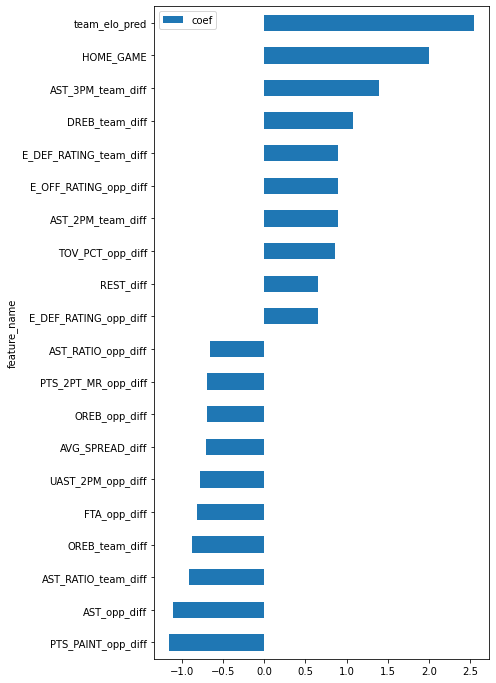

In [64]:
ridge_alpha = study_lr.best_params['alpha']
print(ridge_alpha)
best_ridge = Pipeline([('scaler', StandardScaler()),
                    ('ridge', Ridge(solver='auto', alpha=ridge_alpha))])

best_ridge.fit(X_train, y_train)

print(best_ridge)

ridge_train_preds = best_ridge.predict(X_train)
ridge_test_preds = best_ridge.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, ridge_train_preds))
print("test_MAE:", mean_absolute_error(y_test, ridge_test_preds))

view_model_coefs(best_ridge.named_steps['ridge'], X_train)

In [50]:
best_ridge.named_steps['ridge'].coef_

array([-0.35292563,  0.46763639, -0.47774118, -0.0902894 ,  0.09683553,
       -0.12825914,  0.52593521, -0.87944452,  1.07647269,  0.27326345,
       -0.15692138,  0.2721207 , -0.1105825 , -0.15490134,  0.39064182,
        0.24481831,  0.17853364,  0.64839414,  0.89913266, -0.12992774,
       -0.41567262,  0.23478535,  0.19909935,  0.1601896 ,  0.21403452,
        0.20968259,  0.89594586,  1.39845434, -0.13968914, -0.03562816,
       -0.38366559,  0.35292563,  0.24252144,  0.5849811 , -0.00904726,
       -0.58981958, -0.30401183, -0.81035431, -0.69790838,  0.32750959,
       -0.10354955, -1.11019673,  0.40279892, -0.06618391,  0.25955094,
       -0.26669946,  0.05204596, -0.17853364,  0.89913266,  0.64839414,
        0.12992774,  0.21978157, -0.25658065, -0.68831296, -0.50578877,
        0.11036282, -1.14912211,  0.42964253, -0.12620014, -0.78148886,
       -0.19466199,  0.38366559,  0.1652787 , -0.07112043,  0.39051261,
       -0.7001672 , -0.2839335 , -0.19562457,  0.65099403,  0.29

### SVC 

In [51]:
# def objective(trial):    
#     svr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
#     svr_loss = trial.suggest_categorical('loss', ['epsilon_insensitive', 'squared_epsilon_insensitive'])
    
#     classifier_obj = Pipeline(steps=[('scaler', StandardScaler()),
#                 ('svc', LinearSVR(C = svr_C,
#                                 loss=svr_loss,
#                                max_iter=100000,
#                                      random_state=23))])
    
#     score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
#                            cv=tscv, scoring='neg_mean_absolute_error')
    
    
#     score_avg = score.mean()
    
#     return score_avg

# study_name = 'study_svr'
# storage_name = "sqlite:///{}.db".format(study_name)

# study_svc_acc = optuna.create_study(study_name = study_name, direction='maximize', 
#                                storage = storage_name, load_if_exists=True)

# study_svc_acc.optimize(objective, n_trials=1)

In [52]:
# svr_C = study_svr.best_params['C']
# svr_loss = study_svr.best_params['loss']

# print('C:', svc_C)
# best_svr = Pipeline(steps=[('scaler', StandardScaler()),
#                 ('svc', LinearSVR(C = svr_C,
#                                   loss=svr_loss,
#                                max_iter=100000,
#                                      random_state=23))])
    

# best_svr.fit(X_train, y_train)

# svr_train_preds = best_svr.predict(X_train)
# svr_test_preds = best_svr.predict(X_test)

# print("train_MAE:", mean_absolute_error(y_train, svr_train_preds))
# print("test_MAE:", mean_absolute_error(y_test, svr_test_preds))


In [53]:
# svc_pipe_rbf = Pipeline(steps=[('scaler', StandardScaler()),
#                 ('svc', SVC(random_state=23, probability=True))])



# params = {
#     'svc__C': np.logspace(-3,1,100)
# }

# svc_rbf_cv = GridSearchCV(svc_pipe_rbf, param_grid=params, scoring='roc_auc', cv=tscv, n_jobs=-1, verbose=1)


# svc_rbf_cv.fit(X_train, y_train)

# best_svc_rbf = svc_rbf_cv.best_estimator_
# print("best_svc_rbf:", best_svc_rbf)


# print("train_score:", best_svc_rbf.score(X_train, y_train))
# print("test_score:", best_svc_rbf.score(X_test, y_test))

### SGD Hinge

In [54]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-6, 1e2, log=True)
    sgd_loss = trial.suggest_categorical('loss', ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'])
    sgd_epsilon = trial.suggest_float('epsilon', 1e-4, 1, log=True)
    sgd_penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    
    reg_obj = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDRegressor(alpha = sgd_alpha,
                                      loss=sgd_loss,
                                     epsilon = sgd_epsilon,
                                     penalty = sgd_penalty,
                               max_iter=10000,
                                     random_state=23,
                                    shuffle=False))])
    
    score = cross_val_score(reg_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='neg_mean_absolute_error')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_sgd_regressor'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=400)

[I 2021-10-30 15:55:56,017] A new study created in RDB with name: study_sgd_regressor
[I 2021-10-30 15:55:56,671] Trial 0 finished with value: -9.359121744081161 and parameters: {'alpha': 2.5866513910149244e-05, 'loss': 'epsilon_insensitive', 'epsilon': 0.5902653772280582, 'penalty': 'l2'}. Best is trial 0 with value: -9.359121744081161.
[I 2021-10-30 15:55:57,391] Trial 1 finished with value: -9.34504454045074 and parameters: {'alpha': 0.012112869335888066, 'loss': 'epsilon_insensitive', 'epsilon': 0.019020897996174603, 'penalty': 'l1'}. Best is trial 1 with value: -9.34504454045074.
[I 2021-10-30 15:55:58,104] Trial 2 finished with value: -9.877628767046147 and parameters: {'alpha': 0.015344584264863738, 'loss': 'squared_epsilon_insensitive', 'epsilon': 0.2438385890462337, 'penalty': 'l1'}. Best is trial 1 with value: -9.34504454045074.
[I 2021-10-30 15:55:58,812] Trial 3 finished with value: -9.34749252696333 and parameters: {'alpha': 0.022066591896479998, 'loss': 'epsilon_insensiti

[I 2021-10-30 15:56:19,919] Trial 31 finished with value: -9.346709816067925 and parameters: {'alpha': 0.020751370021794644, 'loss': 'epsilon_insensitive', 'epsilon': 0.00035198491701920575, 'penalty': 'elasticnet'}. Best is trial 11 with value: -9.345041651884234.
[I 2021-10-30 15:56:20,660] Trial 32 finished with value: -9.348090675178893 and parameters: {'alpha': 0.0092897379217073, 'loss': 'epsilon_insensitive', 'epsilon': 0.00015881021682760639, 'penalty': 'elasticnet'}. Best is trial 11 with value: -9.345041651884234.
[I 2021-10-30 15:56:21,360] Trial 33 finished with value: -9.347109121341175 and parameters: {'alpha': 0.022187263889153912, 'loss': 'epsilon_insensitive', 'epsilon': 0.0003659940554766953, 'penalty': 'elasticnet'}. Best is trial 11 with value: -9.345041651884234.
[I 2021-10-30 15:56:22,010] Trial 34 finished with value: -9.608520790165874 and parameters: {'alpha': 0.20488654314766216, 'loss': 'epsilon_insensitive', 'epsilon': 0.0005068068800776086, 'penalty': 'elas

[I 2021-10-30 15:56:41,777] Trial 61 finished with value: -9.345660792306056 and parameters: {'alpha': 0.011205148068430206, 'loss': 'epsilon_insensitive', 'epsilon': 0.021777642988328325, 'penalty': 'l1'}. Best is trial 11 with value: -9.345041651884234.
[I 2021-10-30 15:56:42,512] Trial 62 finished with value: -9.346241253453044 and parameters: {'alpha': 0.008904154645446923, 'loss': 'epsilon_insensitive', 'epsilon': 0.019031076156110424, 'penalty': 'l1'}. Best is trial 11 with value: -9.345041651884234.
[I 2021-10-30 15:56:43,226] Trial 63 finished with value: -9.345458869912642 and parameters: {'alpha': 0.011923055491842163, 'loss': 'epsilon_insensitive', 'epsilon': 0.01815988453039005, 'penalty': 'l1'}. Best is trial 11 with value: -9.345041651884234.
[I 2021-10-30 15:56:44,067] Trial 64 finished with value: -9.346264749634742 and parameters: {'alpha': 0.00998689382135183, 'loss': 'epsilon_insensitive', 'epsilon': 0.02179357424017157, 'penalty': 'l1'}. Best is trial 11 with value:

[I 2021-10-30 15:57:05,719] Trial 92 finished with value: -9.346197343275557 and parameters: {'alpha': 0.010831713397355018, 'loss': 'epsilon_insensitive', 'epsilon': 0.05412543705227184, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:57:06,558] Trial 93 finished with value: -9.352274424264934 and parameters: {'alpha': 0.0016808914486156558, 'loss': 'epsilon_insensitive', 'epsilon': 0.0171017058085805, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:57:07,269] Trial 94 finished with value: -9.347033902665332 and parameters: {'alpha': 0.0054495889002607436, 'loss': 'epsilon_insensitive', 'epsilon': 0.012126401460537548, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:57:07,853] Trial 95 finished with value: -9.358988320057586 and parameters: {'alpha': 0.034323832360499844, 'loss': 'epsilon_insensitive', 'epsilon': 0.06282678827702522, 'penalty': 'l2'}. Best is trial 73 with value

[I 2021-10-30 15:57:29,399] Trial 123 finished with value: -9.357134686519675 and parameters: {'alpha': 0.0251955274496505, 'loss': 'epsilon_insensitive', 'epsilon': 0.0030666242371292633, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:57:30,178] Trial 124 finished with value: -9.348034045159489 and parameters: {'alpha': 0.004970271939751899, 'loss': 'epsilon_insensitive', 'epsilon': 0.004417452747158836, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:57:31,027] Trial 125 finished with value: -9.357372352959032 and parameters: {'alpha': 1.6584768210269003e-06, 'loss': 'epsilon_insensitive', 'epsilon': 0.008767333873568386, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:57:32,404] Trial 126 finished with value: -9.963796982196365 and parameters: {'alpha': 0.0010524496721118432, 'loss': 'squared_epsilon_insensitive', 'epsilon': 0.0022873255892734623, 'penalty': 'l1'}. Best is tr

[I 2021-10-30 15:57:53,748] Trial 154 finished with value: -9.344740705934075 and parameters: {'alpha': 0.012519825352231097, 'loss': 'epsilon_insensitive', 'epsilon': 0.001864472759532817, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:57:54,575] Trial 155 finished with value: -9.345644258312294 and parameters: {'alpha': 0.012601726082194224, 'loss': 'epsilon_insensitive', 'epsilon': 0.0022557526196896847, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:57:55,400] Trial 156 finished with value: -9.353509697546542 and parameters: {'alpha': 0.02230807584174266, 'loss': 'epsilon_insensitive', 'epsilon': 0.0058407923083021104, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:57:56,037] Trial 157 finished with value: -9.890333805286787 and parameters: {'alpha': 0.014989669949773944, 'loss': 'squared_epsilon_insensitive', 'epsilon': 0.002601955684954323, 'penalty': 'l1'}. Best is tria

[I 2021-10-30 15:58:17,375] Trial 185 finished with value: -9.34469562799772 and parameters: {'alpha': 0.013676299531549467, 'loss': 'epsilon_insensitive', 'epsilon': 0.002865058569428811, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:58:18,088] Trial 186 finished with value: -9.347038861421087 and parameters: {'alpha': 0.016332309829181282, 'loss': 'epsilon_insensitive', 'epsilon': 0.00018432731517431446, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:58:18,915] Trial 187 finished with value: -9.344984592960587 and parameters: {'alpha': 0.011763933914894473, 'loss': 'epsilon_insensitive', 'epsilon': 0.0015126439799402138, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:58:19,662] Trial 188 finished with value: -9.355881895733354 and parameters: {'alpha': 0.024544985174745265, 'loss': 'epsilon_insensitive', 'epsilon': 0.0015274840545702823, 'penalty': 'l1'}. Best is trial 73 w

[I 2021-10-30 15:58:41,657] Trial 216 finished with value: -9.497473827621429 and parameters: {'alpha': 0.01976332840252704, 'loss': 'squared_error', 'epsilon': 0.0014534079536917136, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:58:42,418] Trial 217 finished with value: -9.34813962940682 and parameters: {'alpha': 0.004845574284126877, 'loss': 'epsilon_insensitive', 'epsilon': 0.004606989110210792, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:58:43,148] Trial 218 finished with value: -9.345942155275786 and parameters: {'alpha': 0.011025034006789702, 'loss': 'epsilon_insensitive', 'epsilon': 0.003662307392112566, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:58:43,977] Trial 219 finished with value: -9.345858617284124 and parameters: {'alpha': 0.00716405862520326, 'loss': 'epsilon_insensitive', 'epsilon': 0.0060590357071292076, 'penalty': 'l1'}. Best is trial 73 with value:

[I 2021-10-30 15:59:05,834] Trial 247 finished with value: -9.349071376412784 and parameters: {'alpha': 0.00512813757760937, 'loss': 'epsilon_insensitive', 'epsilon': 0.0020759246472061956, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:59:06,555] Trial 248 finished with value: -10.953094847021841 and parameters: {'alpha': 0.007968953677649214, 'loss': 'huber', 'epsilon': 0.007251548037159333, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:59:07,331] Trial 249 finished with value: -9.356123239404685 and parameters: {'alpha': 0.024924705870949502, 'loss': 'epsilon_insensitive', 'epsilon': 0.00010650305371188828, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:59:08,167] Trial 250 finished with value: -9.345279286950175 and parameters: {'alpha': 0.011010584420477091, 'loss': 'epsilon_insensitive', 'epsilon': 0.003381751240086286, 'penalty': 'l1'}. Best is trial 73 with value: -9.

[I 2021-10-30 15:59:30,117] Trial 278 finished with value: -9.599978011261763 and parameters: {'alpha': 0.00669335084236149, 'loss': 'squared_error', 'epsilon': 0.020038374115716566, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:59:30,900] Trial 279 finished with value: -9.345815165617699 and parameters: {'alpha': 0.01455591756079469, 'loss': 'epsilon_insensitive', 'epsilon': 0.00091361622158571, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:59:31,632] Trial 280 finished with value: -9.345700534557645 and parameters: {'alpha': 0.009786796288832101, 'loss': 'epsilon_insensitive', 'epsilon': 0.00401424910638822, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:59:32,369] Trial 281 finished with value: -9.366435796337115 and parameters: {'alpha': 0.031877119483750035, 'loss': 'epsilon_insensitive', 'epsilon': 0.012982648133766922, 'penalty': 'l1'}. Best is trial 73 with value: -9

[I 2021-10-30 15:59:54,345] Trial 309 finished with value: -9.369824604955255 and parameters: {'alpha': 0.032954833888094635, 'loss': 'epsilon_insensitive', 'epsilon': 0.003821055889470482, 'penalty': 'l1'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:59:54,966] Trial 310 finished with value: -9.351569800221085 and parameters: {'alpha': 0.00847486969247788, 'loss': 'epsilon_insensitive', 'epsilon': 0.0020131333902583194, 'penalty': 'l2'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:59:55,710] Trial 311 finished with value: -9.347672961292819 and parameters: {'alpha': 0.023578465578980117, 'loss': 'epsilon_insensitive', 'epsilon': 0.004401617759613563, 'penalty': 'elasticnet'}. Best is trial 73 with value: -9.344684902679756.
[I 2021-10-30 15:59:56,473] Trial 312 finished with value: -9.345943531444096 and parameters: {'alpha': 0.014979464688644337, 'loss': 'epsilon_insensitive', 'epsilon': 0.006148710919802617, 'penalty': 'l1'}. Best is trial

[I 2021-10-30 16:00:19,307] Trial 340 finished with value: -10.953096837611586 and parameters: {'alpha': 8.421917030020177, 'loss': 'epsilon_insensitive', 'epsilon': 0.0059534388482788405, 'penalty': 'l1'}. Best is trial 326 with value: -9.343967708856947.
[I 2021-10-30 16:00:20,143] Trial 341 finished with value: -9.362070177643805 and parameters: {'alpha': 0.02866010014625872, 'loss': 'epsilon_insensitive', 'epsilon': 0.1610414669722779, 'penalty': 'l1'}. Best is trial 326 with value: -9.343967708856947.
[I 2021-10-30 16:00:20,907] Trial 342 finished with value: -9.345645778875651 and parameters: {'alpha': 0.013078214077715972, 'loss': 'epsilon_insensitive', 'epsilon': 0.007992246926590951, 'penalty': 'l1'}. Best is trial 326 with value: -9.343967708856947.
[I 2021-10-30 16:00:21,646] Trial 343 finished with value: -9.345387646749224 and parameters: {'alpha': 0.009069893529072018, 'loss': 'epsilon_insensitive', 'epsilon': 0.3241849991333188, 'penalty': 'l1'}. Best is trial 326 with v

[I 2021-10-30 16:00:43,675] Trial 371 finished with value: -9.345973988075084 and parameters: {'alpha': 0.0072744532698171445, 'loss': 'epsilon_insensitive', 'epsilon': 0.0073454894485289884, 'penalty': 'l1'}. Best is trial 326 with value: -9.343967708856947.
[I 2021-10-30 16:00:44,319] Trial 372 finished with value: -10.953094850759623 and parameters: {'alpha': 0.009529512804250172, 'loss': 'huber', 'epsilon': 0.009115658187422623, 'penalty': 'l1'}. Best is trial 326 with value: -9.343967708856947.
[I 2021-10-30 16:00:45,188] Trial 373 finished with value: -9.348387581282946 and parameters: {'alpha': 0.00541121519708924, 'loss': 'epsilon_insensitive', 'epsilon': 0.013371144181630214, 'penalty': 'l1'}. Best is trial 326 with value: -9.343967708856947.
[I 2021-10-30 16:00:46,024] Trial 374 finished with value: -9.345957732635032 and parameters: {'alpha': 0.007368426985927861, 'loss': 'epsilon_insensitive', 'epsilon': 0.007027809320640703, 'penalty': 'l1'}. Best is trial 326 with value: 

best_sgd: Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDRegressor(alpha=0.009864457997346513,
                              epsilon=0.005661054765240957,
                              loss='epsilon_insensitive', max_iter=10000,
                              penalty='l1', random_state=23, shuffle=False))])
train_MAE: 9.35888231835182
test_MAE: 10.258093413606046


feature_name      coef
65         AVG_SPREAD_diff -1.057818
54         PTS_FB_opp_diff -0.397757
66             AVG_ML_diff -0.211049
56      PTS_PAINT_opp_diff -0.209350
35           FG3A_opp_diff -0.178386
57        AST_2PM_opp_diff -0.176936
80      AST_RATIO_opp_diff -0.156563
74        REB_PCT_opp_diff -0.156348
70       OREB_PCT_opp_diff -0.141713
30      ATS_DIFF_team_diff -0.089636
29      UAST_3PM_team_diff -0.085472
85            opp_rating_i -0.016589
40            REB_opp_diff -0.011408
84           team_rating_i  0.015847
4           FG3A_team_diff  0.035131
23        PTS_FB_team_diff  0.035841
53     PTS_2PT_MR_opp_diff  0.038989
75        TS_PCT_team_diff  0.049764
61       ATS_DIFF_opp_diff  0.089636
42            STL_opp_diff  0.098324
62   TEAM_COVERED_opp_diff  0.137506
71      DREB_PCT_team_diff  0.141713
73       REB_PCT_team_diff  0.156348
11           STL_team_diff  0.220812
24   PTS_OFF_TOV_team_diff  0.288750
49   E_DEF_RATING_opp_diff  0.320738
17  E_OFF_RATING_team_diff  0.320738
27       AST_3PM_team_diff  0.387269
68               REST_diff  0.497425
86            elo_MOV_pred  0.774632
87               HOME_GAME  1.845750
83           team_elo_pred  2.755601

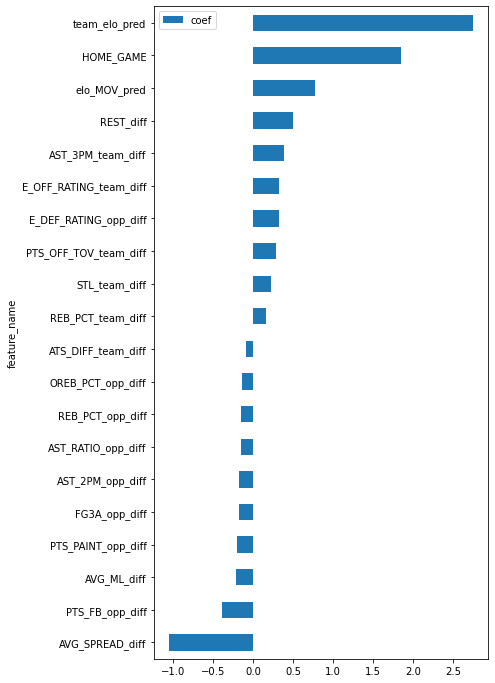

In [55]:
sgd_alpha = study_sgd.best_params['alpha']
sgd_loss = study_sgd.best_params['loss']
sgd_epsilon = study_sgd.best_params['epsilon']
sgd_penalty = study_sgd.best_params['penalty']

best_sgd = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDRegressor(alpha = sgd_alpha,
                                      loss=sgd_loss,
                                     epsilon = sgd_epsilon,
                                     penalty = sgd_penalty,
                               max_iter=10000,
                                     random_state=23,
                                    shuffle=False))])

print("best_sgd:", best_sgd)

best_sgd.fit(X_train, y_train)

sgd_train_preds = best_sgd.predict(X_train)
sgd_test_preds = best_sgd.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, sgd_train_preds))
print("test_MAE:", mean_absolute_error(y_test, sgd_test_preds))

view_model_coefs(best_sgd.named_steps['sgd'], X_train)

### LGBClassifier

In [56]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    reg_obj = lgb.LGBMRegressor(colsample_bytree=colsample_bytree,
                                        max_depth=max_depth,
                                        min_child_weight=min_child_weight,
                                        num_leaves=num_leaves, 
                                        random_state=23,
                                        reg_alpha=reg_alpha, 
                                        reg_lambda=reg_lambda,
                                       learning_rate=learning_rate)
    
    score = cross_val_score(reg_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='neg_mean_absolute_error')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_lgbr'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbr.optimize(objective, n_trials=400, show_progress_bar=True)

[I 2021-10-30 16:01:06,699] A new study created in RDB with name: study_lgbr
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/400 [00:00<?, ?it/s]

[I 2021-10-30 16:01:13,714] Trial 0 finished with value: -10.88091711041039 and parameters: {'min_child_weight': 0.5389512150097532, 'subsample': 0.897041914577412, 'max_depth': 29, 'reg_lambda': 6.022747230542153, 'reg_alpha': 4.318543605317992, 'num_leaves': 428, 'colsample_bytree': 0.31384570763179676, 'learning_rate': 0.00036476193601290836}. Best is trial 0 with value: -10.88091711041039.
[I 2021-10-30 16:01:21,854] Trial 1 finished with value: -10.924890894707602 and parameters: {'min_child_weight': 0.8187865464500752, 'subsample': 0.8229777376199574, 'max_depth': 19, 'reg_lambda': 4.720685925755932, 'reg_alpha': 2.4336882893504734, 'num_leaves': 119, 'colsample_bytree': 0.6828168951040464, 'learning_rate': 0.00011904448611401048}. Best is trial 0 with value: -10.88091711041039.
[I 2021-10-30 16:01:28,023] Trial 2 finished with value: -9.580842713191219 and parameters: {'min_child_weight': 0.8802832304335098, 'subsample': 0.6775193460377409, 'max_depth': 32, 'reg_lambda': 8.16134

[I 2021-10-30 16:03:40,596] Trial 21 finished with value: -9.506752743264459 and parameters: {'min_child_weight': 0.1625031913808109, 'subsample': 0.7771216410620576, 'max_depth': 25, 'reg_lambda': 2.5842259282312683, 'reg_alpha': 0.6221253074523329, 'num_leaves': 407, 'colsample_bytree': 0.45942844074860056, 'learning_rate': 0.027037949255070394}. Best is trial 18 with value: -9.429420342093568.
[I 2021-10-30 16:03:53,410] Trial 22 finished with value: -10.057076000771428 and parameters: {'min_child_weight': 0.015157432688602701, 'subsample': 0.7138699592734874, 'max_depth': 20, 'reg_lambda': 3.5132647946668536, 'reg_alpha': 1.5427202404249207, 'num_leaves': 382, 'colsample_bytree': 0.5824121646890043, 'learning_rate': 0.005610377837656606}. Best is trial 18 with value: -9.429420342093568.
[I 2021-10-30 16:04:03,169] Trial 23 finished with value: -9.495423086496874 and parameters: {'min_child_weight': 0.12241769080175238, 'subsample': 0.6535061160471762, 'max_depth': 15, 'reg_lambda':

[I 2021-10-30 16:06:17,740] Trial 41 finished with value: -9.467687415626168 and parameters: {'min_child_weight': 0.7555438756804942, 'subsample': 0.8307940729282374, 'max_depth': 18, 'reg_lambda': 5.1164200290391, 'reg_alpha': 0.9919423079171378, 'num_leaves': 142, 'colsample_bytree': 0.5224859564756232, 'learning_rate': 0.031712131372856875}. Best is trial 18 with value: -9.429420342093568.
[I 2021-10-30 16:06:23,098] Trial 42 finished with value: -9.589530849466062 and parameters: {'min_child_weight': 0.7328622706730854, 'subsample': 0.8625753020467642, 'max_depth': 19, 'reg_lambda': 4.944032575596096, 'reg_alpha': 1.4158855566756612, 'num_leaves': 86, 'colsample_bytree': 0.4999046459748175, 'learning_rate': 0.013281081046975967}. Best is trial 18 with value: -9.429420342093568.
[I 2021-10-30 16:06:27,687] Trial 43 finished with value: -9.899726995236382 and parameters: {'min_child_weight': 0.8133014299594628, 'subsample': 0.8351206444736078, 'max_depth': 7, 'reg_lambda': 7.31512888

[I 2021-10-30 16:07:15,738] Trial 62 finished with value: -9.450427355802471 and parameters: {'min_child_weight': 0.9072717154498444, 'subsample': 0.6793666220062773, 'max_depth': 4, 'reg_lambda': 6.100064656995392, 'reg_alpha': 3.806729740329222, 'num_leaves': 133, 'colsample_bytree': 0.6970863373223468, 'learning_rate': 0.10938697834913728}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:07:18,760] Trial 63 finished with value: -9.810708419078 and parameters: {'min_child_weight': 0.8005689483349088, 'subsample': 0.7360796353757556, 'max_depth': 6, 'reg_lambda': 6.680748852822536, 'reg_alpha': 3.4545634193971893, 'num_leaves': 103, 'colsample_bytree': 0.6404151748340295, 'learning_rate': 0.23591467605031693}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:07:21,093] Trial 64 finished with value: -9.396307042928436 and parameters: {'min_child_weight': 0.8603562155597525, 'subsample': 0.7093906894163704, 'max_depth': 4, 'reg_lambda': 6.0125298494909

[I 2021-10-30 16:08:09,613] Trial 83 finished with value: -9.671204530020404 and parameters: {'min_child_weight': 0.7359454179036478, 'subsample': 0.6956279701476332, 'max_depth': 3, 'reg_lambda': 8.430347645154049, 'reg_alpha': 4.51718253304824, 'num_leaves': 2, 'colsample_bytree': 0.7595421205164723, 'learning_rate': 0.02092444941627951}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:08:11,877] Trial 84 finished with value: -9.391701357857112 and parameters: {'min_child_weight': 0.8306866160923011, 'subsample': 0.7272437079080877, 'max_depth': 4, 'reg_lambda': 9.727201910666494, 'reg_alpha': 4.258305722988817, 'num_leaves': 38, 'colsample_bytree': 0.8213193359193638, 'learning_rate': 0.04560174794970786}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:08:14,426] Trial 85 finished with value: -9.717522754276386 and parameters: {'min_child_weight': 0.6905930616663873, 'subsample': 0.7495433743805144, 'max_depth': 6, 'reg_lambda': 8.818596697480611

[I 2021-10-30 16:09:01,997] Trial 104 finished with value: -9.397192115140143 and parameters: {'min_child_weight': 0.8652796925846856, 'subsample': 0.7186366103989992, 'max_depth': 5, 'reg_lambda': 9.13075752808915, 'reg_alpha': 4.2110626040046135, 'num_leaves': 53, 'colsample_bytree': 0.7114423994027663, 'learning_rate': 0.04026489492659264}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:09:03,653] Trial 105 finished with value: -9.40751799875271 and parameters: {'min_child_weight': 0.6726083976369733, 'subsample': 0.7311895595052814, 'max_depth': 3, 'reg_lambda': 8.924784419971045, 'reg_alpha': 4.931706448356931, 'num_leaves': 74, 'colsample_bytree': 0.7518104877811327, 'learning_rate': 0.12068307400886892}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:09:06,415] Trial 106 finished with value: -9.424433392851368 and parameters: {'min_child_weight': 0.7507916040401875, 'subsample': 0.6890916667352283, 'max_depth': 6, 'reg_lambda': 9.34322352799

[I 2021-10-30 16:09:44,854] Trial 125 finished with value: -9.373388542178207 and parameters: {'min_child_weight': 0.5423118457814994, 'subsample': 0.7303637227950817, 'max_depth': 3, 'reg_lambda': 9.245596145914165, 'reg_alpha': 3.8699754994090894, 'num_leaves': 55, 'colsample_bytree': 0.8182423962782674, 'learning_rate': 0.07171603937566635}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:09:48,438] Trial 126 finished with value: -9.48558357350186 and parameters: {'min_child_weight': 0.5521452943496312, 'subsample': 0.7299055910769315, 'max_depth': 6, 'reg_lambda': 9.32509070708737, 'reg_alpha': 3.8528061324482468, 'num_leaves': 60, 'colsample_bytree': 0.8184697133762205, 'learning_rate': 0.07267489183633011}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:09:50,276] Trial 127 finished with value: -9.368171146073038 and parameters: {'min_child_weight': 0.5804826383253653, 'subsample': 0.7000147028978091, 'max_depth': 3, 'reg_lambda': 9.7932600033

[I 2021-10-30 16:10:32,459] Trial 146 finished with value: -9.416568656004 and parameters: {'min_child_weight': 0.5809672508177355, 'subsample': 0.6304190822045301, 'max_depth': 6, 'reg_lambda': 9.539463237866393, 'reg_alpha': 3.015846905053432, 'num_leaves': 20, 'colsample_bytree': 0.7442949786202261, 'learning_rate': 0.06944732587493511}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:10:34,082] Trial 147 finished with value: -9.411232054817072 and parameters: {'min_child_weight': 0.5381975316116256, 'subsample': 0.6619238014785219, 'max_depth': 5, 'reg_lambda': 9.68890523798651, 'reg_alpha': 1.6218476717269437, 'num_leaves': 4, 'colsample_bytree': 0.7568704910973765, 'learning_rate': 0.032465833460698035}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:10:36,273] Trial 148 finished with value: -9.389473977577605 and parameters: {'min_child_weight': 0.5998274943663683, 'subsample': 0.6312326227572657, 'max_depth': 4, 'reg_lambda': 9.4234419997330

[I 2021-10-30 16:11:18,730] Trial 167 finished with value: -9.411694769206647 and parameters: {'min_child_weight': 0.5468887006563806, 'subsample': 0.6877429819420193, 'max_depth': 5, 'reg_lambda': 9.0313795858211, 'reg_alpha': 3.263093522941948, 'num_leaves': 22, 'colsample_bytree': 0.7905571114612652, 'learning_rate': 0.05781381883597033}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:11:20,172] Trial 168 finished with value: -9.42796391542765 and parameters: {'min_child_weight': 0.26968403274076946, 'subsample': 0.6589642816157192, 'max_depth': 4, 'reg_lambda': 8.630707499389985, 'reg_alpha': 2.878888992702103, 'num_leaves': 3, 'colsample_bytree': 0.8092717075515338, 'learning_rate': 0.03577537493017025}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:11:21,900] Trial 169 finished with value: -9.368819478353092 and parameters: {'min_child_weight': 0.6266683325670799, 'subsample': 0.6749714759946083, 'max_depth': 3, 'reg_lambda': 9.3972694523447

[I 2021-10-30 16:12:10,047] Trial 188 finished with value: -9.910650146819858 and parameters: {'min_child_weight': 0.636935786185907, 'subsample': 0.665162158767732, 'max_depth': 3, 'reg_lambda': 8.780888779861074, 'reg_alpha': 2.6185270502890186, 'num_leaves': 42, 'colsample_bytree': 0.7750353941043082, 'learning_rate': 0.006974811229353775}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:12:12,204] Trial 189 finished with value: -9.426499696171456 and parameters: {'min_child_weight': 0.6477933028581555, 'subsample': 0.7047053509548348, 'max_depth': 4, 'reg_lambda': 9.801310813954881, 'reg_alpha': 1.4246636428228323, 'num_leaves': 145, 'colsample_bytree': 0.7135438172144596, 'learning_rate': 0.022778887414734432}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:12:14,700] Trial 190 finished with value: -9.406685219783313 and parameters: {'min_child_weight': 0.04242788867332653, 'subsample': 0.6979415490331339, 'max_depth': 5, 'reg_lambda': 9.586389

[I 2021-10-30 16:12:53,194] Trial 209 finished with value: -9.398338427647623 and parameters: {'min_child_weight': 0.5240154029591729, 'subsample': 0.9799748335358108, 'max_depth': 4, 'reg_lambda': 8.968598701687704, 'reg_alpha': 2.557218614343409, 'num_leaves': 28, 'colsample_bytree': 0.6766168743425005, 'learning_rate': 0.0788387791530359}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:12:54,873] Trial 210 finished with value: -9.367033022023488 and parameters: {'min_child_weight': 0.42259342131598804, 'subsample': 0.7580993574221342, 'max_depth': 3, 'reg_lambda': 9.256278472704416, 'reg_alpha': 2.4076622142510717, 'num_leaves': 169, 'colsample_bytree': 0.7194479585868591, 'learning_rate': 0.06045666825360387}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:12:56,538] Trial 211 finished with value: -9.369953566995857 and parameters: {'min_child_weight': 0.45751479215307844, 'subsample': 0.7575790528931763, 'max_depth': 3, 'reg_lambda': 9.2888933

[I 2021-10-30 16:13:31,845] Trial 230 finished with value: -9.393705771520938 and parameters: {'min_child_weight': 0.2330860596104084, 'subsample': 0.6577031279879517, 'max_depth': 27, 'reg_lambda': 9.855854953951589, 'reg_alpha': 2.48415219185611, 'num_leaves': 3, 'colsample_bytree': 0.7149276024608257, 'learning_rate': 0.049916316839764704}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:13:33,570] Trial 231 finished with value: -9.365629565586818 and parameters: {'min_child_weight': 0.5897697473270489, 'subsample': 0.7137689534653415, 'max_depth': 3, 'reg_lambda': 9.60268965691658, 'reg_alpha': 2.2759953891361, 'num_leaves': 27, 'colsample_bytree': 0.7331384034612372, 'learning_rate': 0.058716460760099315}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:13:35,314] Trial 232 finished with value: -9.366592583243975 and parameters: {'min_child_weight': 0.28564547200526813, 'subsample': 0.7141080199948843, 'max_depth': 3, 'reg_lambda': 9.61910197175

[I 2021-10-30 16:14:09,534] Trial 251 finished with value: -9.409336922369462 and parameters: {'min_child_weight': 0.21871563310558537, 'subsample': 0.7024456724555158, 'max_depth': 4, 'reg_lambda': 9.27545213272301, 'reg_alpha': 2.391379568036634, 'num_leaves': 38, 'colsample_bytree': 0.6913496171435015, 'learning_rate': 0.07844315796993978}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:14:11,271] Trial 252 finished with value: -9.369212790928588 and parameters: {'min_child_weight': 0.22768857496966227, 'subsample': 0.7076660093361052, 'max_depth': 3, 'reg_lambda': 9.45054204985767, 'reg_alpha': 2.1937397310760085, 'num_leaves': 22, 'colsample_bytree': 0.7142274671898426, 'learning_rate': 0.06800554925236828}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:14:13,317] Trial 253 finished with value: -9.420825283481369 and parameters: {'min_child_weight': 0.23875391663084722, 'subsample': 0.6965705039052864, 'max_depth': 4, 'reg_lambda': 9.28448851

[I 2021-10-30 16:14:51,509] Trial 272 finished with value: -9.364221684929252 and parameters: {'min_child_weight': 0.17123766992757053, 'subsample': 0.9686751318417958, 'max_depth': 3, 'reg_lambda': 9.613400161577397, 'reg_alpha': 2.373387967359852, 'num_leaves': 192, 'colsample_bytree': 0.6921647853936381, 'learning_rate': 0.05514774229915016}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:14:53,409] Trial 273 finished with value: -9.381409949292436 and parameters: {'min_child_weight': 0.10604531827161284, 'subsample': 0.9705532464417862, 'max_depth': 4, 'reg_lambda': 9.68014569167505, 'reg_alpha': 2.540052528235735, 'num_leaves': 185, 'colsample_bytree': 0.49721738012522343, 'learning_rate': 0.05419303084788129}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:14:55,162] Trial 274 finished with value: -9.36192140861694 and parameters: {'min_child_weight': 0.140464564398256, 'subsample': 0.9541516542264463, 'max_depth': 3, 'reg_lambda': 9.84082920

[I 2021-10-30 16:15:45,522] Trial 292 finished with value: -9.365071739458575 and parameters: {'min_child_weight': 0.04559014729139898, 'subsample': 0.9003849970843354, 'max_depth': 3, 'reg_lambda': 9.831002835800788, 'reg_alpha': 2.938400562684588, 'num_leaves': 195, 'colsample_bytree': 0.678139868943377, 'learning_rate': 0.04672161317045054}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:15:47,198] Trial 293 finished with value: -9.365511333797977 and parameters: {'min_child_weight': 0.05991086744645889, 'subsample': 0.8977714172248333, 'max_depth': 3, 'reg_lambda': 9.86266935684527, 'reg_alpha': 3.1596439625724475, 'num_leaves': 198, 'colsample_bytree': 0.6674818156337864, 'learning_rate': 0.04853891885557317}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:15:49,870] Trial 294 finished with value: -9.399108897877353 and parameters: {'min_child_weight': 0.012249340178855407, 'subsample': 0.895483298871459, 'max_depth': 5, 'reg_lambda': 9.988658

[I 2021-10-30 16:16:31,849] Trial 312 finished with value: -9.368249331196434 and parameters: {'min_child_weight': 0.13534198754230753, 'subsample': 0.9347808959183096, 'max_depth': 3, 'reg_lambda': 9.683041289428711, 'reg_alpha': 2.9929458874947765, 'num_leaves': 174, 'colsample_bytree': 0.6895352189205752, 'learning_rate': 0.04259289005779878}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:16:41,844] Trial 313 finished with value: -9.529046073074621 and parameters: {'min_child_weight': 0.05942919196019495, 'subsample': 0.9237082110352909, 'max_depth': 19, 'reg_lambda': 9.977079763681035, 'reg_alpha': 3.2989661221560316, 'num_leaves': 189, 'colsample_bytree': 0.6907577686501007, 'learning_rate': 0.05191793670358679}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:16:43,260] Trial 314 finished with value: -9.737185676413066 and parameters: {'min_child_weight': 0.08904192907401268, 'subsample': 0.9054982504506986, 'max_depth': 3, 'reg_lambda': 5.50

[I 2021-10-30 16:17:26,197] Trial 332 finished with value: -9.370199138787934 and parameters: {'min_child_weight': 0.00231150696505332, 'subsample': 0.9763507529178391, 'max_depth': 3, 'reg_lambda': 9.987845710835671, 'reg_alpha': 2.9428759066862096, 'num_leaves': 161, 'colsample_bytree': 0.7060352343198782, 'learning_rate': 0.06369916368646449}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:17:28,260] Trial 333 finished with value: -9.382588748866857 and parameters: {'min_child_weight': 0.18247190753895265, 'subsample': 0.9542513037696688, 'max_depth': 4, 'reg_lambda': 6.218077802674212, 'reg_alpha': 3.0264258539491236, 'num_leaves': 207, 'colsample_bytree': 0.6752366129302965, 'learning_rate': 0.04535485433698285}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:17:30,019] Trial 334 finished with value: -10.213738522692811 and parameters: {'min_child_weight': 0.11251058045949344, 'subsample': 0.9455381210582741, 'max_depth': 3, 'reg_lambda': 6.02

[I 2021-10-30 16:18:19,015] Trial 352 finished with value: -9.366346910829428 and parameters: {'min_child_weight': 0.12074504060720095, 'subsample': 0.984781409438214, 'max_depth': 3, 'reg_lambda': 9.846396264609131, 'reg_alpha': 2.6310976043491405, 'num_leaves': 194, 'colsample_bytree': 0.7129525744159498, 'learning_rate': 0.04381956536347187}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:18:20,946] Trial 353 finished with value: -9.3960198539806 and parameters: {'min_child_weight': 0.1392445736101636, 'subsample': 0.9337834859209811, 'max_depth': 4, 'reg_lambda': 6.341961990615011, 'reg_alpha': 2.7670702411848573, 'num_leaves': 209, 'colsample_bytree': 0.6498326753877367, 'learning_rate': 0.05943646020199394}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:18:22,780] Trial 354 finished with value: -9.41646265750085 and parameters: {'min_child_weight': 0.08676091166587485, 'subsample': 0.9533645064106405, 'max_depth': 4, 'reg_lambda': 9.60576076

[I 2021-10-30 16:19:02,525] Trial 372 finished with value: -9.36845611856282 and parameters: {'min_child_weight': 0.10135545878654992, 'subsample': 0.9335273524092816, 'max_depth': 3, 'reg_lambda': 4.833119459715396, 'reg_alpha': 2.836030050980226, 'num_leaves': 160, 'colsample_bytree': 0.7024932730046227, 'learning_rate': 0.05480901028007089}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:19:04,118] Trial 373 finished with value: -9.37318065672404 and parameters: {'min_child_weight': 0.1136533716664256, 'subsample': 0.9451067351916279, 'max_depth': 3, 'reg_lambda': 4.9570667722703465, 'reg_alpha': 2.9563164951571412, 'num_leaves': 172, 'colsample_bytree': 0.6900246237301768, 'learning_rate': 0.07533095413822868}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:19:06,169] Trial 374 finished with value: -9.393590700732801 and parameters: {'min_child_weight': 0.07906483341445852, 'subsample': 0.8738818782758012, 'max_depth': 4, 'reg_lambda': 5.063600

[I 2021-10-30 16:19:45,153] Trial 392 finished with value: -9.38847752966026 and parameters: {'min_child_weight': 0.04965541463069086, 'subsample': 0.9396285885821314, 'max_depth': 4, 'reg_lambda': 9.49154645442042, 'reg_alpha': 3.002158139463965, 'num_leaves': 169, 'colsample_bytree': 0.5669430402108993, 'learning_rate': 0.03187697995206832}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:19:46,761] Trial 393 finished with value: -9.372820238940466 and parameters: {'min_child_weight': 0.13283359225169777, 'subsample': 0.9675719007239, 'max_depth': 3, 'reg_lambda': 9.724036598898465, 'reg_alpha': 2.569304798134264, 'num_leaves': 182, 'colsample_bytree': 0.6579917345409483, 'learning_rate': 0.040545755031813714}. Best is trial 51 with value: -9.360958758606023.
[I 2021-10-30 16:19:48,815] Trial 394 finished with value: -9.396264228715483 and parameters: {'min_child_weight': 0.02777578857301538, 'subsample': 0.9523533044379701, 'max_depth': 4, 'reg_lambda': 9.334825687

best_lgbr: LGBMRegressor(colsample_bytree=0.7141725324185928,
              learning_rate=0.059878907406689344, max_depth=3,
              min_child_weight=0.9347246869665398, num_leaves=62,
              random_state=23, reg_alpha=0.09887326699713585,
              reg_lambda=5.806969286365005, subsample=0.7389924724174181)
train_MAE: 9.24103922389558
test_MAE: 10.276696371624622
LGBoost or XGBoost


feature_name  coef
1           FG2M_team_diff     1
26       AST_2PM_team_diff     1
70       OREB_PCT_opp_diff     1
69      OREB_PCT_team_diff     1
67       AVG_ATS_DIFF_diff     1
25     PTS_PAINT_team_diff     1
12           BLK_team_diff     1
48   E_OFF_RATING_opp_diff     1
10           AST_team_diff     1
5            FTM_team_diff     1
51           POSS_opp_diff     1
82        TOV_PCT_opp_diff     1
71      DREB_PCT_team_diff     1
50   E_NET_RATING_opp_diff     2
62   TEAM_COVERED_opp_diff     2
63             WL_PCT_diff     2
28      UAST_2PM_team_diff     2
59       UAST_2PM_opp_diff     2
55    PTS_OFF_TOV_opp_diff     2
29      UAST_3PM_team_diff     2
58        AST_3PM_opp_diff     2
21           PIE_team_diff     2
2           FG2A_team_diff     2
77       EFG_PCT_team_diff     2
13           TOV_team_diff     2
81       TOV_PCT_team_diff     2
53     PTS_2PT_MR_opp_diff     3
49   E_DEF_RATING_opp_diff     3
61       ATS_DIFF_opp_diff     3
23        PTS_FB_team_diff     3
39           DREB_opp_diff     3
72       DREB_PCT_opp_diff     3
57        AST_2PM_opp_diff     3
36            FTM_opp_diff     3
34           FG3M_opp_diff     3
38           OREB_opp_diff     3
18  E_DEF_RATING_team_diff     3
15           PTS_team_diff     4
64            ATS_PCT_diff     4
45             PF_opp_diff     4
56      PTS_PAINT_opp_diff     4
79     AST_RATIO_team_diff     4
8           DREB_team_diff     4
19  E_NET_RATING_team_diff     4
52            PIE_opp_diff     4
37            FTA_opp_diff     5
60       UAST_3PM_opp_diff     5
85            opp_rating_i     5
84           team_rating_i     6
41            AST_opp_diff     6
47     PLUS_MINUS_opp_diff     7
30      ATS_DIFF_team_diff     7
43            BLK_opp_diff     7
35           FG3A_opp_diff     7
16    PLUS_MINUS_team_diff     7
4           FG3A_team_diff     8
74        REB_PCT_opp_diff     8
14            PF_team_diff     8
42            STL_opp_diff     9
40            REB_opp_diff     9
32           FG2M_opp_diff     9
27       AST_3PM_team_diff    11
22    PTS_2PT_MR_team_diff    11
78        EFG_PCT_opp_diff    14
80      AST_RATIO_opp_diff    14
11           STL_team_diff    14
86            elo_MOV_pred    15
76         TS_PCT_opp_diff    21
17  E_OFF_RATING_team_diff    21
3           FG3M_team_diff    22
24   PTS_OFF_TOV_team_diff    23
73       REB_PCT_team_diff    24
65         AVG_SPREAD_diff    24
54         PTS_FB_opp_diff    35
66             AVG_ML_diff    36
68               REST_diff    40
87               HOME_GAME    49
83           team_elo_pred   108

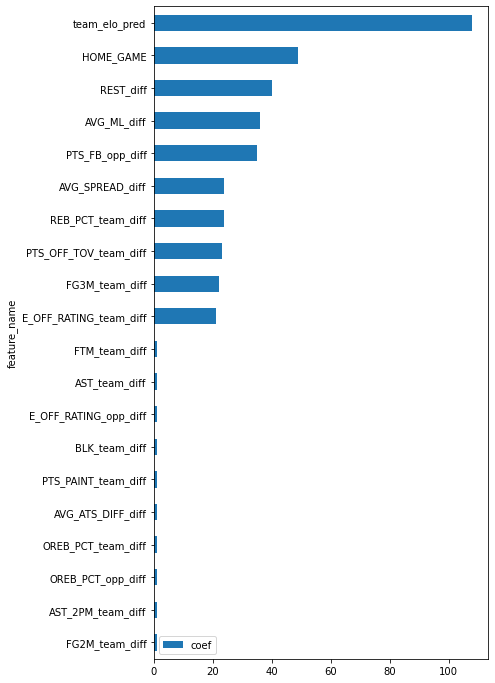

In [57]:
lgbr_params = study_lgbr.best_trial.params
lgbr_params['random_state'] = 23
best_lgbr = lgb.LGBMRegressor()
best_lgbr.set_params(**lgbr_params)
print("best_lgbr:", best_lgbr)

best_lgbr.fit(X_train, y_train)

lgbr_train_preds = best_lgbr.predict(X_train)
lgbr_test_preds = best_lgbr.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, lgbr_train_preds))
print("test_MAE:", mean_absolute_error(y_test, lgbr_test_preds))



view_model_coefs(best_lgbr, X_train)


In [58]:
from sklearn.decomposition import PCA


### KNNeighbors

In [61]:
def objective(trial):    

    n_neighbors = trial.suggest_int('n_neighbors', 1, 52)
    pca__n_components = trial.suggest_int('n_components', 5, 50)
    
    regression_obj = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=pca__n_components)),
                ('knn',
                 KNeighborsRegressor(n_neighbors=n_neighbors))]) 
    
    score = cross_val_score(regression_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='neg_mean_absolute_error')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_knn_reg'
storage_name = "sqlite:///{}.db".format(study_name)

search_space = {'n_neighbors':np.arange(3, 51).tolist(),
               'n_components':np.arange(5, 50, 3).tolist()}

study_knn = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True,
                               sampler = optuna.samplers.GridSampler(search_space))

study_knn.optimize(objective)

[I 2021-10-31 10:24:03,018] A new study created in RDB with name: study_knn_reg
[I 2021-10-31 10:24:07,897] Trial 0 finished with value: -9.670164408750441 and parameters: {'n_neighbors': 42, 'n_components': 38}. Best is trial 0 with value: -9.670164408750441.
[I 2021-10-31 10:24:11,199] Trial 1 finished with value: -9.652243043725155 and parameters: {'n_neighbors': 50, 'n_components': 29}. Best is trial 1 with value: -9.652243043725155.
[I 2021-10-31 10:24:14,606] Trial 2 finished with value: -9.770397501419648 and parameters: {'n_neighbors': 20, 'n_components': 38}. Best is trial 1 with value: -9.652243043725155.
[I 2021-10-31 10:24:18,062] Trial 3 finished with value: -9.66580713437613 and parameters: {'n_neighbors': 44, 'n_components': 26}. Best is trial 1 with value: -9.652243043725155.
[I 2021-10-31 10:24:21,724] Trial 4 finished with value: -9.838816723452583 and parameters: {'n_neighbors': 48, 'n_components': 14}. Best is trial 1 with value: -9.652243043725155.
[I 2021-10-31 10

[I 2021-10-31 10:26:11,799] Trial 42 finished with value: -9.70252697331062 and parameters: {'n_neighbors': 32, 'n_components': 35}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:26:14,862] Trial 43 finished with value: -10.241542954490143 and parameters: {'n_neighbors': 7, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:26:16,765] Trial 44 finished with value: -9.877108177172062 and parameters: {'n_neighbors': 40, 'n_components': 8}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:26:20,155] Trial 45 finished with value: -9.719270082557987 and parameters: {'n_neighbors': 26, 'n_components': 26}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:26:22,562] Trial 46 finished with value: -9.888913296870797 and parameters: {'n_neighbors': 38, 'n_components': 11}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:26:23,561] Trial 47 finished with value: -10.335398275773063 and parameters

[I 2021-10-31 10:28:15,047] Trial 85 finished with value: -10.645925610448609 and parameters: {'n_neighbors': 4, 'n_components': 38}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:28:16,481] Trial 86 finished with value: -9.858903220572726 and parameters: {'n_neighbors': 49, 'n_components': 8}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:28:19,502] Trial 87 finished with value: -9.740621682344516 and parameters: {'n_neighbors': 23, 'n_components': 44}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:28:22,576] Trial 88 finished with value: -9.656867039831265 and parameters: {'n_neighbors': 49, 'n_components': 35}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:28:23,976] Trial 89 finished with value: -9.876170299509312 and parameters: {'n_neighbors': 39, 'n_components': 8}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:28:25,311] Trial 90 finished with value: -9.910606143869868 and parameters:

[I 2021-10-31 10:30:14,070] Trial 127 finished with value: -9.664690774869651 and parameters: {'n_neighbors': 44, 'n_components': 38}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:30:17,180] Trial 128 finished with value: -9.854280238500852 and parameters: {'n_neighbors': 16, 'n_components': 44}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:30:20,452] Trial 129 finished with value: -9.865909521105433 and parameters: {'n_neighbors': 15, 'n_components': 47}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:30:23,350] Trial 130 finished with value: -9.702972387847813 and parameters: {'n_neighbors': 32, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:30:26,378] Trial 131 finished with value: -9.787970849895892 and parameters: {'n_neighbors': 24, 'n_components': 20}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:30:29,431] Trial 132 finished with value: -9.752286923752001 and par

[I 2021-10-31 10:32:19,522] Trial 169 finished with value: -10.711328790459968 and parameters: {'n_neighbors': 4, 'n_components': 17}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:32:20,414] Trial 170 finished with value: -10.020691368540602 and parameters: {'n_neighbors': 32, 'n_components': 5}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:32:23,556] Trial 171 finished with value: -9.65179107418095 and parameters: {'n_neighbors': 49, 'n_components': 47}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:32:24,376] Trial 172 finished with value: -10.295272572402045 and parameters: {'n_neighbors': 12, 'n_components': 5}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:32:27,382] Trial 173 finished with value: -10.018114707552527 and parameters: {'n_neighbors': 10, 'n_components': 26}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:32:30,360] Trial 174 finished with value: -9.6943710959682 and param

[I 2021-10-31 10:34:10,652] Trial 211 finished with value: -9.85329358319137 and parameters: {'n_neighbors': 16, 'n_components': 38}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:34:13,550] Trial 212 finished with value: -9.838831546247118 and parameters: {'n_neighbors': 17, 'n_components': 26}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:34:16,443] Trial 213 finished with value: -10.008419802797997 and parameters: {'n_neighbors': 11, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:34:19,553] Trial 214 finished with value: -9.653996453777424 and parameters: {'n_neighbors': 49, 'n_components': 29}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:34:22,584] Trial 215 finished with value: -9.81456243296107 and parameters: {'n_neighbors': 18, 'n_components': 32}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:34:25,518] Trial 216 finished with value: -9.669508603726742 and para

[I 2021-10-31 10:36:07,180] Trial 253 finished with value: -9.704369175268063 and parameters: {'n_neighbors': 34, 'n_components': 44}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:36:10,398] Trial 254 finished with value: -9.870662186888762 and parameters: {'n_neighbors': 36, 'n_components': 14}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:36:13,503] Trial 255 finished with value: -9.947749549416093 and parameters: {'n_neighbors': 23, 'n_components': 14}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:36:16,548] Trial 256 finished with value: -9.902565156944528 and parameters: {'n_neighbors': 29, 'n_components': 14}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:36:19,453] Trial 257 finished with value: -10.020556501987505 and parameters: {'n_neighbors': 10, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:36:22,359] Trial 258 finished with value: -9.989969542099015 and pa

[I 2021-10-31 10:37:57,977] Trial 295 finished with value: -10.11474405775939 and parameters: {'n_neighbors': 14, 'n_components': 11}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:38:01,090] Trial 296 finished with value: -9.659250942129988 and parameters: {'n_neighbors': 44, 'n_components': 44}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:38:04,281] Trial 297 finished with value: -9.935212000757145 and parameters: {'n_neighbors': 12, 'n_components': 44}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:38:07,349] Trial 298 finished with value: -10.101710675752413 and parameters: {'n_neighbors': 8, 'n_components': 44}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:38:10,568] Trial 299 finished with value: -9.688940558957595 and parameters: {'n_neighbors': 37, 'n_components': 47}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:38:13,518] Trial 300 finished with value: -10.19958627403261 and par

[I 2021-10-31 10:39:49,760] Trial 337 finished with value: -9.767402855520402 and parameters: {'n_neighbors': 28, 'n_components': 20}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:39:52,983] Trial 338 finished with value: -9.700312322544008 and parameters: {'n_neighbors': 32, 'n_components': 44}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:39:55,922] Trial 339 finished with value: -9.950435358697709 and parameters: {'n_neighbors': 12, 'n_components': 17}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:39:56,877] Trial 340 finished with value: -9.977170770739765 and parameters: {'n_neighbors': 44, 'n_components': 5}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:39:59,765] Trial 341 finished with value: -10.44876774559909 and parameters: {'n_neighbors': 5, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:40:02,729] Trial 342 finished with value: -9.85774063032368 and parame

[I 2021-10-31 10:41:41,798] Trial 379 finished with value: -9.885629007908479 and parameters: {'n_neighbors': 41, 'n_components': 11}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:41:44,957] Trial 380 finished with value: -9.653261404505017 and parameters: {'n_neighbors': 45, 'n_components': 32}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:41:47,882] Trial 381 finished with value: -9.680325863801162 and parameters: {'n_neighbors': 39, 'n_components': 26}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:41:50,766] Trial 382 finished with value: -9.742807117168274 and parameters: {'n_neighbors': 24, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:41:53,701] Trial 383 finished with value: -9.870887753170546 and parameters: {'n_neighbors': 15, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:41:56,652] Trial 384 finished with value: -10.061208909079436 and pa

[I 2021-10-31 10:43:33,617] Trial 421 finished with value: -9.892703009653605 and parameters: {'n_neighbors': 36, 'n_components': 8}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:43:36,578] Trial 422 finished with value: -10.00296990346394 and parameters: {'n_neighbors': 10, 'n_components': 35}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:43:39,256] Trial 423 finished with value: -10.161163595064787 and parameters: {'n_neighbors': 11, 'n_components': 14}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:43:42,252] Trial 424 finished with value: -9.696185018842598 and parameters: {'n_neighbors': 33, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:43:45,169] Trial 425 finished with value: -9.844015766442864 and parameters: {'n_neighbors': 17, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:43:48,214] Trial 426 finished with value: -9.748068044342395 and par

[I 2021-10-31 10:45:25,812] Trial 463 finished with value: -9.766677483031827 and parameters: {'n_neighbors': 21, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:45:27,876] Trial 464 finished with value: -9.905057286969301 and parameters: {'n_neighbors': 34, 'n_components': 11}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:45:30,864] Trial 465 finished with value: -9.679817089572314 and parameters: {'n_neighbors': 38, 'n_components': 44}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:45:33,628] Trial 466 finished with value: -10.460306643952299 and parameters: {'n_neighbors': 5, 'n_components': 26}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:45:36,341] Trial 467 finished with value: -9.754782744913745 and parameters: {'n_neighbors': 29, 'n_components': 20}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:45:39,123] Trial 468 finished with value: -9.672407959492713 and par

[I 2021-10-31 10:47:13,922] Trial 505 finished with value: -11.247037667991671 and parameters: {'n_neighbors': 3, 'n_components': 14}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:47:17,014] Trial 506 finished with value: -9.669133391504271 and parameters: {'n_neighbors': 41, 'n_components': 41}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:47:19,902] Trial 507 finished with value: -9.962643602848033 and parameters: {'n_neighbors': 13, 'n_components': 20}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:47:22,829] Trial 508 finished with value: -9.898985965766204 and parameters: {'n_neighbors': 14, 'n_components': 35}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:47:24,479] Trial 509 finished with value: -9.866861545609417 and parameters: {'n_neighbors': 44, 'n_components': 8}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:47:27,492] Trial 510 finished with value: -9.933323869013819 and para

[I 2021-10-31 10:49:03,429] Trial 547 finished with value: -9.864153020663121 and parameters: {'n_neighbors': 49, 'n_components': 11}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:49:06,396] Trial 548 finished with value: -9.741493297540998 and parameters: {'n_neighbors': 33, 'n_components': 20}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:49:07,260] Trial 549 finished with value: -10.009105788823195 and parameters: {'n_neighbors': 34, 'n_components': 5}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:49:08,449] Trial 550 finished with value: -10.39598442443417 and parameters: {'n_neighbors': 7, 'n_components': 8}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:49:09,307] Trial 551 finished with value: -10.012147023901708 and parameters: {'n_neighbors': 33, 'n_components': 5}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:49:10,183] Trial 552 finished with value: -10.252823071306887 and para

[I 2021-10-31 10:50:47,624] Trial 589 finished with value: -9.703027500608421 and parameters: {'n_neighbors': 35, 'n_components': 44}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:50:50,455] Trial 590 finished with value: -9.673774177473373 and parameters: {'n_neighbors': 49, 'n_components': 23}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:50:53,415] Trial 591 finished with value: -9.653866380268127 and parameters: {'n_neighbors': 46, 'n_components': 35}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:50:56,329] Trial 592 finished with value: -9.741732711157198 and parameters: {'n_neighbors': 23, 'n_components': 35}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:50:59,055] Trial 593 finished with value: -9.723853239952048 and parameters: {'n_neighbors': 36, 'n_components': 17}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:51:01,899] Trial 594 finished with value: -9.768293583191367 and par

[I 2021-10-31 10:52:32,757] Trial 631 finished with value: -9.715054577575874 and parameters: {'n_neighbors': 27, 'n_components': 26}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:52:35,576] Trial 632 finished with value: -9.744243327654743 and parameters: {'n_neighbors': 24, 'n_components': 35}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:52:38,546] Trial 633 finished with value: -9.66679344452808 and parameters: {'n_neighbors': 43, 'n_components': 38}. Best is trial 8 with value: -9.649264803605302.
[I 2021-10-31 10:52:41,450] Trial 634 finished with value: -9.649109596819988 and parameters: {'n_neighbors': 50, 'n_components': 32}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:52:43,974] Trial 635 finished with value: -10.207279954571266 and parameters: {'n_neighbors': 10, 'n_components': 14}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:52:45,308] Trial 636 finished with value: -9.899525670574874 and

[I 2021-10-31 10:54:16,451] Trial 673 finished with value: -9.755774586950055 and parameters: {'n_neighbors': 21, 'n_components': 29}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:54:18,948] Trial 674 finished with value: -10.00719176938237 and parameters: {'n_neighbors': 17, 'n_components': 14}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:54:21,515] Trial 675 finished with value: -9.897781800113572 and parameters: {'n_neighbors': 32, 'n_components': 14}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:54:24,352] Trial 676 finished with value: -9.753603436782461 and parameters: {'n_neighbors': 23, 'n_components': 26}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:54:27,324] Trial 677 finished with value: -9.652578926383702 and parameters: {'n_neighbors': 47, 'n_components': 47}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:54:30,115] Trial 678 finished with value: -9.7155692788188

[I 2021-10-31 10:56:01,561] Trial 715 finished with value: -9.777201948653575 and parameters: {'n_neighbors': 19, 'n_components': 44}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:56:04,466] Trial 716 finished with value: -9.889271517806442 and parameters: {'n_neighbors': 14, 'n_components': 44}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:56:05,434] Trial 717 finished with value: -9.999686100069406 and parameters: {'n_neighbors': 36, 'n_components': 5}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:56:08,225] Trial 718 finished with value: -9.68942483978259 and parameters: {'n_neighbors': 35, 'n_components': 29}. Best is trial 634 with value: -9.649109596819988.
[I 2021-10-31 10:56:11,032] Trial 719 finished with value: -9.726066358400258 and parameters: {'n_neighbors': 35, 'n_components': 20}. Best is trial 634 with value: -9.649109596819988.


In [62]:
best_n = study_knn.best_trial.params['n_neighbors']
best_n_components = study_knn.best_trial.params['n_components']
print("best_n_neighbors:", best_n, "best_n_components:", best_n_components)



best_knn = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=best_n_components)),
                ('knn',
                 KNeighborsRegressor(n_neighbors=best_n))]) 

best_knn.fit(X_train, y_train)

knn_train_preds = best_knn.predict(X_train)
knn_test_preds = best_knn.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, knn_train_preds))
print("test_MAE:", mean_absolute_error(y_test, knn_test_preds))


best_n_neighbors: 50 best_n_components: 32
train_MAE: 9.476785274912464
test_MAE: 10.464982263785876


### Random Forest

In [66]:
def objective(trial):    
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.5)
#     subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.5)

    regressionr_obj = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_rf2'
storage_name = "sqlite:///{}.db".format(study_name)

study_rf = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_rf.optimize(objective, n_trials=1)

[I 2021-10-29 12:05:38,707] Using an existing study with name 'study_rf2' instead of creating a new one.
[I 2021-10-29 12:05:47,376] Trial 710 finished with value: 0.517544875506659 and parameters: {'min_samples_split': 0.041086265761833135, 'max_depth': 12, 'min_samples_leaf': 0.020469655226760308}. Best is trial 612 with value: 0.5229878401852923.


In [67]:
print(study_rf.best_params)

max_depth = study_rf.best_params['max_depth']
min_samples_leaf = study_rf.best_params['min_samples_leaf']
min_samples_split = study_rf.best_params['min_samples_split']


best_rf = RandomForestClassifier(max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                min_samples_split=min_samples_split,
                                random_state=23)

{'max_depth': 14, 'min_samples_leaf': 0.011132401847594018, 'min_samples_split': 0.028510554930813045}


In [68]:
best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

rf train_acc: 0.6232086851628468
rf test_acc: 0.5110964984382705


LGBoost or XGBoost


feature_name      coef
68               REST_diff  0.000425
75        TS_PCT_team_diff  0.003852
49   E_DEF_RATING_opp_diff  0.005136
34           FG3M_opp_diff  0.005230
40            REB_opp_diff  0.005407
74        REB_PCT_opp_diff  0.005585
16    PLUS_MINUS_team_diff  0.005736
77       EFG_PCT_team_diff  0.005860
73       REB_PCT_team_diff  0.006178
69      OREB_PCT_team_diff  0.006236
46            PTS_opp_diff  0.006281
17  E_OFF_RATING_team_diff  0.006306
20          POSS_team_diff  0.006344
88                 ML_team  0.006371
7           OREB_team_diff  0.006372
52            PIE_opp_diff  0.006692
71      DREB_PCT_team_diff  0.006724
72       DREB_PCT_opp_diff  0.007552
50   E_NET_RATING_opp_diff  0.007801
63             WL_PCT_diff  0.007898
8           DREB_team_diff  0.007915
6            FTA_team_diff  0.007922
0         RECORD_team_diff  0.007937
65         AVG_SPREAD_diff  0.008136
84           team_rating_i  0.008243
19  E_NET_RATING_team_diff  0.008268
21           PIE_team_diff  0.008301
87             SPREAD_team  0.008360
64            ATS_PCT_diff  0.008468
10           AST_team_diff  0.008524
51           POSS_opp_diff  0.008576
9            REB_team_diff  0.008587
13           TOV_team_diff  0.008730
55    PTS_OFF_TOV_opp_diff  0.008735
66             AVG_ML_diff  0.008778
70       OREB_PCT_opp_diff  0.008894
45             PF_opp_diff  0.008920
86            elo_MOV_pred  0.008942
14            PF_team_diff  0.009257
39           DREB_opp_diff  0.009259
58        AST_3PM_opp_diff  0.009449
83           team_elo_pred  0.009641
59       UAST_2PM_opp_diff  0.009669
31         RECORD_opp_diff  0.009825
79     AST_RATIO_team_diff  0.010085
61       ATS_DIFF_opp_diff  0.010094
67       AVG_ATS_DIFF_diff  0.010283
47     PLUS_MINUS_opp_diff  0.010295
5            FTM_team_diff  0.010297
43            BLK_opp_diff  0.010355
1           FG2M_team_diff  0.010401
32           FG2M_opp_diff  0.010833
33           FG2A_opp_diff  0.010950
85            opp_rating_i  0.011199
30      ATS_DIFF_team_diff  0.011289
3           FG3M_team_diff  0.011615
23        PTS_FB_team_diff  0.011811
37            FTA_opp_diff  0.011830
28      UAST_2PM_team_diff  0.011860
38           OREB_opp_diff  0.012266
18  E_DEF_RATING_team_diff  0.012306
26       AST_2PM_team_diff  0.012404
15           PTS_team_diff  0.012442
35           FG3A_opp_diff  0.012602
36            FTM_opp_diff  0.012627
81       TOV_PCT_team_diff  0.012740
62   TEAM_COVERED_opp_diff  0.012948
12           BLK_team_diff  0.013134
25     PTS_PAINT_team_diff  0.013181
44            TOV_opp_diff  0.013489
48   E_OFF_RATING_opp_diff  0.013833
60       UAST_3PM_opp_diff  0.014151
53     PTS_2PT_MR_opp_diff  0.014608
41            AST_opp_diff  0.014715
27       AST_3PM_team_diff  0.015631
82        TOV_PCT_opp_diff  0.015929
56      PTS_PAINT_opp_diff  0.016024
80      AST_RATIO_opp_diff  0.016958
29      UAST_3PM_team_diff  0.017332
42            STL_opp_diff  0.018701
24   PTS_OFF_TOV_team_diff  0.018880
2           FG2A_team_diff  0.019747
22    PTS_2PT_MR_team_diff  0.019883
78        EFG_PCT_opp_diff  0.020103
4           FG3A_team_diff  0.021010
11           STL_team_diff  0.021108
57        AST_2PM_opp_diff  0.023857
76         TS_PCT_opp_diff  0.024105
54         PTS_FB_opp_diff  0.042768

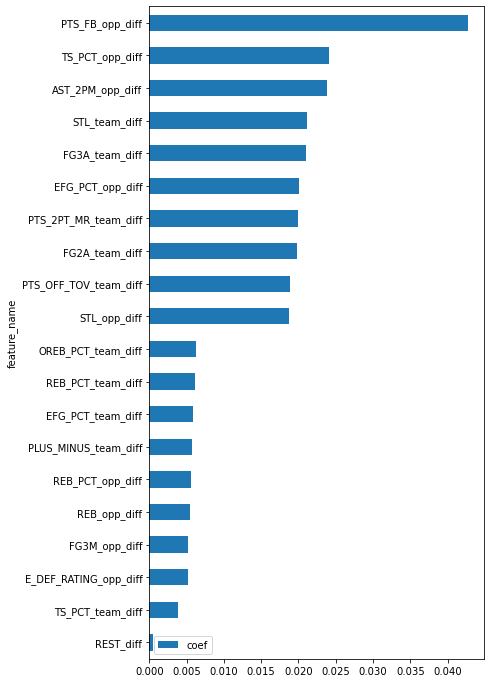

In [69]:
view_model_coefs(best_rf, X_train)

## Stacked Classifier

### new_version

In [85]:
estimators = [('ridge', best_ridge), ('sgd', best_sgd),
              ('lgbr', best_lgbr), ('knn', best_knn)]


stacked_reg = StackingRegressor(estimators = estimators,
                                 n_jobs=-1, verbose=1)


stacked_reg.fit(X_train, y_train)


stacked_train_preds = stacked_reg.predict(X_train)
stacked_test_preds = stacked_reg.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, stacked_train_preds))
print("test_MAE:", mean_absolute_error(y_test, stacked_test_preds))

train_MAE: 9.299964777601224
test_MAE: 10.241396794740343


0
test set 1: 2016-10-27 - 2017-06-12


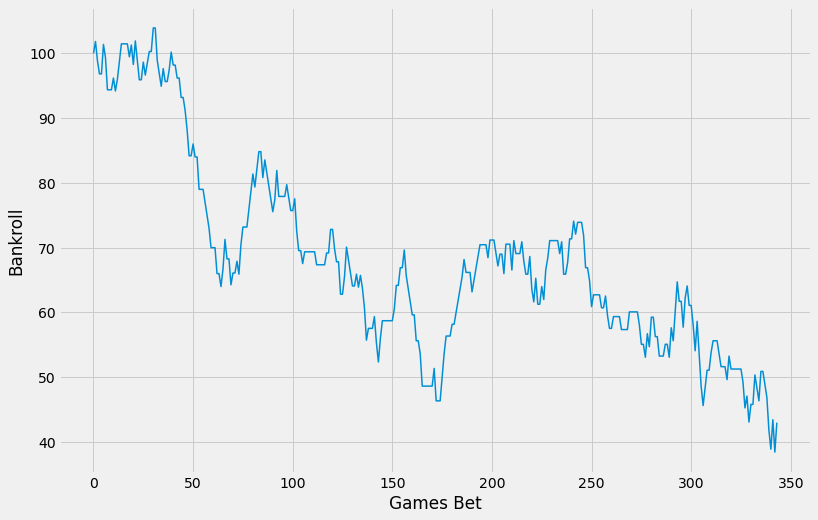

min balance: 38.000000000000036 
max balance: 103.9090909090909 
final balance: 38.000000000000036 
win percentage 48.55 
profit: -62.0 risk: 650.0 
ROI: -9.54
1
test set 1: 2017-10-20 - 2018-06-08


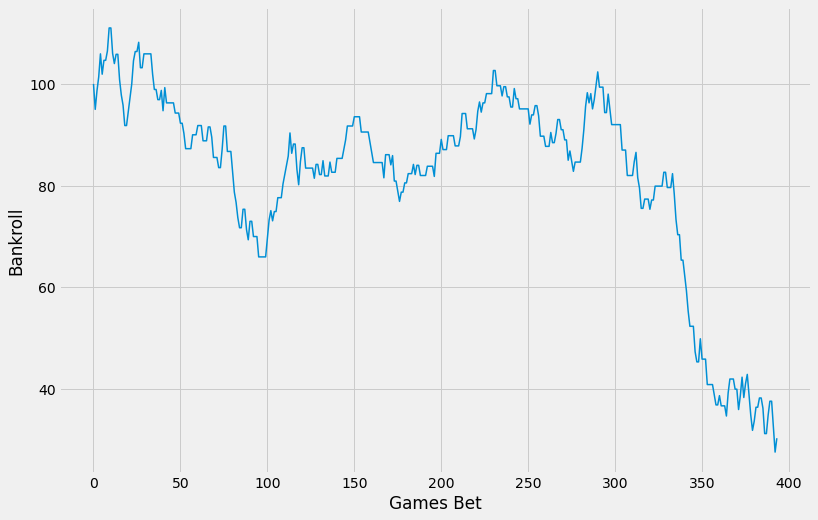

min balance: 27.636363636363676 
max balance: 111.00000000000001 
final balance: 30.363636363636402 
win percentage 49.24 
profit: -69.63636363636368 risk: 650.0 
ROI: -10.71
2
test set 1: 2018-10-19 - 2019-06-13


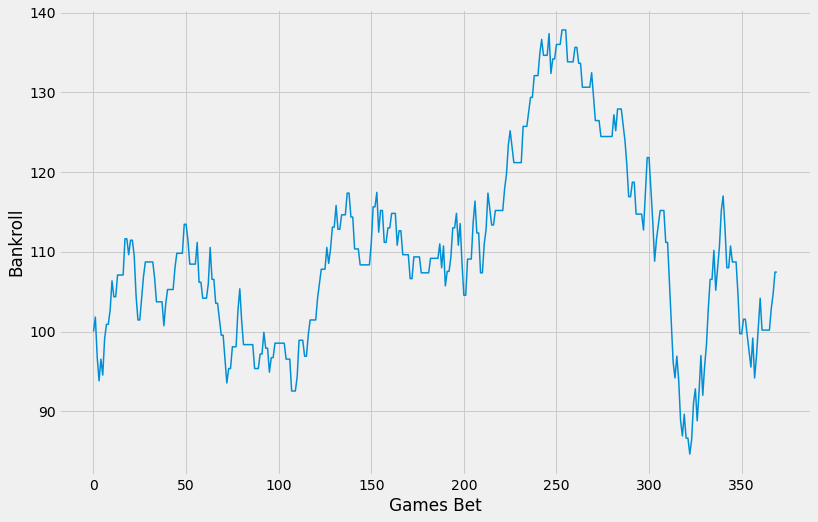

min balance: 84.63636363636361 
max balance: 137.81818181818178 
final balance: 107.45454545454548 
win percentage 50.81 
profit: 7.454545454545439 risk: 634.0 
ROI: 1.18
3
test set 1: 2019-10-25 - 2020-10-11


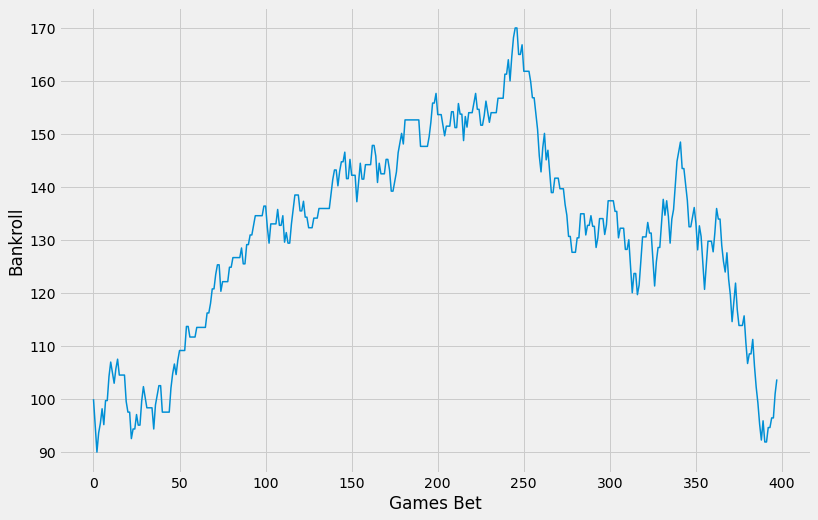

min balance: 90.0 
max balance: 170.0909090909087 
final balance: 103.7272727272721 
win percentage 55.03 
profit: 3.727272727272691 risk: 800.0 
ROI: 0.47000000000000003
4
test set 1: 2020-12-25 - 2021-07-20


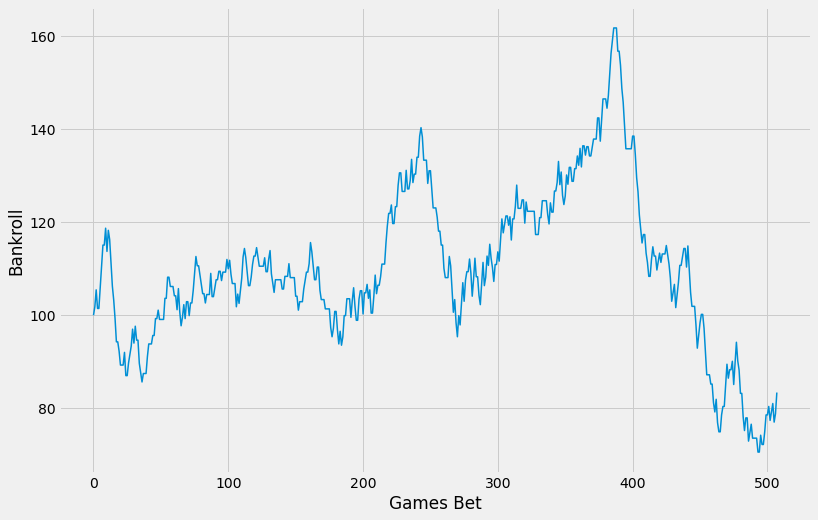

min balance: 70.54545454545435 
max balance: 161.81818181818164 
final balance: 85.18181818181797 
win percentage 50.59 
profit: -14.81818181818187 risk: 1187.0 
ROI: -1.25

 StackingRegressor(estimators=[('ridge',
                               Pipeline(steps=[('scaler', StandardScaler()),
                                               ('ridge',
                                                Ridge(alpha=99.94887557620284))])),
                              ('sgd',
                               Pipeline(steps=[('scaler', StandardScaler()),
                                               ('sgd',
                                                SGDRegressor(alpha=0.009864457997346513,
                                                             epsilon=0.005661054765240957,
                                                             loss='epsilon_insensitive',
                                                             max_iter=10000,
                                                   

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)               3  0.485465            344 -0.095385   
1  (2017, -, 2018)               3  0.492386            394 -0.107133   
2  (2018, -, 2019)               3  0.508108            370  0.011758   
3  (2019, -, 2020)               3  0.550251            398  0.004659   
4  (2020, -, 2021)               3  0.505906            508 -0.012484   

     profits  
0 -62.000000  
1 -69.636364  
2   7.454545  
3   3.727273  
4 -14.818182

In [92]:
estimators = [('ridge', best_ridge), ('sgd', best_sgd),
              ('lgbr', best_lgbr), ('knn', best_knn)]

stacked_reg = StackingRegressor(estimators = estimators,
                                 n_jobs=-1, verbose=1)


# stacked_clf.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 3

for estimator in [stacked_reg]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        
        y_preds = estimator.predict(X_test1)

        
        betting_df = create_betting_df(df_ewm_19_diffs, y_preds, test_idx1)

        
        select_bets = betting_df.loc[np.abs(betting_df['spread_pred_diff'])>threshold]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [89]:
ridge_preds = best_ridge.predict(X_test)
stacked_preds = stacked_reg.predict(X_test)
betting_df_stacked = create_betting_df(df_ewm_19_diffs, stacked_preds, test_idx)

print(betting_df_stacked['bet_won'].mean())

print('prediction_std:', betting_df_stacked['pred_avg'].std())
print('prediction_mean:', betting_df_stacked['pred_avg'].mean())


print(betting_df_stacked['spread_pred_diff'].std())

betting_df_stacked

0.5177339901477832
prediction_std: 5.512170987179789
prediction_mean: 2.7834173436894862
3.424644760353274


GAME_ID MATCHUP_home  SPREAD_home  SCORE_home  SCORE_away  \
0     0021600016  SAC vs. SAS          8.5          94         102   
1     0021600018  TOR vs. CLE          3.5          91          94   
2     0021600019  BKN vs. IND          6.5         103          94   
3     0021600020  DET vs. ORL         -4.0         108          82   
4     0021600021  OKC vs. PHX         -8.0         113         110   
...          ...          ...          ...         ...         ...   
6197  0022100073  MIA vs. CHA         -8.5         114          99   
6198  0022100074  NOP vs. SAC          1.5         109         113   
6199  0022100075  DEN vs. DAL         -4.0         106          75   
6200  0022100076  POR vs. LAC         -5.5         111          92   
6201  0022100077  LAL vs. CLE        -10.0         113         101   

      POINT_DIFF_home  cover_home  pred_home  pred_away   pred_avg  bet_home  \
0                  -8           1  -4.235680   4.294437  -4.265058         1   
1                  -3           1  -4.320121   4.508383  -4.414252         0   
2                   9           1  -7.184712   7.144455  -7.164583         0   
3                  26           1   5.617301  -5.523728   5.570515         1   
4                   3           0  10.773082 -10.606559  10.689820         1   
...               ...         ...        ...        ...        ...       ...   
6197               15           1   5.541762  -5.664691   5.603227         0   
6198               -4           0   1.507496  -1.437857   1.472676         1   
6199               31           1   3.221302  -3.108305   3.164803         0   
6200               19           1   1.696741  -1.510338   1.603539         0   
6201               12           1   7.950715  -8.042295   7.996505         0   

      spread_pred_diff  bet_won  bankroll_i  bankroll_n  bet_size  
0             4.234942        1       100.0         NaN       NaN  
1            -0.914252        0         NaN         NaN       NaN  
2            -0.664583        0         NaN         NaN       NaN  
3             1.570515        1         NaN         NaN       NaN  
4             2.689820        0         NaN         NaN       NaN  
...                ...      ...         ...         ...       ...  
6197         -2.896773        0         NaN         NaN       NaN  
6198          2.972676        0         NaN         NaN       NaN  
6199         -0.835197        0         NaN         NaN       NaN  
6200         -3.896461        0         NaN         NaN       NaN  
6201         -2.003495        0         NaN         NaN       NaN  

[6090 rows x 16 columns]

In [84]:
np.abs(betting_df_ridge['spread_pred_diff']).mean()

2.742403992913599

stacked clf train_acc: 0.5640048250904705
stacked clf test_acc: 0.512938849513763
0
test set 1: 2016-10-27 - 2017-06-12


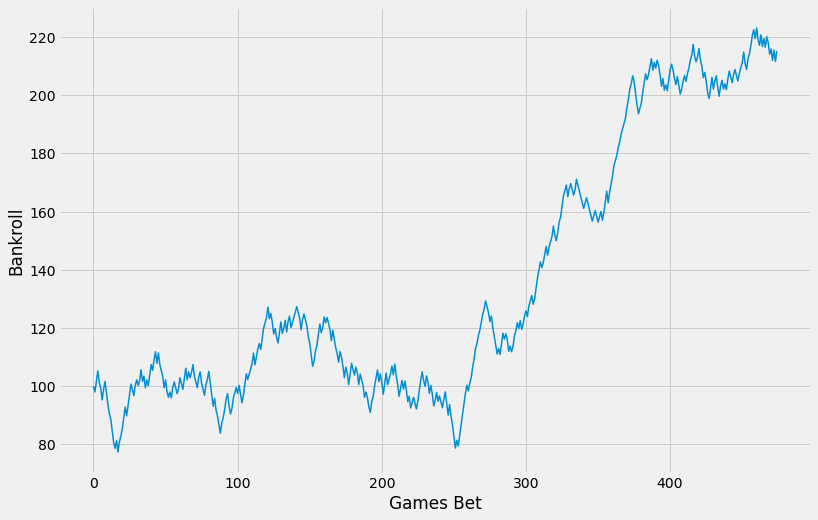

min balance: 77.36363636363639 
max balance: 223.0909090909086 
final balance: 211.18181818181765 
win percentage 55.78999999999999 
profit: 111.18181818181813 risk: 1397.0 
ROI: 7.960000000000001
1
test set 1: 2017-10-20 - 2018-06-08


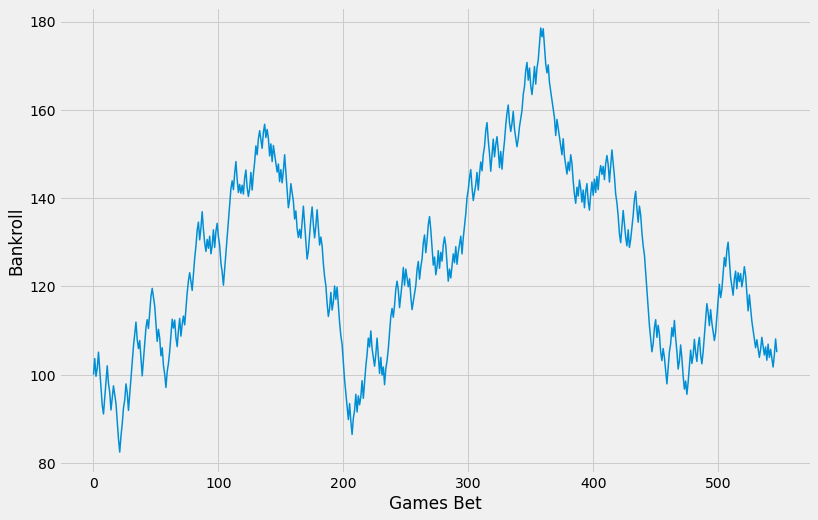

min balance: 82.45454545454548 
max balance: 178.54545454545396 
final balance: 102.0909090909083 
win percentage 51.28 
profit: 2.0909090909090082 risk: 1697.0 
ROI: 0.12
2
test set 1: 2018-10-19 - 2019-06-13


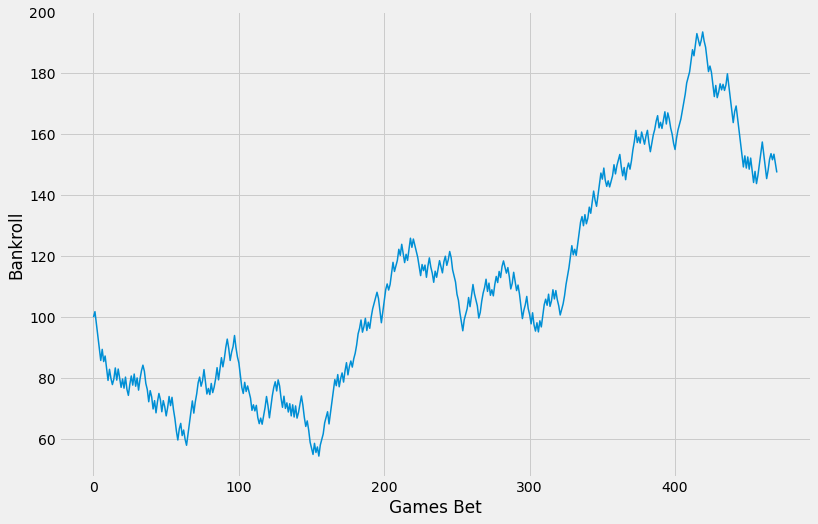

min balance: 54.45454545454561 
max balance: 193.54545454545445 
final balance: 149.272727272727 
win percentage 53.72 
profit: 49.27272727272725 risk: 1457.0 
ROI: 3.38
3
test set 1: 2019-10-25 - 2020-10-11


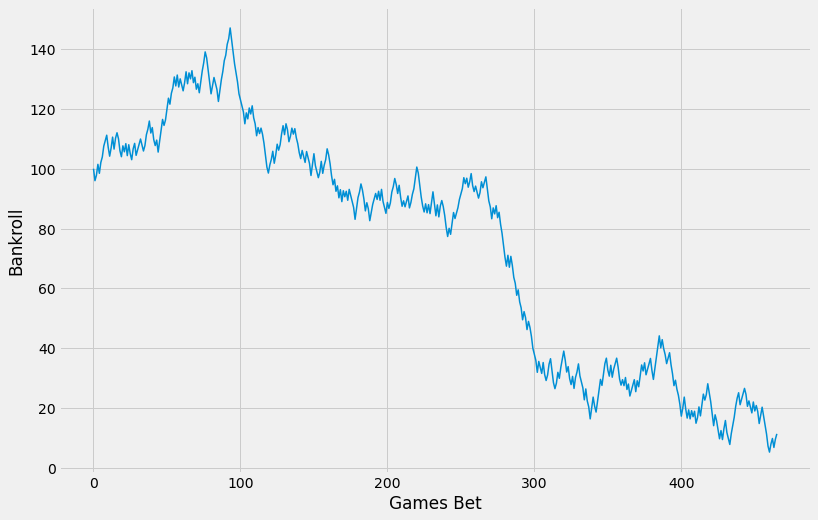

min balance: 5.363636363636289 
max balance: 146.99999999999986 
final balance: 14.181818181818105 
win percentage 48.93 
profit: -85.81818181818187 risk: 1405.0 
ROI: -6.11
4
test set 1: 2020-12-25 - 2021-07-20


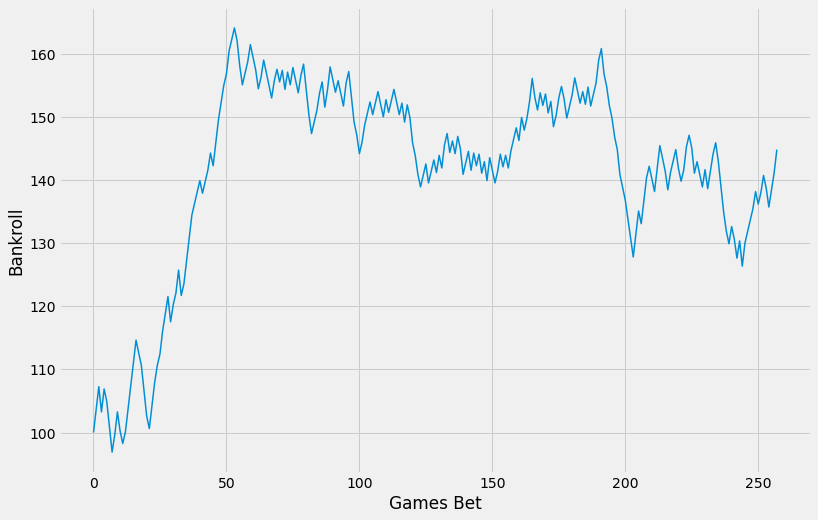

min balance: 96.90909090909092 
max balance: 164.09090909090904 
final balance: 147.5454545454538 
win percentage 54.65 
profit: 47.545454545454504 risk: 697.0 
ROI: 6.819999999999999
5
test set 1: 2021-10-22 - 2021-10-26


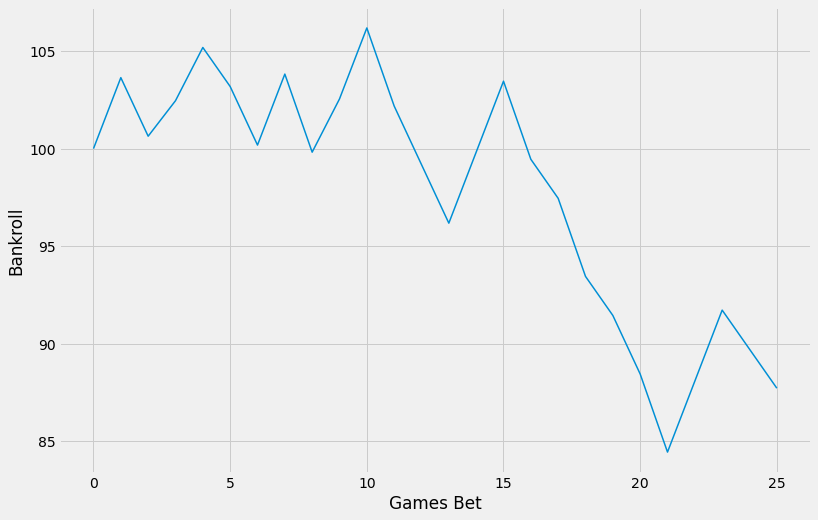

min balance: 83.72727272727276 
max balance: 106.1818181818182 
final balance: 83.72727272727276 
win percentage 38.46 
profit: -16.272727272727273 risk: 85.0 
ROI: -19.139999999999997

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.06226787404081285,
                                                                    max_iter=100000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('svc',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                    

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.557895            475  0.079586   
1  (2017, -, 2018)            0.53  0.512774            548  0.001232   
2  (2018, -, 2019)            0.53  0.537155            471  0.033818   
3  (2019, -, 2020)            0.53  0.489270            466 -0.061081   
4  (2020, -, 2021)            0.53  0.546512            258  0.068214   
5  (2021, -, 2021)            0.53  0.384615             26 -0.191444   

      profits  
0  111.181818  
1    2.090909  
2   49.272727  
3  -85.818182  
4   47.545455  
5  -16.272727

In [414]:
estimators = [('log', best_lr),
              ('svc', best_svc), ('lgbc', best_lgbc),
              ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


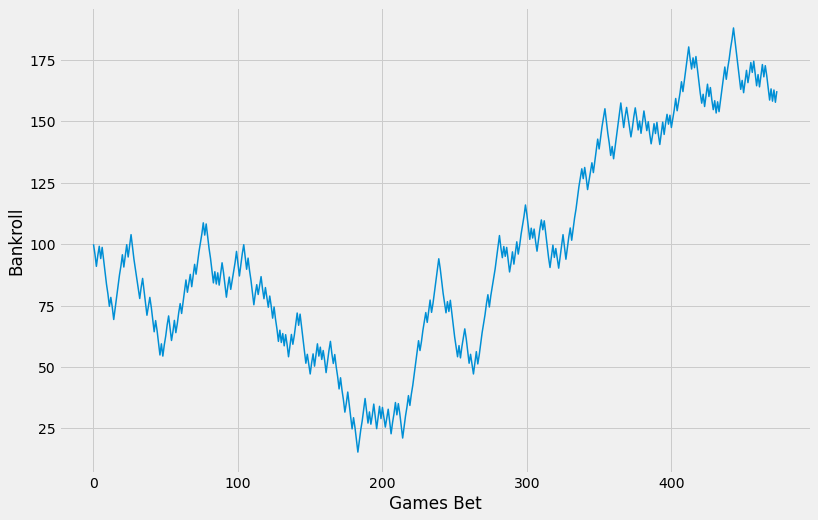

min balance: 15.36363636363648 
max balance: 188.09090909090864 
final balance: 157.36363636363575 
win percentage 53.800000000000004 
profit: 57.36363636363626 risk: 2203.0 
ROI: 2.6
1
test set 1: 2017-10-28 - 2018-06-08


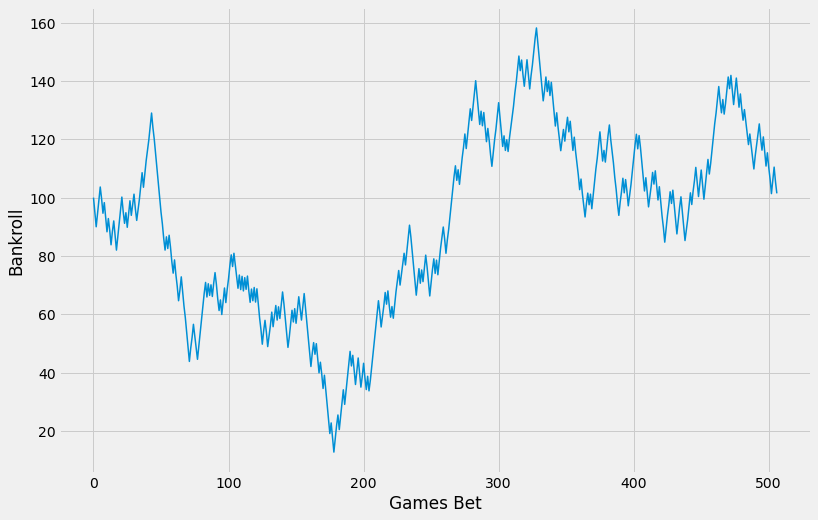

min balance: 12.727272727272808 
max balance: 158.18181818181813 
final balance: 97.45454545454537 
win percentage 52.27 
profit: -2.5454545454547315 risk: 2366.0 
ROI: -0.11
2
test set 1: 2018-10-26 - 2019-06-13


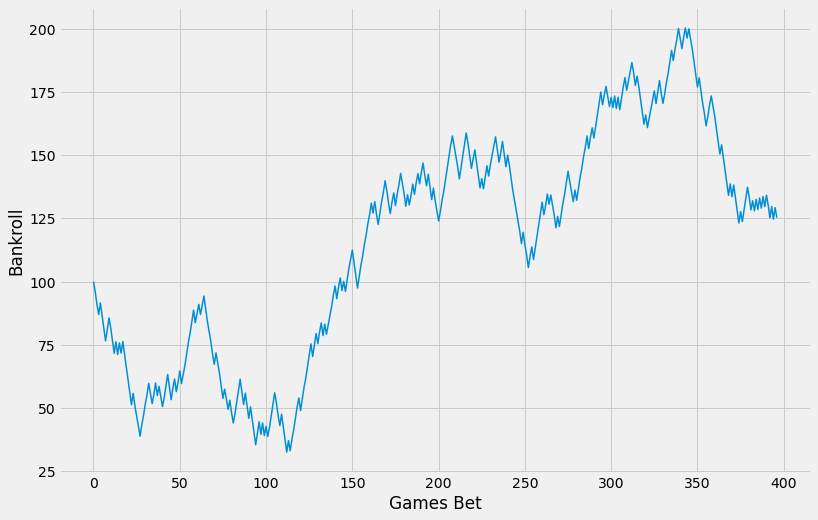

min balance: 32.545454545454554 
max balance: 200.3636363636354 
final balance: 128.90909090908974 
win percentage 52.900000000000006 
profit: 28.909090909090878 risk: 1821.0 
ROI: 1.59
3
test set 1: 2019-11-01 - 2020-10-11


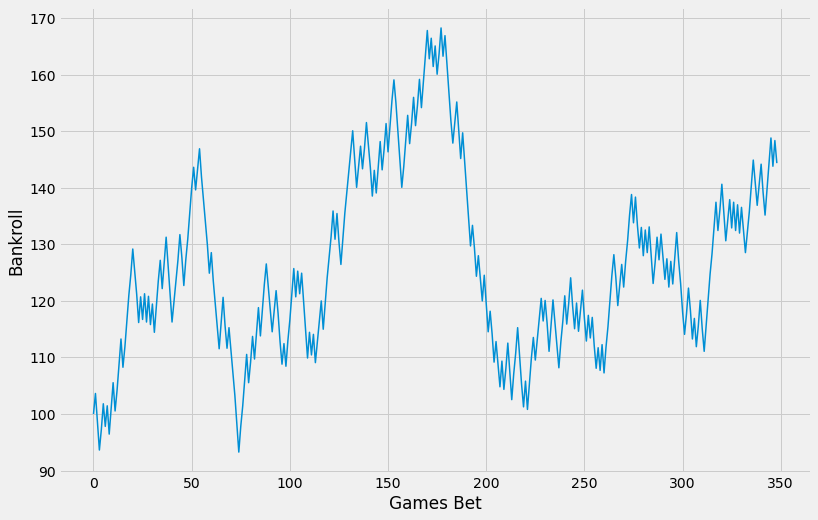

min balance: 93.27272727272727 
max balance: 168.27272727272694 
final balance: 147.9999999999994 
win percentage 54.15 
profit: 47.999999999999886 risk: 1590.0 
ROI: 3.02
4
test set 1: 2021-01-01 - 2021-07-20


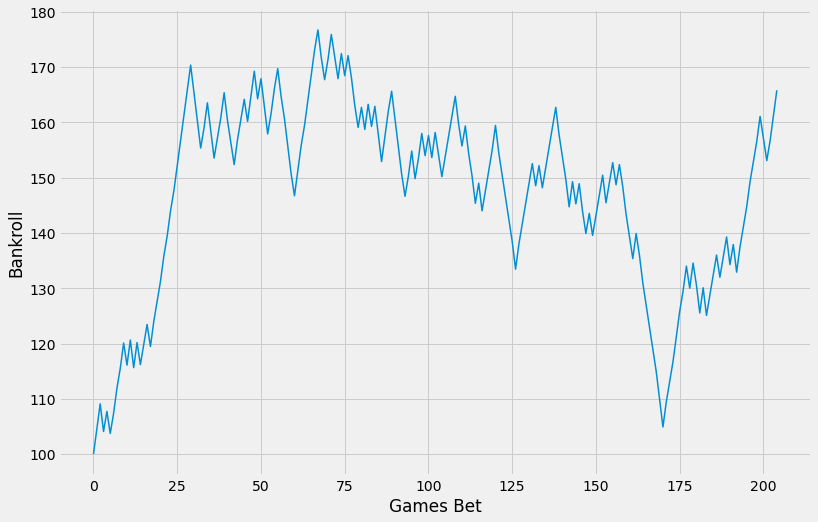

min balance: 103.72727272727273 
max balance: 176.7272727272724 
final balance: 170.36363636363532 
win percentage 56.589999999999996 
profit: 70.36363636363632 risk: 909.0 
ROI: 7.739999999999999

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.0011798799724438123,
                                                                    max_iter=10000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                       

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537975            474  0.026039   
1  (2017, -, 2018)            0.53  0.522682            507 -0.001076   
2  (2018, -, 2019)            0.53  0.528967            397  0.015875   
3  (2019, -, 2020)            0.53  0.541547            349  0.030189   
4  (2021, -, 2021)            0.53  0.565854            205  0.077408   

     profits  
0  57.363636  
1  -2.545455  
2  28.909091  
3  48.000000  
4  70.363636

In [113]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [660]:
best_lr_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001258237256125393, max_iter=10000,
                                    random_state=22, solver='saga',
                                    verbose=1))])

best_svc_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.003958061983606178, loss='hinge',
                           max_iter=100000, random_state=23))])

best_sgd_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.1572381278512917, loss='modified_huber',
                               max_iter=10000, random_state=23))])

best_lgbc_acc = lgb.LGBMClassifier(feature_fraction=0.7796269937403173, max_depth=5,
               min_child_weight=7, num_leaves=16860, random_state=22,
               reg_alpha=3.571940784753475, reg_lambda=17.76958546447963)

best_knn_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=24))])

best_rf_acc = RandomForestClassifier(max_depth=25,
                                min_samples_leaf=0.019764150817908317,
                                min_samples_split=0.10607525263857515,
                                random_state=22)

estimators2 = [('log', best_lr_acc), ('sgd', best_sgd_acc),
              ('svc', best_svc_acc), ('lgbc', best_lgbc_acc), 
              ('rf', best_rf_acc), ('knn', best_knn_acc)]


stacked_clf2 = StackingClassifier(estimators = estimators2, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))


0
test set 1: 2016-11-04 - 2017-06-12


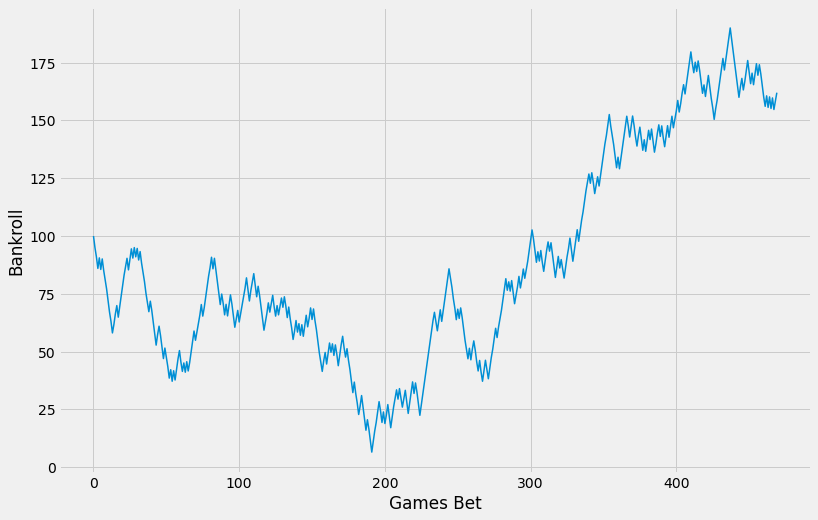

min balance: 6.545454545454625 
max balance: 189.99999999999957 
final balance: 165.63636363636303 
win percentage 53.620000000000005 
profit: 65.63636363636351 risk: 2189.0 
ROI: 3.0
1
test set 1: 2017-10-28 - 2018-06-08


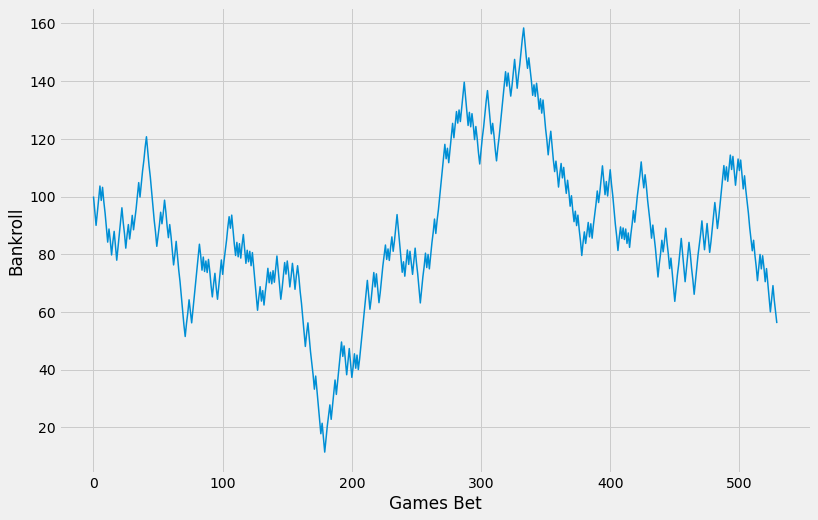

min balance: 11.36363636363652 
max balance: 158.45454545454544 
final balance: 52.09090909090921 
win percentage 51.32 
profit: -47.90909090909099 risk: 2482.0 
ROI: -1.9300000000000002
2
test set 1: 2018-10-26 - 2019-06-13


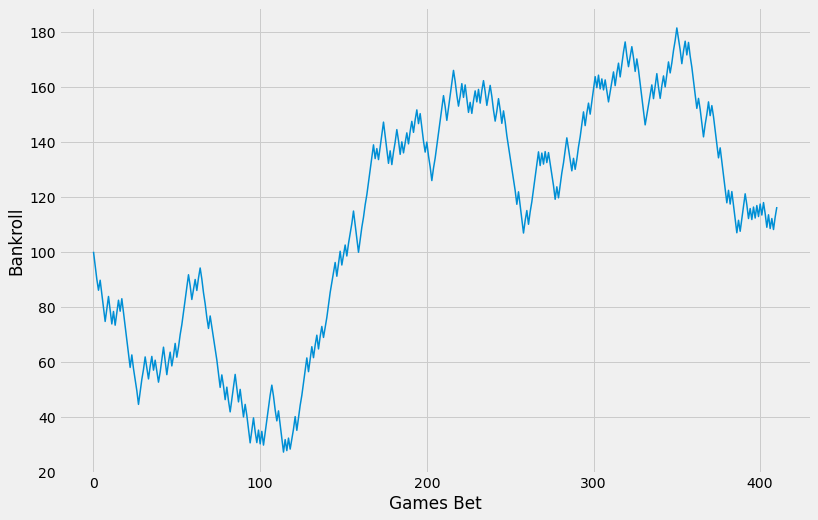

min balance: 27.090909090909136 
max balance: 181.4545454545445 
final balance: 119.90909090908988 
win percentage 52.55 
profit: 19.909090909090878 risk: 1893.0 
ROI: 1.05
3
test set 1: 2019-11-01 - 2020-10-11


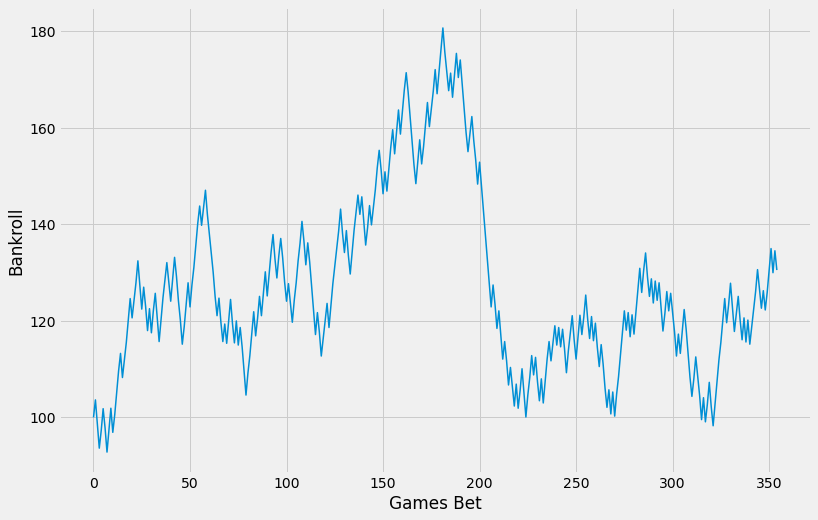

min balance: 92.81818181818183 
max balance: 180.7272727272722 
final balance: 134.18181818181765 
win percentage 53.52 
profit: 34.18181818181813 risk: 1621.0 
ROI: 2.11
4
test set 1: 2021-01-01 - 2021-07-20


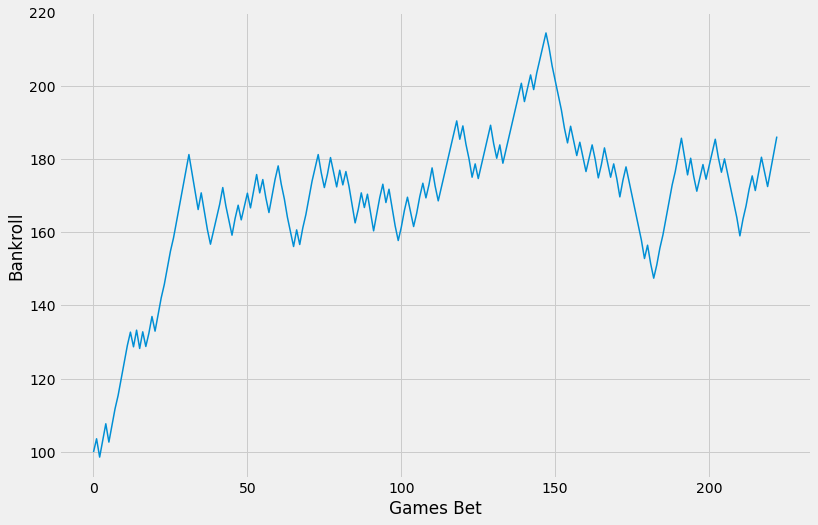

min balance: 98.63636363636364 
max balance: 214.36363636363544 
final balance: 190.6363636363623 
win percentage 56.95 
profit: 90.63636363636363 risk: 988.0 
ROI: 9.17

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SG

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.029985   
1  (2017, -, 2018)            0.53  0.513208            530 -0.019303   
2  (2018, -, 2019)            0.53  0.525547            411  0.010517   
3  (2019, -, 2020)            0.53  0.535211            355  0.021087   
4  (2021, -, 2021)            0.53  0.569507            223  0.091737   

     profits  
0  65.636364  
1 -47.909091  
2  19.909091  
3  34.181818  
4  90.636364

In [663]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


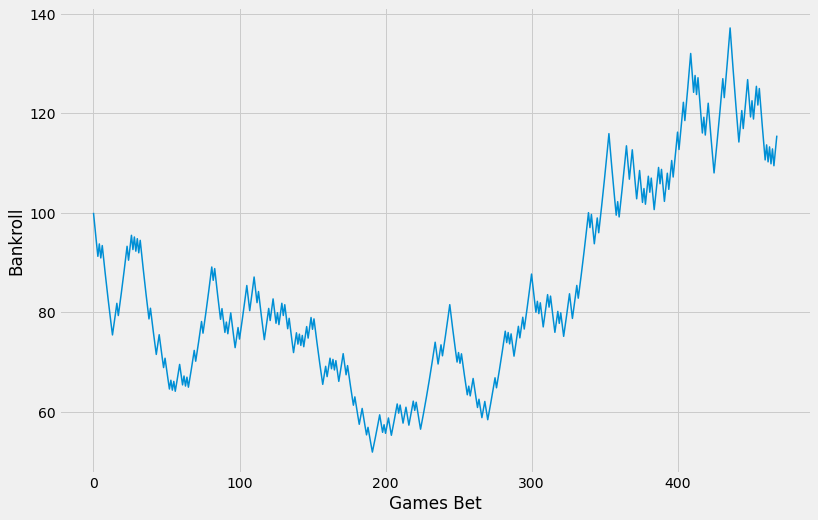

min balance: 51.95931418569775 
max balance: 137.1196961017868 
final balance: 118.65264767409444 
win percentage 53.73 
profit: 18.652647674094396 risk: 1192.5157733411133 
ROI: 1.5599999999999998
1
test set 1: 2017-10-28 - 2018-06-08


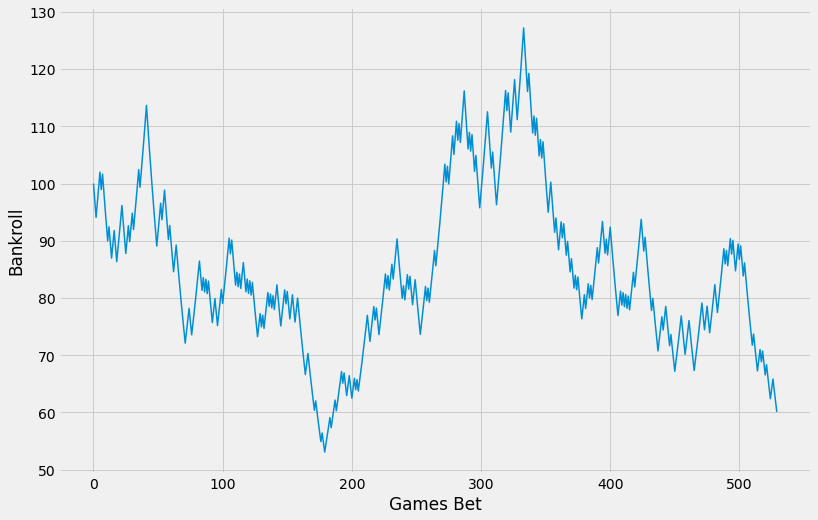

min balance: 53.078477196476335 
max balance: 127.18206300089665 
final balance: 58.29532195061766 
win percentage 51.32 
profit: -41.70467804938244 risk: 1350.6986843431337 
ROI: -3.09
2
test set 1: 2018-10-26 - 2019-06-13


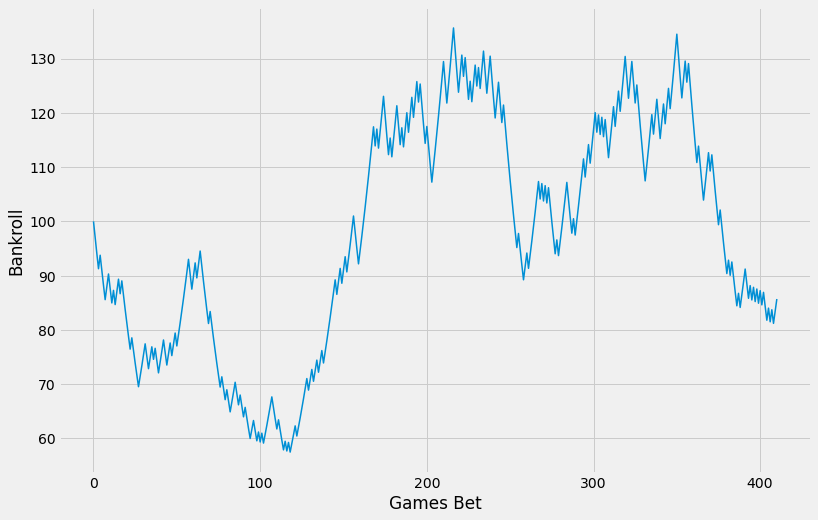

min balance: 57.47882989311353 
max balance: 135.63678545005874 
final balance: 88.02620525821162 
win percentage 52.55 
profit: -11.973794741788538 risk: 1205.5090846965707 
ROI: -0.9900000000000001
3
test set 1: 2019-11-01 - 2020-10-11


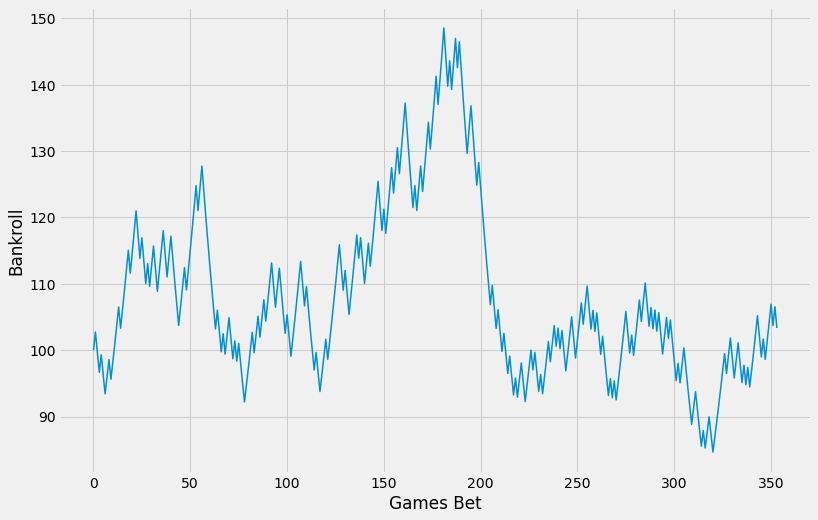

min balance: 84.64415680167593 
max balance: 148.53485625163472 
final balance: 106.15598328445795 
win percentage 53.39 
profit: 6.155983284457989 risk: 1146.171180097704 
ROI: 0.54
4
test set 1: 2021-01-01 - 2021-07-20


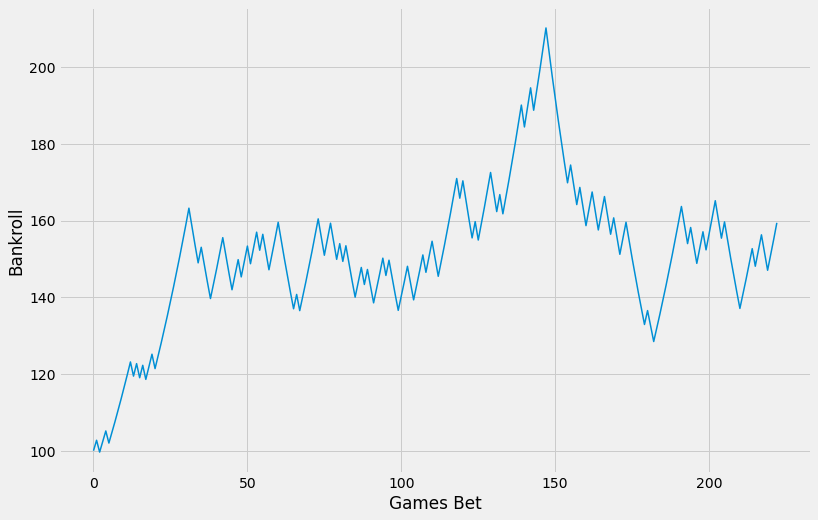

min balance: 99.64545454545456 
max balance: 210.19439280369414 
final balance: 163.74867588537154 
win percentage 56.95 
profit: 63.748675885371426 risk: 1011.0410842746564 
ROI: 6.3100000000000005

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                      

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537313            469  0.015641   
1  (2017, -, 2018)            0.53  0.513208            530 -0.030876   
2  (2018, -, 2019)            0.53  0.525547            411 -0.009933   
3  (2019, -, 2020)            0.53  0.533898            354  0.005371   
4  (2021, -, 2021)            0.53  0.569507            223  0.063053   

     profits  
0  18.652648  
1 -41.704678  
2 -11.973795  
3   6.155983  
4  63.748676

In [664]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_2(select_bets, unit_pct=0.03)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


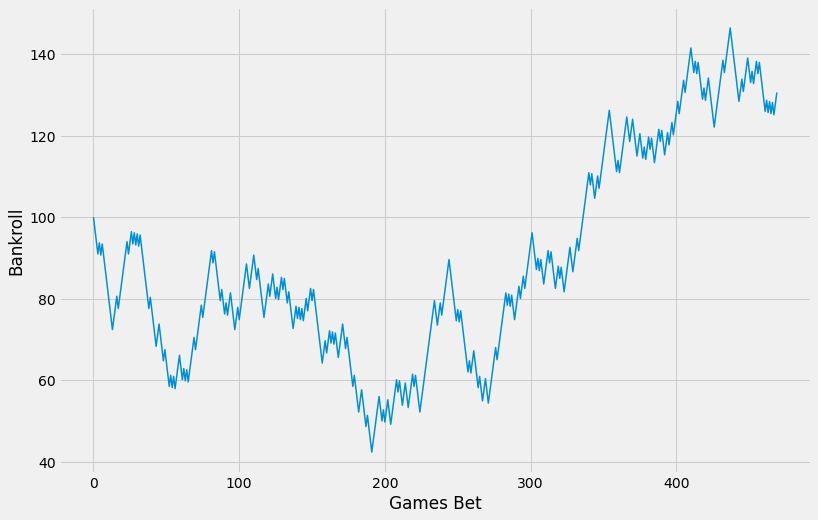

min balance: 42.45454545454595 
max balance: 146.3636363636373 
final balance: 133.27272727272813 
win percentage 53.620000000000005 
profit: 33.27272727272725 risk: 1410.0 
ROI: 2.36
1
test set 1: 2017-10-28 - 2018-06-08


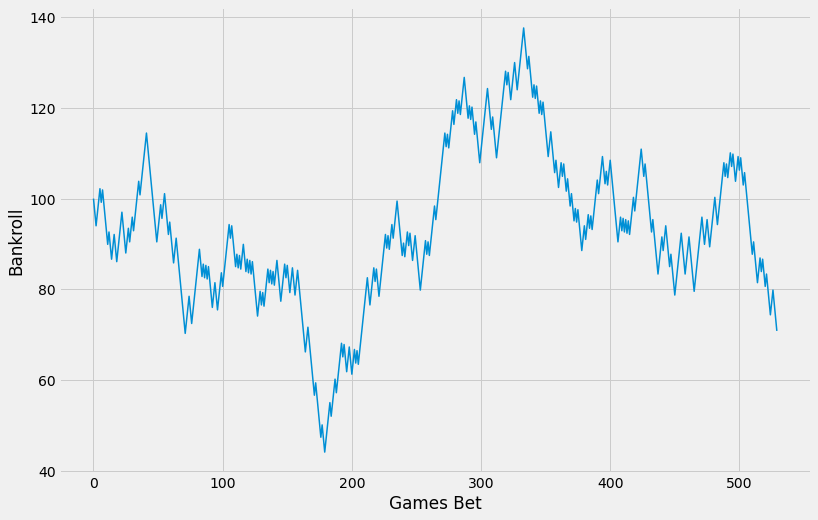

min balance: 44.09090909090962 
max balance: 137.63636363636468 
final balance: 67.81818181818343 
win percentage 51.32 
profit: -32.181818181818244 risk: 1590.0 
ROI: -2.02
2
test set 1: 2018-10-26 - 2019-06-13


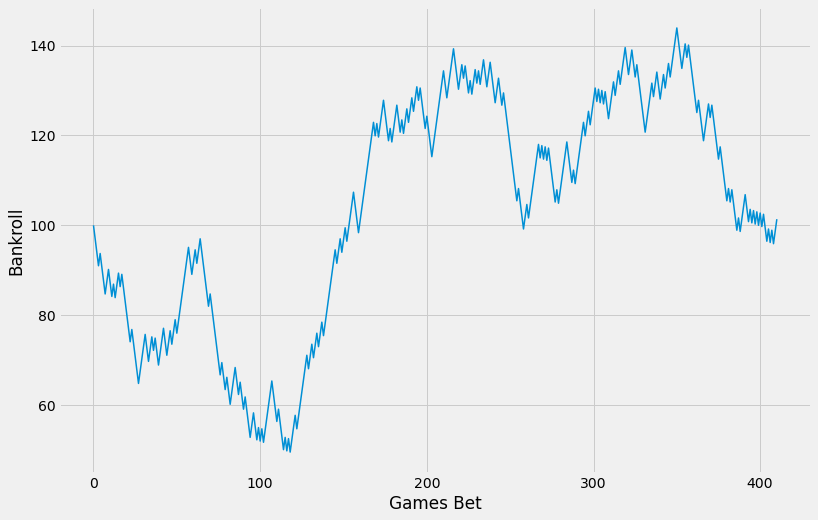

min balance: 49.54545454545478 
max balance: 143.9090909090913 
final balance: 104.0909090909096 
win percentage 52.55 
profit: 4.090909090909008 risk: 1233.0 
ROI: 0.33
3
test set 1: 2019-11-01 - 2020-10-11


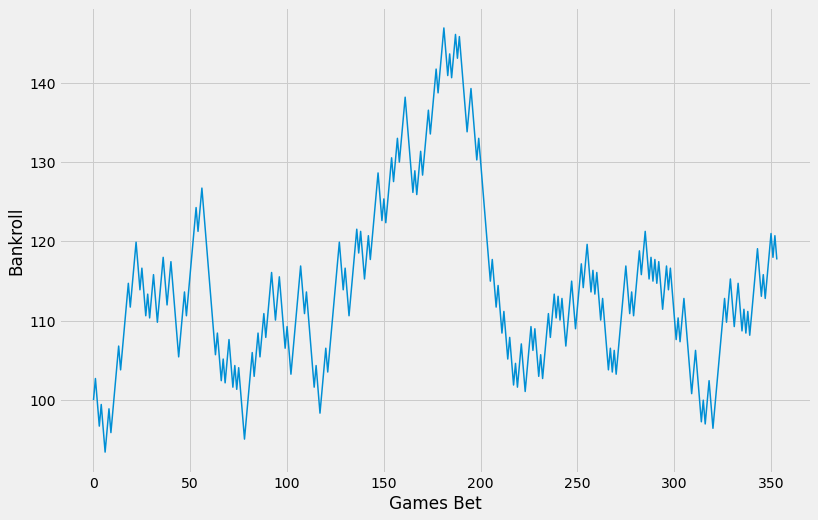

min balance: 93.45454545454547 
max balance: 146.90909090909133 
final balance: 120.45454545454633 
win percentage 53.39 
profit: 20.454545454545382 risk: 1062.0 
ROI: 1.9300000000000002
4
test set 1: 2021-01-01 - 2021-07-20


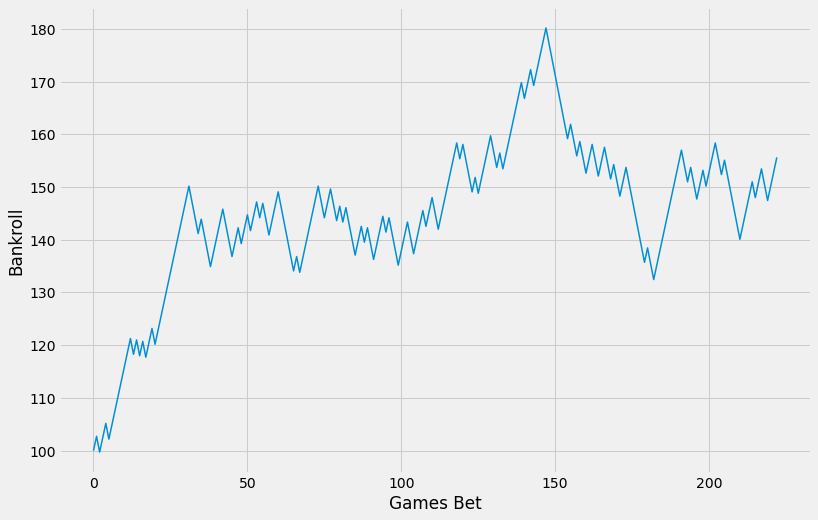

min balance: 99.72727272727273 
max balance: 180.1818181818177 
final balance: 158.3636363636356 
win percentage 56.95 
profit: 58.36363636363632 risk: 669.0 
ROI: 8.72

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SGD

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.023598   
1  (2017, -, 2018)            0.53  0.513208            530 -0.020240   
2  (2018, -, 2019)            0.53  0.525547            411  0.003318   
3  (2019, -, 2020)            0.53  0.533898            354  0.019260   
4  (2021, -, 2021)            0.53  0.569507            223  0.087240   

     profits  
0  33.272727  
1 -32.181818  
2   4.090909  
3  20.454545  
4  58.363636

In [665]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_1(select_bets, unit_size=3)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


## Make Predictions

ETL Pipeline

### Update Date

In [91]:
from src.data.update_data import update_all_data


# connection = sqlite3.connect('../data/nba.db')
# update_all_data(connection, season=2021)
# connection.close()



In [92]:
from src.models.model_preparation import get_days_spreads
from src.models.model_preparation import get_days_moneylines

from datetime import datetime

In [105]:
def season_str(x):
    return str(x) + '-' + str(x+1)[-2:]

def load_current_season_team_data(conn, season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", conn)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", conn)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", conn)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    
    df = df.loc[df['SEASON'] == season_str(2021)]
            
    return df





In [94]:
# connection = sqlite3.connect('../data/nba.db')
def load_current_season_betting_data(conn, season):
    season_string = season_str(season)
    spreads = pd.read_sql(f"SELECT * FROM spreads WHERE SEASON = '{season_string}'", conn)
    moneylines = pd.read_sql(f"SELECT * FROM moneylines WHERE SEASON = '{season_string}'", conn)
    conn.close()
    return spreads, moneylines



# create_matchups(df)
# get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True)


# connection.close()
# betting_data_21

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0    2021-22  1610612744               GSW   Golden State Warriors   
1    2021-22  1610612747               LAL      Los Angeles Lakers   
2    2021-22  1610612751               BKN           Brooklyn Nets   
3    2021-22  1610612749               MIL         Milwaukee Bucks   
4    2021-22  1610612766               CHA       Charlotte Hornets   
5    2021-22  1610612754               IND          Indiana Pacers   
6    2021-22  1610612741               CHI           Chicago Bulls   
7    2021-22  1610612765               DET         Detroit Pistons   
8    2021-22  1610612764               WAS      Washington Wizards   
9    2021-22  1610612761               TOR         Toronto Raptors   
10   2021-22  1610612755               PHI      Philadelphia 76ers   
11   2021-22  1610612740               NOP    New Orleans Pelicans   
12   2021-22  1610612763               MEM       Memphis Grizzlies   
13   2021-22  1610612739               CLE     Cleveland Cavaliers   
14   2021-22  1610612750               MIN  Minnesota Timberwolves   
15   2021-22  1610612745               HOU         Houston Rockets   
16   2021-22  1610612738               BOS          Boston Celtics   
17   2021-22  1610612752               NYK         New York Knicks   
18   2021-22  1610612759               SAS       San Antonio Spurs   
19   2021-22  1610612753               ORL           Orlando Magic   
20   2021-22  1610612756               PHX            Phoenix Suns   
21   2021-22  1610612743               DEN          Denver Nuggets   
22   2021-22  1610612758               SAC        Sacramento Kings   
23   2021-22  1610612757               POR  Portland Trail Blazers   
24   2021-22  1610612762               UTA               Utah Jazz   
25   2021-22  1610612760               OKC   Oklahoma City Thunder   
26   2021-22  1610612742               DAL        Dallas Mavericks   
27   2021-22  1610612737               ATL           Atlanta Hawks   
28   2021-22  1610612749               MIL         Milwaukee Bucks   
29   2021-22  1610612748               MIA              Miami Heat   
30   2021-22  1610612746               LAC             LA Clippers   
31   2021-22  1610612744               GSW   Golden State Warriors   
32   2021-22  1610612764               WAS      Washington Wizards   
33   2021-22  1610612754               IND          Indiana Pacers   
34   2021-22  1610612755               PHI      Philadelphia 76ers   
35   2021-22  1610612751               BKN           Brooklyn Nets   
36   2021-22  1610612761               TOR         Toronto Raptors   
37   2021-22  1610612738               BOS          Boston Celtics   
38   2021-22  1610612753               ORL           Orlando Magic   
39   2021-22  1610612752               NYK         New York Knicks   
40   2021-22  1610612766               CHA       Charlotte Hornets   
41   2021-22  1610612739               CLE     Cleveland Cavaliers   
42   2021-22  1610612740               NOP    New Orleans Pelicans   
43   2021-22  1610612741               CHI           Chicago Bulls   
44   2021-22  1610612760               OKC   Oklahoma City Thunder   
45   2021-22  1610612745               HOU         Houston Rockets   
46   2021-22  1610612759               SAS       San Antonio Spurs   
47   2021-22  1610612743               DEN          Denver Nuggets   
48   2021-22  1610612756               PHX            Phoenix Suns   
49   2021-22  1610612747               LAL      Los Angeles Lakers   
50   2021-22  1610612762               UTA               Utah Jazz   
51   2021-22  1610612758               SAC        Sacramento Kings   
52   2021-22  1610612737               ATL           Atlanta Hawks   
53   2021-22  1610612739               CLE     Cleveland Cavaliers   
54   2021-22  1610612754               IND          Indiana Pacers   
55   2021-22  1610612748               MIA              Miami Heat   
56   2021-22  16

In [95]:
def get_team_and_opp_ewm(df, min_periods=1, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values(
            'GAME_DATE_team')

        avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

        avg_ml = team_df['ML_team'].shift(1).expanding().mean()

        record = team_df['RECORD_team'].shift(1).expanding().mean()

        ATS_rec = team_df['TEAM_COVERED_team'].shift(
            1).expanding().mean()

        ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
            1).expanding().mean()

        records = pd.DataFrame({'WL_PCT': record,
                               'ATS_PCT': ATS_rec,
                                'AVG_SPREAD': avg_spread,
                                'AVG_ML': avg_ml,
                                'AVG_ATS_DIFF': ATS_avg_diff
                                })

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
            1).ewm(alpha=alpha, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df



In [124]:
team_avgs_21

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team          TEAM_NAME_team  \
0       2021-22    1610612744                    GSW   Golden State Warriors   
1       2021-22    1610612744                    GSW   Golden State Warriors   
2       2021-22    1610612744                    GSW   Golden State Warriors   
3       2021-22    1610612744                    GSW   Golden State Warriors   
4       2021-22    1610612747                    LAL      Los Angeles Lakers   
5       2021-22    1610612747                    LAL      Los Angeles Lakers   
6       2021-22    1610612747                    LAL      Los Angeles Lakers   
7       2021-22    1610612747                    LAL      Los Angeles Lakers   
8       2021-22    1610612751                    BKN           Brooklyn Nets   
9       2021-22    1610612751                    BKN           Brooklyn Nets   
10      2021-22    1610612751                    BKN           Brooklyn Nets   
11      2021-22    1610612751                    BKN           Brooklyn Nets   
12      2021-22    1610612749                    MIL         Milwaukee Bucks   
13      2021-22    1610612749                    MIL         Milwaukee Bucks   
14      2021-22    1610612749                    MIL         Milwaukee Bucks   
15      2021-22    1610612749                    MIL         Milwaukee Bucks   
16      2021-22    1610612766                    CHA       Charlotte Hornets   
17      2021-22    1610612766                    CHA       Charlotte Hornets   
18      2021-22    1610612766                    CHA       Charlotte Hornets   
19      2021-22    1610612766                    CHA       Charlotte Hornets   
20      2021-22    1610612754                    IND          Indiana Pacers   
21      2021-22    1610612754                    IND          Indiana Pacers   
22      2021-22    1610612754                    IND          Indiana Pacers   
23      2021-22    1610612754                    IND          Indiana Pacers   
24      2021-22    1610612741                    CHI           Chicago Bulls   
25      2021-22    1610612741                    CHI           Chicago Bulls   
26      2021-22    1610612741                    CHI           Chicago Bulls   
27      2021-22    1610612741                    CHI           Chicago Bulls   
28      2021-22    1610612765                    DET         Detroit Pistons   
29      2021-22    1610612765                    DET         Detroit Pistons   
30      2021-22    1610612765                    DET         Detroit Pistons   
31      2021-22    1610612764                    WAS      Washington Wizards   
32      2021-22    1610612764                    WAS      Washington Wizards   
33      2021-22    1610612764                    WAS      Washington Wizards   
34      2021-22    1610612761                    TOR         Toronto Raptors   
35      2021-22    1610612761                    TOR         Toronto Raptors   
36      2021-22    1610612761                    TOR         Toronto Raptors   
37      2021-22    1610612761                    TOR         Toronto Raptors   
38      2021-22    1610612755                    PHI      Philadelphia 76ers   
39      2021-22    1610612755                    PHI      Philadelphia 76ers   
40      2021-22    1610612755                    PHI      Philadelphia 76ers   
41      2021-22    1610612755                    PHI      Philadelphia 76ers   
42      2021-22    1610612740                    NOP    New Orleans Pelicans   
43      2021-22    1610612740                    NOP    New Orleans Pelicans   
44      2021-22    1610612740                    NOP    New Orleans Pelicans   
45      2021-22    1610612740                    NOP    New Orleans Pelicans   
46      2021-22    1610612763                    MEM       Memphis Grizzlies   
47      2021-22    1610612763                    MEM       Memphis Grizzlies   
48      2021-22    1610612763                    MEM       Memphis Grizzlies   
49  

In [96]:
from datetime import date
date.today()

datetime.date(2021, 10, 29)

In [97]:
def add_rest_days_for_model(df):
    df['REST'] = np.nan
    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        idx = team_df.index
        team_df['rest'] = (team_df['GAME_DATE_team'].shift(-1) - team_df['GAME_DATE_team']) / np.timedelta64(1, 'D')
        team_df.at[max(idx), 'REST'] = (pd.to_datetime(date.today()) - team_df.at[max(idx), 'GAME_DATE_team']) / np.timedelta64(1, 'D')

        df.loc[idx, 'REST'] = team_df['REST']
            
    return df


Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


In [98]:
def get_current_season_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.sort_values(['GAME_ID', 'HOME_GAME_team'])
    df = df.reset_index(drop=True)

    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = pd.Series(prev_season_final_elo.ELO.values, index=elo_final_2020.TEAM).to_dict()

    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.at[idx, 'team_rating_i'] = df.at[idx-1, 'opp_rating_i']
            df.at[idx, 'team_rating_n'] = df.at[idx-1, 'opp_rating_n']
            df.at[idx, 'opp_rating_i'] = df.at[idx-1, 'team_rating_i']
            df.at[idx, 'opp_rating_n'] = df.at[idx-1, 'team_rating_n']
            df.at[idx, 'team_elo_pred'] = 1 - df.at[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP_team'][:3]
        opp_abbr = row['MATCHUP_team'][-3:]   
        
        df.at[idx, 'team_rating_i'] = elo_dic[team_abbr]            
        df.at[idx, 'opp_rating_i'] = elo_dic[opp_abbr]
            

        team_score = row['TEAM_SCORE_team']
        opp_score = row['TEAM_SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME_team'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.at[idx, 'team_rating_n'] = team_rating + team_update
        df.at[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.at[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.at[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.at[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)
    

    return elo_dic, df


# final_elo_2020 = pd.read_csv("../data/final_elo_ratings_2020")
# current_elo, team_avgs_21 = get_current_season_elo_ratings(team_avgs_21, final_elo_2020)


In [251]:
team_avgs_21

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team          TEAM_NAME_team  \
0       2021-22    1610612751                    BKN           Brooklyn Nets   
1       2021-22    1610612749                    MIL         Milwaukee Bucks   
2       2021-22    1610612744                    GSW   Golden State Warriors   
3       2021-22    1610612747                    LAL      Los Angeles Lakers   
4       2021-22    1610612754                    IND          Indiana Pacers   
5       2021-22    1610612766                    CHA       Charlotte Hornets   
6       2021-22    1610612741                    CHI           Chicago Bulls   
7       2021-22    1610612765                    DET         Detroit Pistons   
8       2021-22    1610612738                    BOS          Boston Celtics   
9       2021-22    1610612752                    NYK         New York Knicks   
10      2021-22    1610612764                    WAS      Washington Wizards   
11      2021-22    1610612761                    TOR         Toronto Raptors   
12      2021-22    1610612739                    CLE     Cleveland Cavaliers   
13      2021-22    1610612763                    MEM       Memphis Grizzlies   
14      2021-22    1610612745                    HOU         Houston Rockets   
15      2021-22    1610612750                    MIN  Minnesota Timberwolves   
16      2021-22    1610612755                    PHI      Philadelphia 76ers   
17      2021-22    1610612740                    NOP    New Orleans Pelicans   
18      2021-22    1610612753                    ORL           Orlando Magic   
19      2021-22    1610612759                    SAS       San Antonio Spurs   
20      2021-22    1610612760                    OKC   Oklahoma City Thunder   
21      2021-22    1610612762                    UTA               Utah Jazz   
22      2021-22    1610612743                    DEN          Denver Nuggets   
23      2021-22    1610612756                    PHX            Phoenix Suns   
24      2021-22    1610612758                    SAC        Sacramento Kings   
25      2021-22    1610612757                    POR  Portland Trail Blazers   
26      2021-22    1610612742                    DAL        Dallas Mavericks   
27      2021-22    1610612737                    ATL           Atlanta Hawks   
28      2021-22    1610612749                    MIL         Milwaukee Bucks   
29      2021-22    1610612748                    MIA              Miami Heat   
30      2021-22    1610612746                    LAC             LA Clippers   
31      2021-22    1610612744                    GSW   Golden State Warriors   
32      2021-22    1610612766                    CHA       Charlotte Hornets   
33      2021-22    1610612739                    CLE     Cleveland Cavaliers   
34      2021-22    1610612752                    NYK         New York Knicks   
35      2021-22    1610612753                    ORL           Orlando Magic   
36      2021-22    1610612754                    IND          Indiana Pacers   
37      2021-22    1610612764                    WAS      Washington Wizards   
38      2021-22    1610612761                    TOR         Toronto Raptors   
39      2021-22    1610612738                    BOS          Boston Celtics   
40      2021-22    1610612751                    BKN           Brooklyn Nets   
41      2021-22    1610612755                    PHI      Philadelphia 76ers   
42      2021-22    1610612740                    NOP    New Orleans Pelicans   
43      2021-22    1610612741                    CHI           Chicago Bulls   
44      2021-22    1610612760                    OKC   Oklahoma City Thunder   
45      2021-22    1610612745                    HOU         Houston Rockets   
46      2021-22    1610612759                    SAS       San Antonio Spurs   
47      2021-22    1610612743                    DEN          Denver Nuggets   
48      2021-22    1610612756                    PHX            Phoenix Suns   
49  

In [100]:
def create_matchup_rows_for_model(df, home_team, away_team, home_spread, away_spread, home_ml, away_ml):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_team':'SEASON',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df = df.sort_values(['GAME_ID', 'HOME_GAME'])
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)

    home_diffs = home_stats.iloc[-1, 14:-6] - away_stats.iloc[-1, 14:-6]
    home_diffs = home_diffs.values.reshape(1, -1)    
    home_diffs = np.concatenate([home_diffs, home_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)

    away_diffs = away_stats.iloc[-1, 14:-6] - home_stats.iloc[-1, 14:-6]
    away_diffs = away_diffs.values.reshape(1, -1)
    away_diffs = np.concatenate([away_diffs, away_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)
    
    diffs = np.concatenate([home_diffs, away_diffs], axis=0)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:-6]]
    new_cols.extend(home_stats.columns[-6:])
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
    
    diffs['SPREAD_team'] = np.nan
    diffs['ML_team'] = np.nan
    
    diffs.at[0, 'SPREAD_team'] = away_spread 
    diffs.at[1, 'SPREAD_team'] = home_spread
    
    diffs.at[0, 'ML_team'] = away_ml
    diffs.at[1, 'ML_team'] = home_ml
    
    diffs = diffs[X_train.columns].astype(float)
    
    return diffs


### Make Predictions

In [102]:

def make_predictions(model, df):
    todays_date = datetime.today().strftime('%Y-%m-%d')

    todays_spreads = get_days_spreads(todays_date)
    todays_spreads = clean_spreads_df(todays_spreads)

    todays_mls = get_days_moneylines(todays_date)
    todays_mls = clean_moneyline_df(todays_mls)
    
    todays_lines = pd.concat([todays_spreads, todays_mls.iloc[:, -2:]], axis=1)

    game_dates = []
    home_teams = []
    away_teams = []
    home_spreads = []
    home_cover_probs = []
    away_cover_probs = []

    for idx, row in todays_lines.iterrows():
        home_team = row['HOME_TEAM']
        away_team = row['AWAY_TEAM']
        home_spread = row['HIGHEST_HOME_SPREAD'] 
        away_spread = row['HIGHEST_AWAY_SPREAD']
        home_ml = row['HIGHEST_HOME_ML']
        away_ml = row['HIGHEST_AWAY_ML']
        game_date = row['GM_DATE']
        matchup = create_matchup_rows_for_model(df, home_team, away_team,
                                                home_spread, away_spread, home_ml, away_ml)

        probs = model.predict_proba(matchup)

        game_dates.append(game_date)
        home_teams.append(home_team)
        away_teams.append(away_team)
        home_cover_probs.append(probs[0, 1])
        away_cover_probs.append(probs[1, 1])
        home_spreads.append(home_spread)

    todays_predictions = pd.DataFrame({'game_date':game_dates,
                                      'home_team':home_teams,
                                      'away_team':away_teams,
                                       'home_spread':home_spreads,
                                      'home_cover_probs':home_cover_probs,
                                      'away_cover_probs':away_cover_probs})

    todays_predictions['home_cover_avg'] = (todays_predictions['home_cover_probs'] 
                                            + (1-todays_predictions['away_cover_probs']))/2
    return todays_predictions

In [121]:
# X_full = pd.concat([X_train, X_test])
# y_full = pd.concat([y_train, y_test])

# X_full.shape, y_full.shape

# estimators = [('log', best_lr), ('sgd', best_sgd),
#               ('svc', best_svc), ('lgbc', best_lgbc),
#              ('rf', best_rf), ('knn', best_knn)]


# final_stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
#                                  n_jobs=-1, verbose=1)


# final_stacked_clf.fit(X_full, y_full)


filename = '../models/finalized_stacked_model'

joblib.dump(final_stacked_clf, filename)

['../models/finalized_stacked_model']

In [108]:
X_train

RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
15450         -0.473684       -3.473684       10.105263       -3.473684   
15451          0.473684        3.473684      -10.105263        3.473684   
15466          0.000000       -0.157895       10.368421        2.210526   
15467          0.000000        0.157895      -10.368421       -2.210526   
15474          0.526316        5.105263       11.052632       -2.210526   
...                 ...             ...             ...             ...   
41189          0.143834       -0.786681       -0.582086        1.593153   
41190          0.029448       -2.308044       -1.923904        1.833843   
41191         -0.029448        2.308044        1.923904       -1.833843   
41192          0.073498        3.277257        2.431520       -2.150465   
41193         -0.073498       -3.277257       -2.431520        2.150465   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
15450       -1.684211      -0.263158      -2.789474       10.052632   
15451        1.684211       0.263158       2.789474      -10.052632   
15466        4.736842       0.526316       4.157895        6.315789   
15467       -4.736842      -0.526316      -4.157895       -6.315789   
15474       -7.842105       0.000000       0.263158       -1.368421   
...               ...            ...            ...             ...   
41189        3.217412       0.922036       0.587392       -0.807284   
41190        4.795702       1.329841       0.828656       -0.226543   
41191       -4.795702      -1.329841      -0.828656        0.226543   
41192       -5.516144      -0.696841      -0.445778        0.103885   
41193        5.516144       0.696841       0.445778       -0.103885   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
15450        3.526316      13.578947      -8.473684       1.578947   
15451       -3.526316     -13.578947       8.473684      -1.578947   
15466       -1.578947       4.736842      -5.526316       3.000000   
15467        1.578947      -4.736842       5.526316      -3.000000   
15474        0.947368      -0.421053       2.842105       2.052632   
...               ...            ...            ...            ...   
41189        0.755402      -0.051882       3.479550       0.447166   
41190        0.379854       0.153312       3.431598      -0.097563   
41191       -0.379854      -0.153312      -3.431598       0.097563   
41192        0.758152       0.862037      -2.588423       0.787820   
41193       -0.758152      -0.862037       2.588423      -0.787820   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
15450      -0.368421       2.526316     -5.263158     -17.631579   
15451       0.368421      -2.526316      5.263158      17.631579   
15466      -1.000000       0.421053      7.421053       6.842105   
15467       1.000000      -0.421053     -7.421053      -6.842105   
15474      -0.578947       0.263158     -1.315789       3.578947   
...              ...            ...           ...            ...   
41189       1.222646       1.022656      1.334851       4.128134   
41190       1.100376       1.020388      1.101360       2.215282   
41191      -1.100376      -1.020388     -1.101360      -2.215282   
41192      -0.590329      -1.118352     -0.991219      -0.593722   
41193       0.590329       1.118352      0.991219       0.593722   

       PLUS_MINUS_team_diff  E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  \
15450            -21.000000              -17.952632                1.868421   
15451             21.000000               17.952632               -1.868421   
15466              3.315789               -4.731579               -6.742105   
15467             -3.315789                4.731579                6.742105   
15474             10.789474               -1.815789              -11.368421   
...                     ...                     ...                     ...   
41189             -0.612905               

In [123]:
final_stacked_model = joblib.load('../models/finalized_stacked_model')


final_stacked_model.predict(X_train)

array([1, 0, 0, ..., 1, 1, 0])

In [126]:
def main(conn, season, model, prev_season_elo):
    update_all_data(conn, season=season)

    df = load_current_season_team_data(conn, season)

    df = clean_team_data(df)

    df = prep_for_aggregation(df)

    spreads, moneylines = load_current_season_betting_data(conn, 2021)
    clean_moneylines = clean_moneyline_df(df=moneylines)
    clean_spreads = clean_spreads_df(df=spreads)


    full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
    full_df = create_matchups(full_df)
    full_df = get_team_and_opp_ewm(full_df)

    full_df = add_percentage_features(full_df)
    full_df = add_rest_days_for_model(full_df)

    current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)
    
    todays_predictions = make_predictions(model, full_df)
    
    todays_predictions.to_csv("../test_data.csv", mode='a', header=False, index=False)  
    
    return todays_predictions



In [127]:
connection = sqlite3.connect('../data/nba.db')

prev_season_elo = pd.read_csv("../data/final_elo_ratings_2020")
todays_predictions = main(connection, 2021, final_stacked_clf, prev_season_elo)

connection.close()

todays_predictions

progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.31s/it]
progress:: 154it [00:00, 4529.64it/s]


game_date home_team away_team  home_spread  home_cover_probs  \
0   2021-10-30       WAS       BOS         -4.0          0.506587   
1   2021-10-30       DET       ORL         -8.0          0.520615   
2   2021-10-30       NOP       NYK          6.0          0.446485   
3   2021-10-30       IND       TOR         -4.5          0.467039   
4   2021-10-30       PHI       ATL         -5.5          0.557671   
5   2021-10-30       CHI       UTA          4.5          0.501391   
6   2021-10-30       MIL       SAS         -7.0          0.494550   
7   2021-10-30       MEM       MIA         -3.0          0.500480   
8   2021-10-30       GSW       OKC        -14.5          0.530507   
9   2021-10-30       MIN       DEN         -3.0          0.551326   
10  2021-10-30       PHX       CLE        -10.0          0.569496   

    away_cover_probs  home_cover_avg  
0           0.499518        0.503535  
1           0.471622        0.524496  
2           0.550445        0.448020  
3           0.532006        0.467516  
4           0.442400        0.557636  
5           0.500978        0.500206  
6           0.509464        0.492543  
7           0.500311        0.500085  
8           0.472792        0.528858  
9           0.451358        0.549984  
10          0.431999        0.568748

In [117]:
todays_predictions.to_csv("../test_data.csv", index=False)

In [118]:
todays_predictions.to_csv("../test_data.csv", mode='a', header=False, index=False)

In [119]:
pd.read_csv('../test_data.csv')

game_date home_team away_team  home_spread  home_cover_probs  \
0   2021-10-29       TOR       ORL         -9.0          0.589156   
1   2021-10-29       MIA       CHA         -8.5          0.502124   
2   2021-10-29       BKN       IND        -10.5          0.503996   
3   2021-10-29       NOP       SAC          3.5          0.433964   
4   2021-10-29       POR       LAC         -5.5          0.481502   
5   2021-10-29       DEN       DAL         -3.5          0.511928   
6   2021-10-29       LAL       CLE         -8.5          0.485542   
7   2021-10-29       TOR       ORL         -9.0          0.589156   
8   2021-10-29       MIA       CHA         -8.5          0.502124   
9   2021-10-29       BKN       IND        -10.5          0.503996   
10  2021-10-29       NOP       SAC          3.5          0.433964   
11  2021-10-29       POR       LAC         -5.5          0.481502   
12  2021-10-29       DEN       DAL         -3.5          0.511928   
13  2021-10-29       LAL       CLE         -8.5          0.485542   

    away_cover_probs  home_cover_avg  
0           0.413940        0.587608  
1           0.490751        0.505686  
2           0.496721        0.503638  
3           0.561797        0.436084  
4           0.523630        0.478936  
5           0.489419        0.511255  
6           0.509621        0.487960  
7           0.413940        0.587608  
8           0.490751        0.505686  
9           0.496721        0.503638  
10          0.561797        0.436084  
11          0.523630        0.478936  
12          0.489419        0.511255  
13          0.509621        0.487960

In [39]:
# Load Models

with open('../models/sgd_ewm_19.pkl', 'rb') as f:
    sgd_pipe = pickle.load(f)
    
with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
    best_lgbr = pickle.load(f)
    
with open('../models/xgb_ewm_19.pkl', 'rb') as f:
    best_xgbr = pickle.load(f)
    
with open('../models/rf_ewm_19.pkl', 'rb') as f:
    best_rf = pickle.load(f)
    
with open('../models/en_ewm_19.pkl', 'rb') as f:
    en_pipe = pickle.load(f)
    
with open("../models/lasso_ewm_19.pkl", 'rb') as f:
    lasso_pipe = pickle.load(f)

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.183092      -0.0763285        -0.144892   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0          0.011143        1.19352        2.20987   -0.000726966   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0         3.2203       1.87994       1.69273       0.741648       -2.30137   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -1.55972       2.97972       1.86619      0.521539      -1.49935   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      4.14165        4.2648             0.363874               0.192724   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              2.11145               0.115911              1.12315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              0.0677887             0.984322        1.99059   -0.00237432   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.44673          3.10111               3.84759   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             3.58807           2.97124           -1.88749         0.0143575   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.100572             3.90093        0.144892       -1.1599   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0      0.536119       1.02301      -1.28157      3.15171      2.90113   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00155193       1.63512      1.63357      3.34388     -1.87421   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.858817      2.82509     1.82035      3.90093           -0.363874   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0              0.115911             1.12315              0.192724   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             2.11145            -0.0677887           -0.984322       2.35787   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00237432            0.095416         3.99595              -3.6913   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -2.36804          2.24413          -3.42199           1.1797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.161641         0.00481673         0.0116754         -0.0116754   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0       -0.00481673         -0.017652         0.017652       -0.0128075   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0213821         -0.017978       0.00875831              2.4739   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.70151          -1.85381           2.1216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.383526    1329.036655    1411.484854          0.63

In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


away_team home_team  spread   game_date        net_pred
0       DAL       WAS     4.5  2021-04-03    [-2.0314543]
1       CLE       MIA   -12.0  2021-04-03    [-0.7431023]
2       MIN       PHI   -13.0  2021-04-03     [-2.774469]
3       NYK       DET     1.5  2021-04-03    [0.21155608]
4       IND       SAS    -6.0  2021-04-03    [-1.0953536]
5       ORL       UTA   -15.0  2021-04-03  [-0.026118085]
6       MIL       SAC     5.5  2021-04-03    [0.10418765]
7       OKC       POR   -11.5  2021-04-03     [-2.474314]

In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df